In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os
from get_model import getmodel
import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    #file_tot=file_end-file_start
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((n,n,121))
y=np.zeros((n,n,121))
vx=np.zeros((n,n,121))
vy=np.zeros((n,n,121))

#print(x[0,:,:])

In [4]:
#u is not pre adding, v add a median

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)

spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

u=np.zeros((n,n,121, 3))
u[:, :, :, 0] = vx
u[:, :, :, 1] = vy

t=np.linspace(0,60/800,121)

t_in=np.zeros((n,n,121))
for i in range (len(t)):
    t_in[:,:,i]=t[i]

u[:, :, :, 2] = t_in

dt=t[1]-t[0]

t_adding=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
print(t_adding.shape)
dt_adding=t_adding[1]-t_adding[0]

u_train=np.zeros((n,n,len(t_adding),3))

for i in range(len(t)-1):
    for j in range(addp):
        u_train[:,:,addp*i+j]=(u[:,:,i]*(addp-j)+u[:,:,i+1]*j)/addp
u_train[:,:,-1]=u[:,:,-1]


(601,)


In [5]:
# import test data
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,51,100,xstart,xend)
ut=np.zeros((n,n,121, 3))

ut[:, :, :, 0] = vx_test
ut[:, :, :, 1] = vy_test
ut[:, :, :, 2] = t_in

u_test=np.zeros((n,n,len(t_adding), 3))

for i in range(len(t)-1):
    for j in range(addp):
        u_test[:,:,addp*i+j]=(ut[:,:,i]*(addp-j)+ut[:,:,i+1]*j)/addp
u_test[:,:,-1]=ut[:,:,-1]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

round: 0
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 44.923 1 + -5.797 Vx + 148.143 Vy + -9266.441 t + -10.249 VxVx + 31.571 VyVy + 537950.809 tt + -9.056 VxVy + 293.824 Vxt + -4504.378 Vyt + -0.764 VxVxVy + 651.751 VxVxt + -2405.855 VyVyt + 210.465 VxVyt + 416.858 Vx_2 + 115.906 Vy_2 + 260.968 Vx_1 + 113.913 Vy_1 + -35.558 VxVx_2 + -304.545 VxVy_2 + -117908.593 Vxt_2 + 6.190 VyVx_2 + -15.679 VyVy_2 + 5938290.616 Vyt_2 + -1.985 tVx_2 + 2397.840 tVy_2 + 1052.720 tt_2 + 2.805 VxVxVx_2 + -231.577 VxVxVy_2 + 46.745 VxVxt_2 + -207.818 VyVyVx_2 + 131.123 VyVyVy_2 + -25.895 VyVyt_2 + -58150.108 ttVx_2 + -0.850 ttVy_2 + -1.795 ttt_2 + 3674757.226 VxVyVx_2 + 33.649 VxVyVy_2 + 14558.276 VxVyt_2 + 1578.378 VxtVx_2 + -2.081 VxtVy_2 + -661.637 Vxtt_2 + 116.404 VytVx_2 + 29.850 VytVy_2 + -38.221 VxVx_1 + -32.408 VxVy_1 + -90420.828 Vxt_1 + 8.848 VyVx_1 + 4.095 VyVy_1 + 4829758.575 Vyt_1 + 26.230 tVx_1 + 1230.018 tVy_1 + 3499.088 tt_1 + -0.288 VxVxVx_1 + -192.542 VxVxVy_1 + -1328.983 VxVxt_1 + -1431.287 Vy

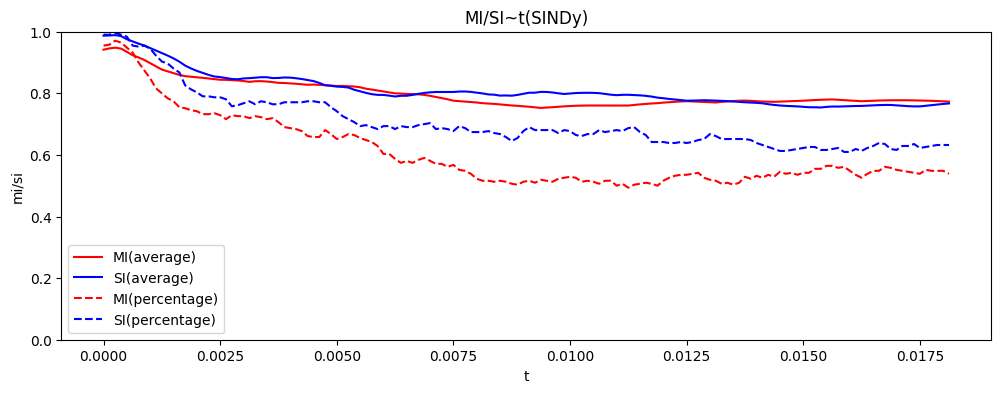

round: 1
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -44.150 1 + -34.419 Vx + 140.046 Vy + 15413.635 t + -7.493 VxVx + 27.699 VyVy + -723281.116 tt + -7.348 VxVy + 2459.675 Vxt + -2058.823 Vyt + -0.626 VxVxVy + 454.893 VxVxt + -1894.607 VyVyt + -250.922 VxVyt + 406.515 Vx_2 + -31.231 Vy_2 + 219.107 Vx_1 + 181.740 Vy_1 + -56.173 VxVx_2 + -307.806 VxVy_2 + -109786.341 Vxt_2 + 8.425 VyVx_2 + -10.951 VyVy_2 + 5381773.027 Vyt_2 + 0.246 tVx_2 + 4773.168 tVy_2 + -308.828 tt_2 + 3.202 VxVxVx_2 + -479.080 VxVxVy_2 + -736.092 VxVxt_2 + -204.815 VyVyVx_2 + 174.740 VyVyVy_2 + -18.914 VyVyt_2 + -25877.187 ttVx_2 + -6.398 ttVy_2 + -2.850 ttt_2 + 2144789.060 VxVyVx_2 + 30.589 VxVyVy_2 + 11029.184 VxVyt_2 + -392.388 VxtVx_2 + -0.747 VxtVy_2 + -100.592 Vxtt_2 + 189.920 VytVx_2 + 654.176 VytVy_2 + -53.285 VxVx_1 + -20.025 VxVy_1 + -82363.258 Vxt_1 + 14.290 VyVx_1 + 1.155 VyVy_1 + 4475471.842 Vyt_1 + 25.520 tVx_1 + 3261.772 tVy_1 + 380.472 tt_1 + -0.362 VxVxVx_1 + -717.342 VxVxVy_1 + -1207.078 VxVxt_1 + -1034.

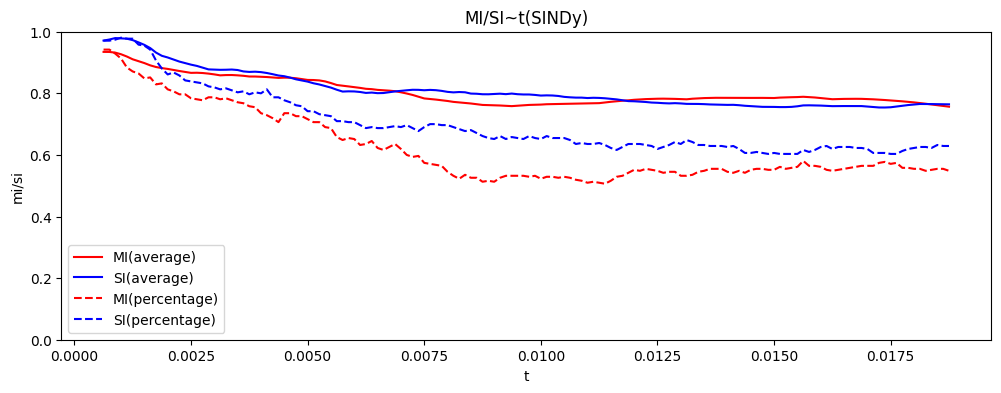

round: 2
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -101.818 1 + -23.445 Vx + 133.622 Vy + 29280.891 t + -10.724 VxVx + 22.689 VyVy + -1392048.756 tt + -5.730 VxVy + 821.202 Vxt + -1678.826 Vyt + -0.869 VxVxVy + 706.549 VxVxt + -1540.036 VyVyt + -541.032 VxVyt + 421.432 Vx_2 + -183.964 Vy_2 + 294.906 Vx_1 + 260.556 Vy_1 + -57.493 VxVx_2 + -351.709 VxVy_2 + -105688.275 Vxt_2 + 5.999 VyVx_2 + -12.080 VyVy_2 + 4960656.635 Vyt_2 + 13.933 tVx_2 + 4773.584 tVy_2 + 5389.867 tt_2 + 2.361 VxVxVx_2 + -313.283 VxVxVy_2 + -125.494 VxVxt_2 + -1382.031 VyVyVx_2 + 271.671 VyVyVy_2 + -19.387 VyVyt_2 + 9117.943 ttVx_2 + -19.527 ttVy_2 + -6.852 ttt_2 + 439937.505 VxVyVx_2 + 34.691 VxVyVy_2 + 1281.098 VxVyt_2 + -343.689 VxtVx_2 + -0.110 VxtVy_2 + 1166.906 Vxtt_2 + 425.137 VytVx_2 + -378.838 VytVy_2 + -71.701 VxVx_1 + -66.652 VxVy_1 + -88755.435 Vxt_1 + 18.019 VyVx_1 + -13.765 VyVy_1 + 4376259.842 Vyt_1 + 37.934 tVx_1 + 4634.465 tVy_1 + 2725.686 tt_1 + 0.778 VxVxVx_1 + -928.811 VxVxVy_1 + -9.829 VxVxt_1 + -226

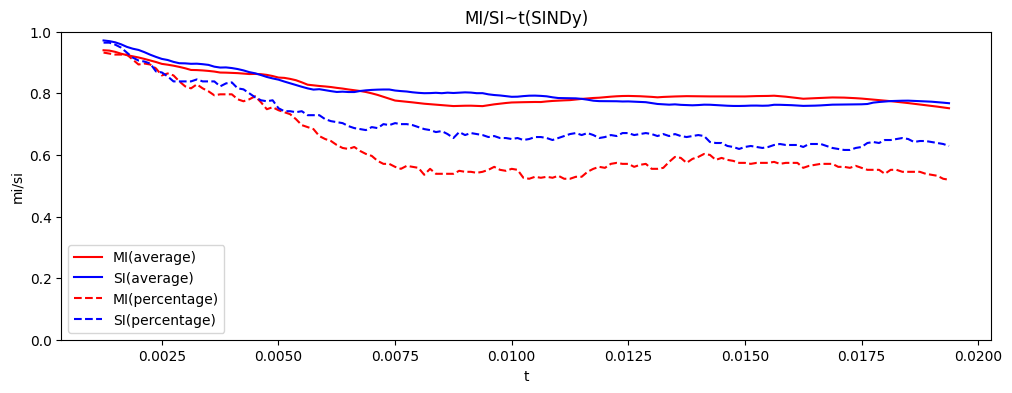

round: 3
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -203.589 1 + -6.683 Vx + 101.599 Vy + 46726.301 t + -15.045 VxVx + 17.262 VyVy + -2030051.541 tt + 2.080 VxVy + -44.538 Vxt + 669.581 Vyt + -0.809 VxVxVy + 1020.420 VxVxt + -1127.296 VyVyt + -1058.526 VxVyt + 140.822 Vx_2 + -144.329 Vy_2 + 146.267 Vx_1 + 201.638 Vy_1 + -44.018 VxVx_2 + -333.885 VxVy_2 + -49763.883 Vxt_2 + 1.905 VyVx_2 + -14.462 VyVy_2 + 2550178.785 Vyt_2 + 8.684 tVx_2 + 4248.198 tVy_2 + 5340.760 tt_2 + 1.075 VxVxVx_2 + -121.927 VxVxVy_2 + 520.957 VxVxt_2 + -529.324 VyVyVx_2 + 260.818 VyVyVy_2 + -72.020 VyVyt_2 + 5671.547 ttVx_2 + -20.651 ttVy_2 + -11.147 ttt_2 + 475521.671 VxVyVx_2 + 38.477 VxVyVy_2 + 40.856 VxVyt_2 + 3816.337 VxtVx_2 + 0.850 VxtVy_2 + 1390.332 Vxtt_2 + 653.154 VytVx_2 + -1598.256 VytVy_2 + -34.341 VxVx_1 + -152.252 VxVy_1 + -52250.192 Vxt_1 + 7.430 VyVx_1 + -27.312 VyVy_1 + 2586822.434 Vyt_1 + 56.022 tVx_1 + 1254.268 tVy_1 + 9523.888 tt_1 + 0.893 VxVxVx_1 + -90.034 VxVxVy_1 + 971.952 VxVxt_1 + -4233.675 V

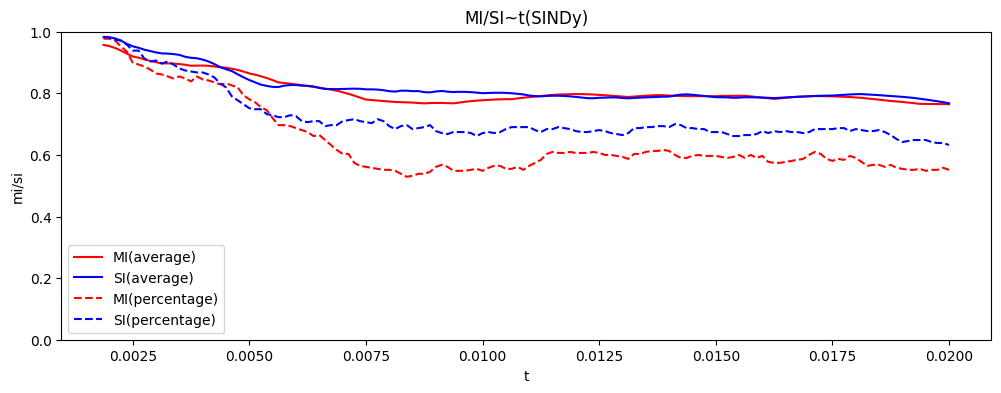

round: 4
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -225.921 1 + -17.451 Vx + 134.325 Vy + 48308.683 t + -5.968 VxVx + 19.146 VyVy + -2015861.239 tt + -14.939 VxVy + 1158.095 Vxt + -2072.795 Vyt + -1.200 VxVxVy + 200.838 VxVxt + -1406.007 VyVyt + 375.254 VxVyt + 282.472 Vx_2 + -304.646 Vy_2 + 137.458 Vx_1 + -88.316 Vy_1 + -61.919 VxVx_2 + -404.437 VxVy_2 + -65367.337 Vxt_2 + 5.250 VyVx_2 + -32.424 VyVy_2 + 2872360.202 Vyt_2 + 18.925 tVx_2 + 5993.459 tVy_2 + 12068.701 tt_2 + -0.030 VxVxVx_2 + -451.709 VxVxVy_2 + 2519.990 VxVxt_2 + -929.539 VyVyVx_2 + 406.172 VyVyVy_2 + -92.488 VyVyt_2 + 32699.729 ttVx_2 + -38.818 ttVy_2 + -15.986 ttt_2 + -620241.670 VxVyVx_2 + 58.374 VxVyVy_2 + -12812.525 VxVyt_2 + 5688.210 VxtVx_2 + 1.230 VxtVy_2 + 2989.092 Vxtt_2 + 913.434 VytVx_2 + -4136.861 VytVy_2 + 38.780 VxVx_1 + -199.135 VxVy_1 + -48336.136 Vxt_1 + -0.988 VyVx_1 + -25.360 VyVy_1 + 2317993.908 Vyt_1 + 70.048 tVx_1 + -4601.549 tVy_1 + 10507.515 tt_1 + 2.381 VxVxVx_1 + 625.746 VxVxVy_1 + 314.548 VxVxt_1

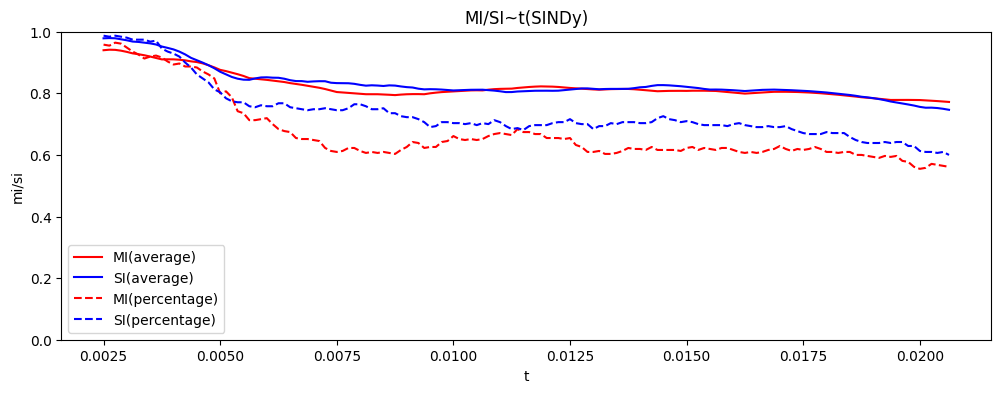

round: 5
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -294.281 1 + -39.296 Vx + 151.684 Vy + 56387.485 t + 2.048 VxVx + 21.021 VyVy + -2224035.518 tt + -31.050 VxVy + 3265.390 Vxt + -4134.410 Vyt + -0.886 VxVxVy + -325.900 VxVxt + -1661.798 VyVyt + 1842.585 VxVyt + 188.407 Vx_2 + -605.650 Vy_2 + -73.262 Vx_1 + -250.104 Vy_1 + -61.744 VxVx_2 + -475.021 VxVy_2 + -43055.183 Vxt_2 + -3.030 VyVx_2 + -42.712 VyVy_2 + 1831000.991 Vyt_2 + 24.994 tVx_2 + 5603.981 tVy_2 + 19766.690 tt_2 + -0.823 VxVxVx_2 + 179.510 VxVxVy_2 + 3865.424 VxVxt_2 + -1428.761 VyVyVx_2 + 459.197 VyVyVy_2 + -54.124 VyVyt_2 + 94608.241 ttVx_2 + -57.354 ttVy_2 + -13.358 ttt_2 + -3267504.220 VxVyVx_2 + 67.056 VxVyVy_2 + -18141.719 VxVyt_2 + 3066.130 VxtVx_2 + -0.617 VxtVy_2 + 4111.978 Vxtt_2 + 720.346 VytVx_2 + -4992.561 VytVy_2 + 36.566 VxVx_1 + -120.886 VxVy_1 + -9819.688 Vxt_1 + -3.890 VyVx_1 + -1.146 VyVy_1 + 739862.314 Vyt_1 + 72.653 tVx_1 + -3914.113 tVy_1 + 2073.761 tt_1 + 2.342 VxVxVx_1 + 638.751 VxVxVy_1 + -2062.710 VxVx

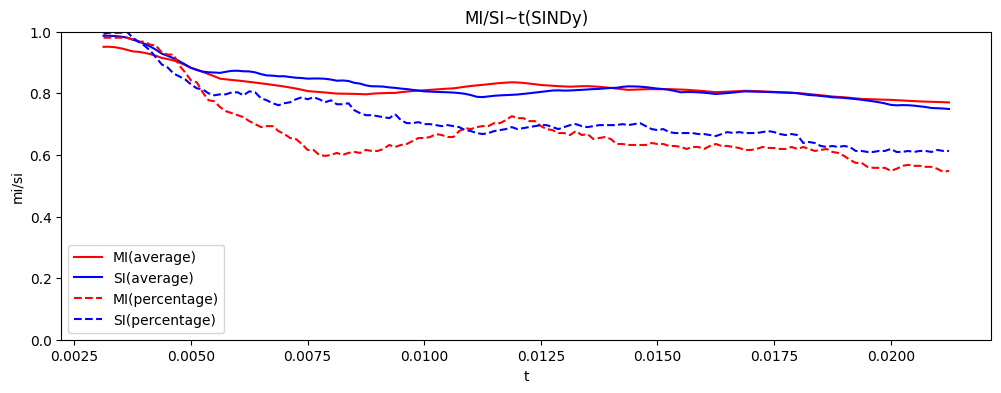

round: 6
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -409.030 1 + -32.545 Vx + 136.427 Vy + 70864.137 t + 5.086 VxVx + 18.890 VyVy + -2619047.215 tt + -22.413 VxVy + 2867.828 Vxt + -3097.022 Vyt + -1.904 VxVxVy + -579.962 VxVxt + -1490.442 VyVyt + 1400.292 VxVyt + -4.374 Vx_2 + -826.724 Vy_2 + -551.782 Vx_1 + -131.673 Vy_1 + -64.264 VxVx_2 + -483.563 VxVy_2 + -13403.787 Vxt_2 + -2.317 VyVx_2 + -45.402 VyVy_2 + 796574.437 Vyt_2 + 13.984 tVx_2 + 5456.661 tVy_2 + 20808.197 tt_2 + -0.076 VxVxVx_2 + 105.241 VxVxVy_2 + 4238.531 VxVxt_2 + -782.243 VyVyVx_2 + 422.683 VyVyVy_2 + 2.571 VyVyt_2 + 136271.315 ttVx_2 + -45.424 ttVy_2 + -7.498 ttt_2 + -4859007.261 VxVyVx_2 + 67.776 VxVyVy_2 + -16305.752 VxVyt_2 + -1390.607 VxtVx_2 + -2.759 VxtVy_2 + 3056.041 Vxtt_2 + 301.917 VytVx_2 + -4581.184 VytVy_2 + 29.524 VxVx_1 + 91.926 VxVy_1 + 69581.364 Vxt_1 + -3.080 VyVx_1 + 6.553 VyVy_1 + -2157572.863 Vyt_1 + 47.091 tVx_1 + -2207.577 tVy_1 + -13167.332 tt_1 + -0.004 VxVxVx_1 + 256.964 VxVxVy_1 + -2269.239 VxVxt

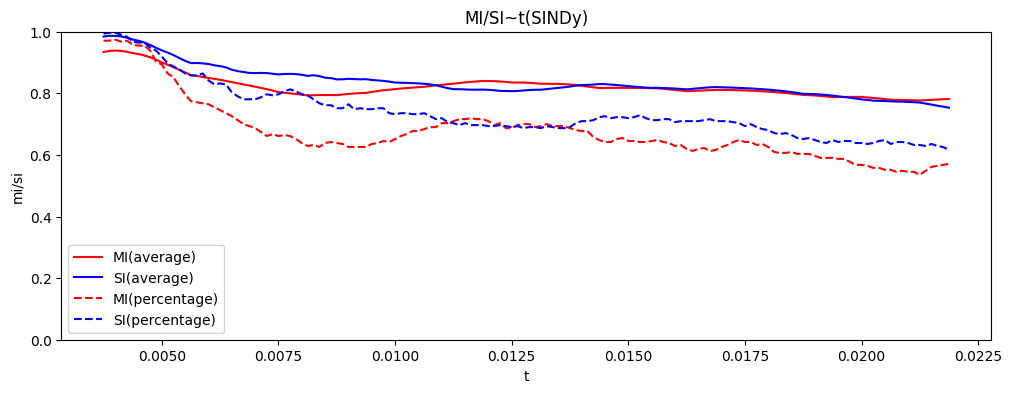

round: 7
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -343.815 1 + -7.032 Vx + 151.511 Vy + 55875.920 t + 11.795 VxVx + 22.929 VyVy + -1948630.535 tt + -16.722 VxVy + 1232.241 Vxt + -4124.900 Vyt + -1.536 VxVxVy + -1000.326 VxVxt + -1774.709 VyVyt + 917.899 VxVyt + 219.157 Vx_2 + -729.011 Vy_2 + -488.509 Vx_1 + -308.491 Vy_1 + -51.095 VxVx_2 + -568.716 VxVy_2 + -45265.095 Vxt_2 + -5.571 VyVx_2 + -50.767 VyVy_2 + 1830377.317 Vyt_2 + 14.303 tVx_2 + 3968.833 tVy_2 + 26368.303 tt_2 + 1.475 VxVxVx_2 + 436.718 VxVxVy_2 + 4682.206 VxVxt_2 + -1019.821 VyVyVx_2 + 454.827 VyVyVy_2 + 25.948 VyVyt_2 + 122236.549 ttVx_2 + -48.737 ttVy_2 + 4.131 ttt_2 + -4392613.424 VxVyVx_2 + 81.072 VxVyVy_2 + -17972.186 VxVyt_2 + -3130.018 VxtVx_2 + -2.750 VxtVy_2 + 2953.243 Vxtt_2 + -407.361 VytVx_2 + -5423.205 VytVy_2 + 28.143 VxVx_1 + 139.493 VxVy_1 + 63439.023 Vxt_1 + -5.910 VyVx_1 + 5.235 VyVy_1 + -2026530.957 Vyt_1 + 50.573 tVx_1 + -2077.054 tVy_1 + -17316.942 tt_1 + 0.445 VxVxVx_1 + 372.279 VxVxVy_1 + -2122.171 Vx

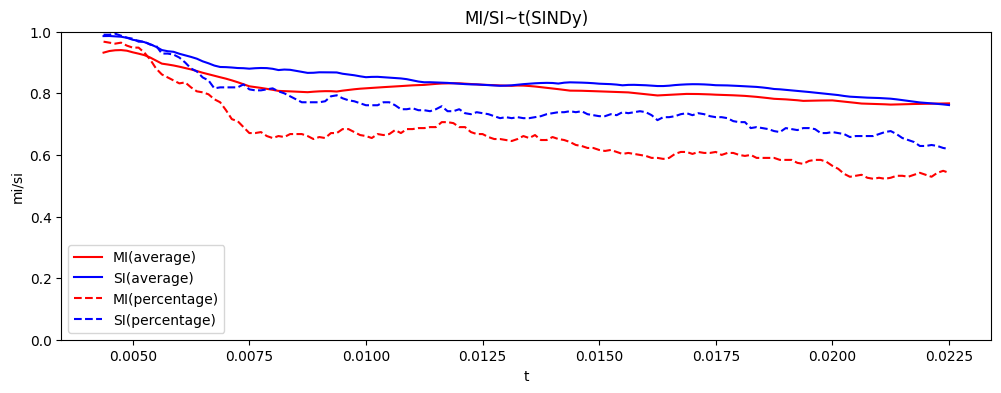

round: 8
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -212.273 1 + 44.513 Vx + 65.855 Vy + 29927.040 t + 12.114 VxVx + 10.918 VyVy + -916310.303 tt + -6.933 VxVy + -2667.317 Vxt + 1097.197 Vyt + 0.533 VxVxVy + -783.968 VxVxt + -1084.094 VyVyt + -238.406 VxVyt + 27.558 Vx_2 + -813.485 Vy_2 + -306.757 Vx_1 + -317.299 Vy_1 + -54.486 VxVx_2 + -543.372 VxVy_2 + -16444.552 Vxt_2 + -6.667 VyVx_2 + -43.343 VyVy_2 + 838899.697 Vyt_2 + 15.368 tVx_2 + 4160.607 tVy_2 + 25742.414 tt_2 + 0.954 VxVxVx_2 + 461.602 VxVxVy_2 + 4482.797 VxVxt_2 + -733.872 VyVyVx_2 + 462.177 VyVyVy_2 + 82.990 VyVyt_2 + 128119.544 ttVx_2 + -44.760 ttVy_2 + 15.836 ttt_2 + -4424971.109 VxVyVx_2 + 77.251 VxVyVy_2 + -18448.453 VxVyt_2 + -6878.383 VxtVx_2 + -2.504 VxtVy_2 + 2426.512 Vxtt_2 + -1244.424 VytVx_2 + -5542.536 VytVy_2 + 21.112 VxVx_1 + 143.773 VxVy_1 + 34456.774 Vxt_1 + -8.003 VyVx_1 + 8.099 VyVy_1 + -975563.186 Vyt_1 + 67.779 tVx_1 + -1063.601 tVy_1 + -19547.212 tt_1 + -1.124 VxVxVx_1 + 330.852 VxVxVy_1 + -2364.009 VxVxt_1

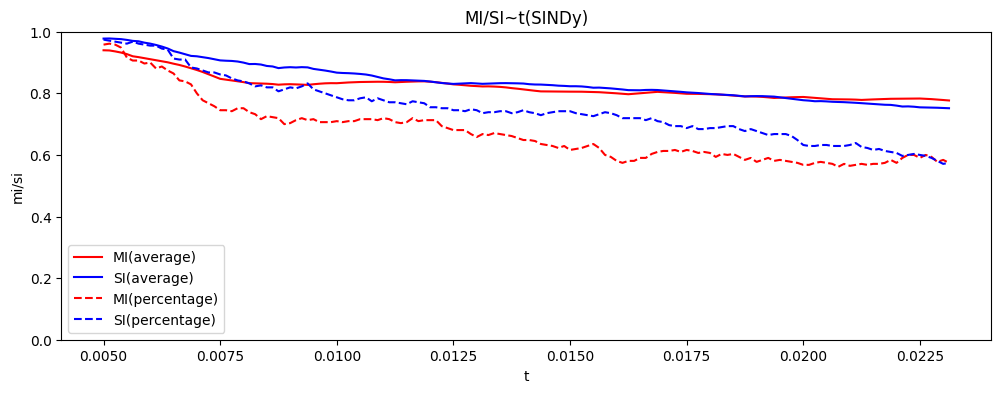

round: 9
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -210.038 1 + 93.404 Vx + 70.951 Vy + 27723.295 t + 21.696 VxVx + 5.408 VyVy + -793014.268 tt + 4.992 VxVy + -5582.044 Vxt + 546.368 Vyt + 0.006 VxVxVy + -1358.741 VxVxt + -786.059 VyVyt + -892.516 VxVyt + -144.157 Vx_2 + -801.375 Vy_2 + -244.886 Vx_1 + -256.828 Vy_1 + -50.681 VxVx_2 + -556.458 VxVy_2 + 8198.487 Vxt_2 + -9.553 VyVx_2 + -33.916 VyVy_2 + 23054.944 Vyt_2 + 3.710 tVx_2 + 3716.624 tVy_2 + 26170.045 tt_2 + 2.362 VxVxVx_2 + 698.607 VxVxVy_2 + 3832.734 VxVxt_2 + 5.379 VyVyVx_2 + 455.319 VyVyVy_2 + 62.750 VyVyt_2 + 119887.482 ttVx_2 + -27.883 ttVy_2 + 20.389 ttt_2 + -3962407.509 VxVyVx_2 + 82.289 VxVyVy_2 + -18250.373 VxVyt_2 + -6026.525 VxtVx_2 + -2.231 VxtVy_2 + 1214.698 Vxtt_2 + -1498.735 VytVx_2 + -5740.280 VytVy_2 + -5.481 VxVx_1 + 56.897 VxVy_1 + 24985.532 Vxt_1 + -13.481 VyVx_1 + -11.206 VyVy_1 + -639576.102 Vyt_1 + 36.845 tVx_1 + 414.676 tVy_1 + -14591.123 tt_1 + 0.499 VxVxVx_1 + 722.033 VxVxVy_1 + -1287.962 VxVxt_1 + -1305.

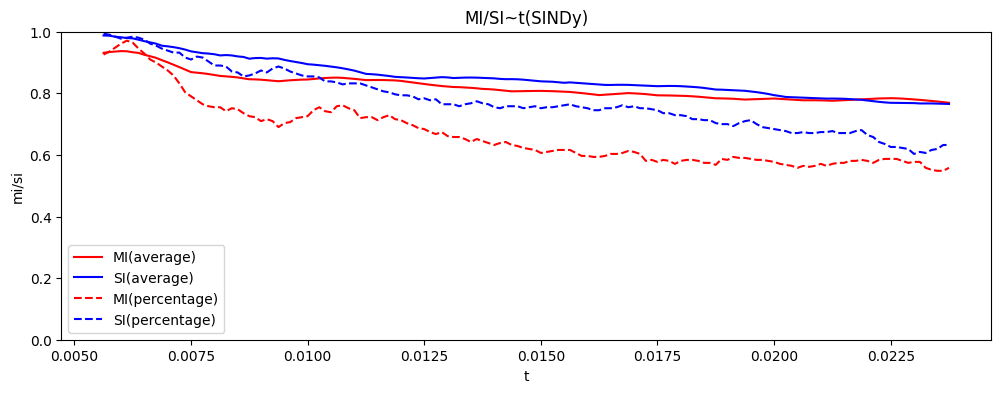

round: 10
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -38.150 1 + 114.637 Vx + 72.840 Vy + 3060.558 t + 28.726 VxVx + -0.937 VyVy + 5364.708 tt + 6.956 VxVy + -6583.520 Vxt + 179.445 Vyt + -1.109 VxVxVy + -1787.344 VxVxt + -444.349 VyVyt + -766.642 VxVyt + -150.778 Vx_2 + -348.530 Vy_2 + -192.243 Vx_1 + -379.867 Vy_1 + -55.369 VxVx_2 + -524.359 VxVy_2 + 10414.579 Vxt_2 + -8.955 VyVx_2 + -37.828 VyVy_2 + -75640.660 Vyt_2 + -13.409 tVx_2 + 4084.797 tVy_2 + 25663.872 tt_2 + 0.992 VxVxVx_2 + 644.378 VxVxVy_2 + 4237.461 VxVxt_2 + 1157.629 VyVyVx_2 + 445.599 VyVyVy_2 + 149.792 VyVyt_2 + 58271.388 ttVx_2 + -18.611 ttVy_2 + 29.644 ttt_2 + -2009829.474 VxVyVx_2 + 78.558 VxVyVy_2 + -17913.652 VxVyt_2 + -10978.183 VxtVx_2 + -3.918 VxtVy_2 + 336.906 Vxtt_2 + -2055.689 VytVx_2 + -5543.410 VytVy_2 + -25.094 VxVx_1 + -73.746 VxVy_1 + 15648.708 Vxt_1 + -9.654 VyVx_1 + -41.264 VyVy_1 + -291596.350 Vyt_1 + 52.859 tVx_1 + 1817.635 tVy_1 + -6193.231 tt_1 + -2.553 VxVxVx_1 + 432.634 VxVxVy_1 + 435.736 VxVxt_1 + 

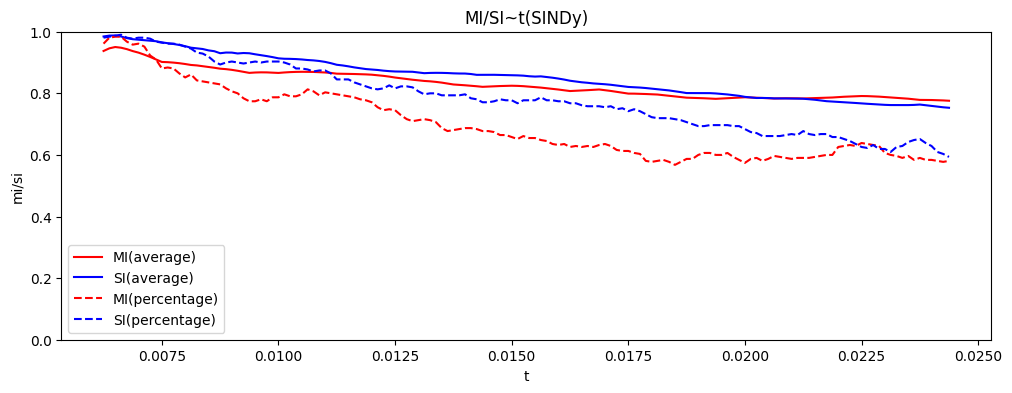

round: 11
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -39.556 1 + 90.351 Vx + 69.311 Vy + 4233.303 t + 27.069 VxVx + 1.559 VyVy + -65850.538 tt + 10.443 VxVy + -5081.980 Vxt + -158.860 Vyt + -1.915 VxVxVy + -1765.773 VxVxt + -653.117 VyVyt + -845.092 VxVyt + -343.653 Vx_2 + -181.372 Vy_2 + -245.558 Vx_1 + -180.102 Vy_1 + -76.923 VxVx_2 + -435.874 VxVy_2 + 38608.655 Vxt_2 + -10.776 VyVx_2 + -17.671 VyVy_2 + -1036551.648 Vyt_2 + -40.216 tVx_2 + 5285.458 tVy_2 + 21068.674 tt_2 + 1.377 VxVxVx_2 + 731.618 VxVxVy_2 + 3165.424 VxVxt_2 + 2647.006 VyVyVx_2 + 415.932 VyVyVy_2 + 190.645 VyVyt_2 + 29649.805 ttVx_2 + 16.209 ttVy_2 + 39.034 ttt_2 + -944652.189 VxVyVx_2 + 71.709 VxVyVy_2 + -17610.567 VxVyt_2 + -12958.067 VxtVx_2 + -3.541 VxtVy_2 + -1534.338 Vxtt_2 + -2530.181 VytVx_2 + -5254.344 VytVy_2 + -35.531 VxVx_1 + -51.960 VxVy_1 + 21303.020 Vxt_1 + -4.058 VyVx_1 + -30.904 VyVy_1 + -417107.347 Vyt_1 + 53.504 tVx_1 + 2112.360 tVy_1 + -5925.747 tt_1 + -2.112 VxVxVx_1 + 126.736 VxVxVy_1 + 17.698 VxVxt_

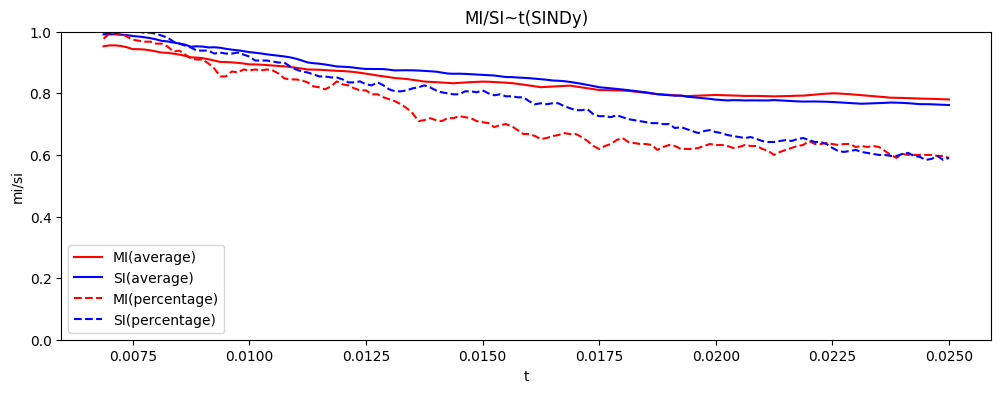

round: 12
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 81.474 1 + 139.257 Vx + 84.946 Vy + -10828.521 t + 33.502 VxVx + -1.343 VyVy + 370830.620 tt + 11.268 VxVy + -8003.111 Vxt + -284.839 Vyt + -1.406 VxVxVy + -2073.341 VxVxt + -416.787 VyVyt + -1086.395 VxVyt + -367.517 Vx_2 + 98.073 Vy_2 + -68.257 Vx_1 + -359.074 Vy_1 + -69.315 VxVx_2 + -431.089 VxVy_2 + 40547.047 Vxt_2 + -9.105 VyVx_2 + -8.159 VyVy_2 + -1065362.457 Vyt_2 + -39.325 tVx_2 + 4825.462 tVy_2 + 19782.359 tt_2 + 2.104 VxVxVx_2 + 688.156 VxVxVy_2 + 2465.832 VxVxt_2 + 2560.835 VyVyVx_2 + 407.124 VyVyVy_2 + 218.169 VyVyt_2 + -6453.188 ttVx_2 + 16.433 ttVy_2 + 34.543 ttt_2 + 150630.116 VxVyVx_2 + 46.608 VxVyVy_2 + -16218.734 VxVyt_2 + -14291.030 VxtVx_2 + -3.593 VxtVy_2 + -1703.682 Vxtt_2 + -2298.273 VytVx_2 + -3857.294 VytVy_2 + -48.162 VxVx_1 + -180.079 VxVy_1 + -3630.703 Vxt_1 + -0.826 VyVx_1 + -63.375 VyVy_1 + 384202.370 Vyt_1 + 15.418 tVx_1 + 2450.090 tVy_1 + 1085.303 tt_1 + -1.400 VxVxVx_1 + -10.039 VxVxVy_1 + 1800.682 VxVxt_1

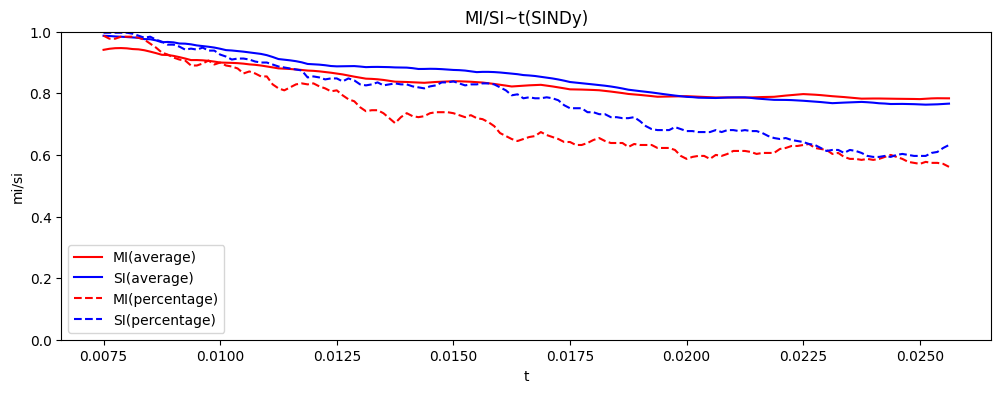

round: 13
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 121.365 1 + 141.303 Vx + 95.184 Vy + -13601.486 t + 34.833 VxVx + -2.847 VyVy + 390193.088 tt + 5.196 VxVy + -7839.439 Vxt + -1336.929 Vyt + -1.226 VxVxVy + -2134.710 VxVxt + -377.111 VyVyt + -647.222 VxVyt + -385.206 Vx_2 + 269.322 Vy_2 + -181.154 Vx_1 + -595.880 Vy_1 + -69.333 VxVx_2 + -420.949 VxVy_2 + 43711.248 Vxt_2 + -9.103 VyVx_2 + 1.194 VyVy_2 + -1189280.752 Vyt_2 + -42.871 tVx_2 + 4771.563 tVy_2 + 19030.438 tt_2 + 2.919 VxVxVx_2 + 732.848 VxVxVy_2 + 1916.608 VxVxt_2 + 2618.929 VyVyVx_2 + 464.666 VyVyVy_2 + 204.278 VyVyt_2 + -22149.257 ttVx_2 + 5.649 ttVy_2 + 37.446 ttt_2 + 478099.982 VxVyVx_2 + 65.014 VxVyVy_2 + -19103.687 VxVyt_2 + -13428.830 VxtVx_2 + -5.571 VxtVy_2 + -1234.723 Vxtt_2 + -2377.658 VytVx_2 + -4418.893 VytVy_2 + -53.891 VxVx_1 + -249.171 VxVy_1 + 11319.763 Vxt_1 + -0.444 VyVx_1 + -74.091 VyVy_1 + -92885.203 Vyt_1 + 4.847 tVx_1 + 2471.082 tVy_1 + 5402.543 tt_1 + -1.158 VxVxVx_1 + 12.308 VxVxVy_1 + 2415.399 VxVxt_1 

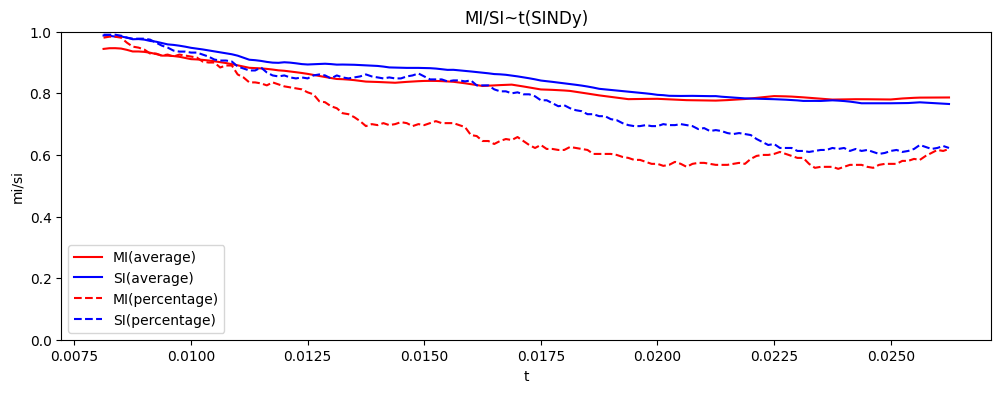

round: 14
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 254.773 1 + 114.911 Vx + 28.045 Vy + -28130.553 t + 28.716 VxVx + -13.655 VyVy + 746891.221 tt + 11.896 VxVy + -6359.534 Vxt + 2041.459 Vyt + -0.834 VxVxVy + -1743.810 VxVxt + 222.887 VyVyt + -1036.069 VxVyt + -336.753 Vx_2 + 277.648 Vy_2 + -132.363 Vx_1 + -602.488 Vy_1 + -84.411 VxVx_2 + -239.942 VxVy_2 + 40755.710 Vxt_2 + -8.292 VyVx_2 + 35.883 VyVy_2 + -1182760.620 Vyt_2 + -68.479 tVx_2 + 5461.942 tVy_2 + 10061.326 tt_2 + 2.863 VxVxVx_2 + 712.945 VxVxVy_2 + 147.118 VxVxt_2 + 3927.208 VyVyVx_2 + 334.418 VyVyVy_2 + 226.013 VyVyt_2 + -27731.713 ttVx_2 + 37.316 ttVy_2 + 38.374 ttt_2 + 744186.385 VxVyVx_2 + 26.367 VxVyVy_2 + -13152.989 VxVyt_2 + -14516.864 VxtVx_2 + -3.574 VxtVy_2 + -2769.767 Vxtt_2 + -2448.927 VytVx_2 + -2836.091 VytVy_2 + -82.996 VxVx_1 + -250.128 VxVy_1 + 3757.155 Vxt_1 + 9.435 VyVx_1 + -84.520 VyVy_1 + 165645.585 Vyt_1 + -0.254 tVx_1 + 3651.125 tVy_1 + 5504.493 tt_1 + 0.186 VxVxVx_1 + -483.105 VxVxVy_1 + 3046.842 VxVxt_

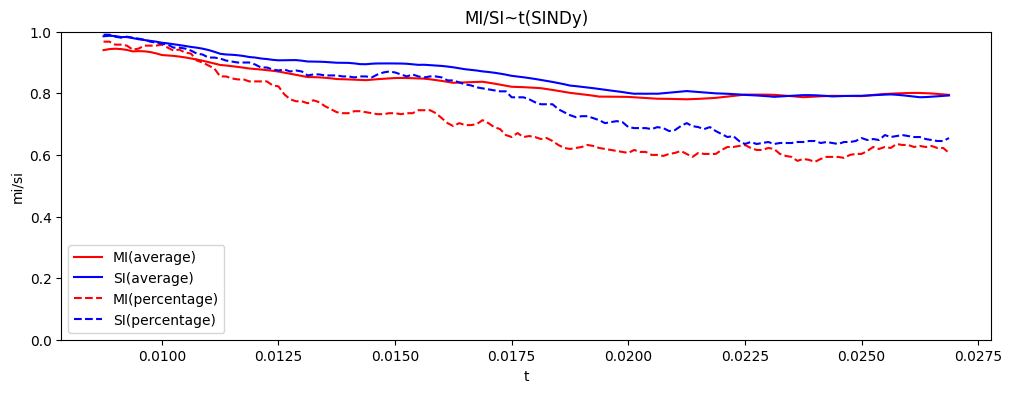

round: 15
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 271.996 1 + 96.007 Vx + 18.187 Vy + -27907.064 t + 29.785 VxVx + -16.885 VyVy + 680416.613 tt + 1.578 VxVy + -5473.512 Vxt + 1979.591 Vyt + 0.055 VxVxVy + -1764.081 VxVxt + 407.888 VyVyt + -474.408 VxVyt + -382.126 Vx_2 + 287.347 Vy_2 + -161.445 Vx_1 + -415.817 Vy_1 + -100.885 VxVx_2 + -91.251 VxVy_2 + 47847.105 Vxt_2 + -4.961 VyVx_2 + 66.611 VyVy_2 + -1422332.397 Vyt_2 + -44.793 tVx_2 + 6365.364 tVy_2 + 1530.422 tt_2 + 2.102 VxVxVx_2 + 536.694 VxVxVy_2 + -1776.861 VxVxt_2 + 2458.355 VyVyVx_2 + 255.047 VyVyVy_2 + 204.693 VyVyt_2 + -29156.708 ttVx_2 + 27.059 ttVy_2 + 30.493 ttt_2 + 790128.178 VxVyVx_2 + -8.356 VxVyVy_2 + -7953.698 VxVyt_2 + -13085.394 VxtVx_2 + -3.308 VxtVy_2 + -1957.279 Vxtt_2 + -1957.215 VytVx_2 + -615.129 VytVy_2 + -19.343 VxVx_1 + -300.757 VxVy_1 + 6364.373 Vxt_1 + 3.795 VyVx_1 + -83.112 VyVy_1 + 127849.328 Vyt_1 + 22.586 tVx_1 + 264.739 tVy_1 + 9373.883 tt_1 + -255.120 VxVxVy_1 + 3163.454 VxVxt_1 + -716.282 VyVyVx_1 +

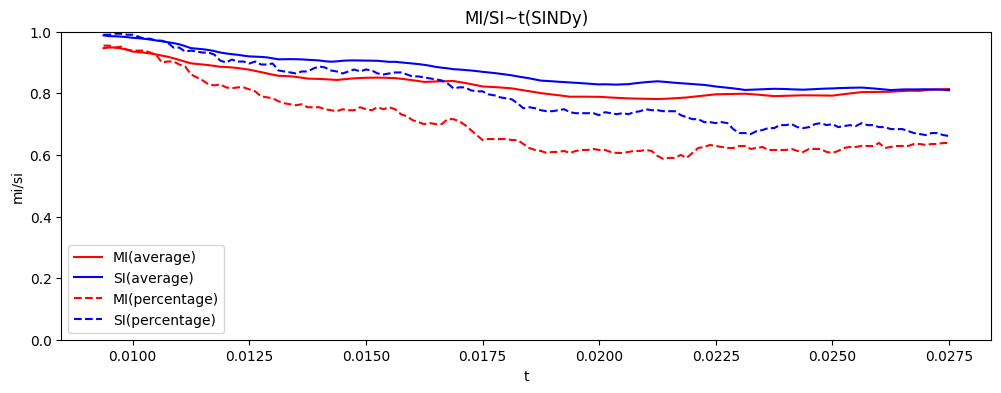

round: 16
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 337.765 1 + 88.770 Vx + 57.164 Vy + -33106.088 t + 27.972 VxVx + -11.385 VyVy + 765959.605 tt + -6.669 VxVy + -4832.552 Vxt + -551.387 Vyt + -0.887 VxVxVy + -1721.572 VxVxt + 66.230 VyVyt + 261.561 VxVyt + -349.669 Vx_2 + 223.557 Vy_2 + 59.875 Vx_1 + -467.937 Vy_1 + -92.308 VxVx_2 + -30.621 VxVy_2 + 47083.557 Vxt_2 + -6.088 VyVx_2 + 67.012 VyVy_2 + -1457899.228 Vyt_2 + -24.642 tVx_2 + 5657.326 tVy_2 + -1309.920 tt_2 + 1.703 VxVxVx_2 + 590.903 VxVxVy_2 + -1847.700 VxVxt_2 + 1097.083 VyVyVx_2 + 291.986 VyVyVy_2 + 170.616 VyVyt_2 + -24581.758 ttVx_2 + 6.458 ttVy_2 + 29.840 ttt_2 + 728111.528 VxVyVx_2 + 14.136 VxVyVy_2 + -9466.608 VxVyt_2 + -11184.381 VxtVx_2 + -5.788 VxtVy_2 + -853.260 Vxtt_2 + -1885.163 VytVx_2 + -1313.906 VytVy_2 + 31.272 VxVx_1 + -398.002 VxVy_1 + -19405.347 Vxt_1 + -1.523 VyVx_1 + -92.371 VyVy_1 + 818811.424 Vyt_1 + 51.333 tVx_1 + -1884.868 tVy_1 + 15260.486 tt_1 + -1.949 VxVxVx_1 + -102.388 VxVxVy_1 + 3738.301 VxVxt_1 +

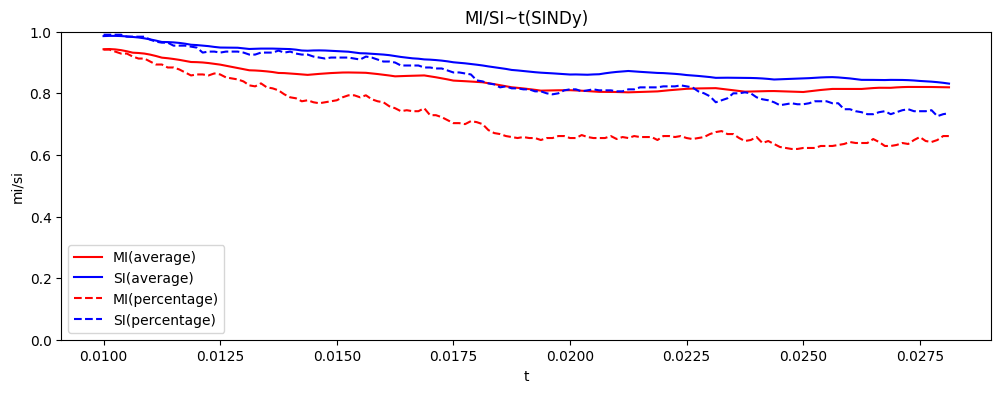

round: 17
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 400.733 1 + 38.690 Vx + 91.886 Vy + -37107.076 t + 31.133 VxVx + -16.784 VyVy + 804989.789 tt + -35.680 VxVy + -2486.055 Vxt + -2408.041 Vyt + 0.491 VxVxVy + -1836.984 VxVxt + 358.383 VyVyt + 1503.310 VxVyt + -432.593 Vx_2 + 255.907 Vy_2 + -24.113 Vx_1 + -440.212 Vy_1 + -94.294 VxVx_2 + 63.796 VxVy_2 + 58324.349 Vxt_2 + -6.056 VyVx_2 + 80.936 VyVy_2 + -1779603.716 Vyt_2 + -31.687 tVx_2 + 5555.872 tVy_2 + -6879.573 tt_2 + 2.028 VxVxVx_2 + 601.826 VxVxVy_2 + -2914.608 VxVxt_2 + 1203.428 VyVyVx_2 + 278.682 VyVyVy_2 + 160.371 VyVyt_2 + -26086.076 ttVx_2 + 4.598 ttVy_2 + 21.455 ttt_2 + 720470.516 VxVyVx_2 + 11.376 VxVyVy_2 + -7159.076 VxVyt_2 + -10247.964 VxtVx_2 + -6.943 VxtVy_2 + -910.363 Vxtt_2 + -1393.134 VytVx_2 + -706.023 VytVy_2 + 49.267 VxVx_1 + -412.714 VxVy_1 + -7896.034 Vxt_1 + -0.210 VyVx_1 + -93.352 VyVy_1 + 467502.858 Vyt_1 + 82.461 tVx_1 + -2808.666 tVy_1 + 17824.122 tt_1 + -4.133 VxVxVx_1 + -246.216 VxVxVy_1 + 4080.190 VxVxt_1 

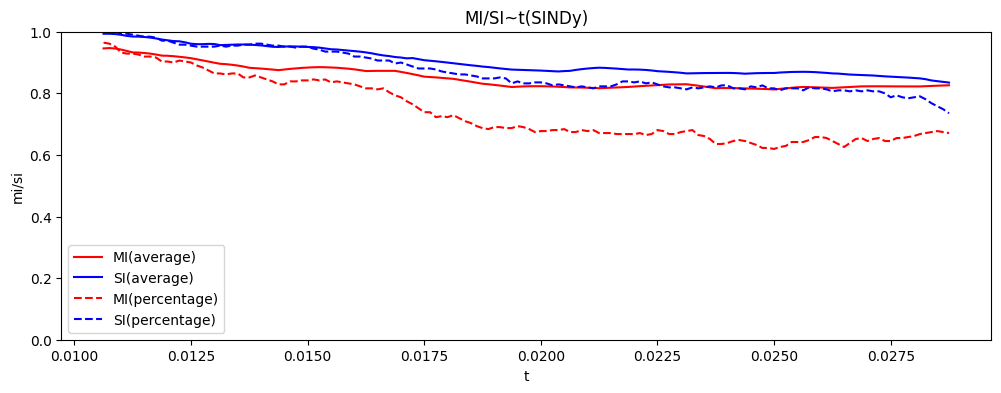

round: 18
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 519.632 1 + 30.008 Vx + 91.283 Vy + -47887.433 t + 28.783 VxVx + -23.310 VyVy + 1030534.623 tt + -34.645 VxVy + -2062.618 Vxt + -2443.372 Vyt + 0.485 VxVxVy + -1671.811 VxVxt + 688.088 VyVyt + 1339.975 VxVyt + -263.091 Vx_2 + 41.836 Vy_2 + -87.899 Vx_1 + -422.290 Vy_1 + -77.344 VxVx_2 + 124.429 VxVy_2 + 40722.900 Vxt_2 + -7.265 VyVx_2 + 103.106 VyVy_2 + -1346785.237 Vyt_2 + -17.326 tVx_2 + 4821.284 tVy_2 + -10609.573 tt_2 + 1.961 VxVxVx_2 + 637.966 VxVxVy_2 + -4181.834 VxVxt_2 + 590.725 VyVyVx_2 + 189.971 VyVyVy_2 + 152.863 VyVyt_2 + -5226.919 ttVx_2 + 4.836 ttVy_2 + 16.750 ttt_2 + 232711.919 VxVyVx_2 + -18.671 VxVyVy_2 + -2634.289 VxVyt_2 + -9403.238 VxtVx_2 + -6.714 VxtVy_2 + -852.751 Vxtt_2 + -1106.494 VytVx_2 + 935.110 VytVy_2 + 29.194 VxVx_1 + -417.104 VxVy_1 + -920.785 Vxt_1 + 1.800 VyVx_1 + -104.846 VyVy_1 + 289769.925 Vyt_1 + 79.507 tVx_1 + -1680.560 tVy_1 + 18192.217 tt_1 + -4.656 VxVxVx_1 + -302.744 VxVxVy_1 + 4726.081 VxVxt_1 +

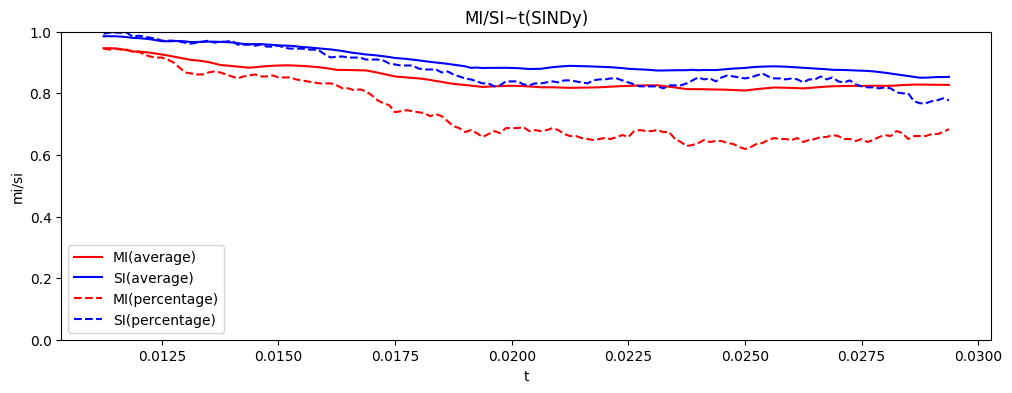

round: 19
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 464.111 1 + 42.126 Vx + 133.943 Vy + -40640.598 t + 26.577 VxVx + -21.860 VyVy + 817022.427 tt + -42.059 VxVy + -2858.001 Vxt + -4473.826 Vyt + 1.008 VxVxVy + -1516.510 VxVxt + 590.230 VyVyt + 1554.288 VxVyt + -486.479 Vx_2 + 108.200 Vy_2 + -75.687 Vx_1 + -391.209 Vy_1 + -28.670 VxVx_2 + 123.109 VxVy_2 + 62503.727 Vxt_2 + -7.970 VyVx_2 + 111.414 VyVy_2 + -1846719.059 Vyt_2 + 3.195 tVx_2 + 2286.783 tVy_2 + -10791.429 tt_2 + 1.808 VxVxVx_2 + 590.277 VxVxVy_2 + -4629.911 VxVxt_2 + -523.166 VyVyVx_2 + 210.718 VyVyVy_2 + 78.347 VyVyt_2 + -11935.062 ttVx_2 + -12.408 ttVy_2 + 1.329 ttt_2 + 378606.233 VxVyVx_2 + -37.901 VxVyVy_2 + -3942.666 VxVyt_2 + -5214.938 VxtVx_2 + -5.007 VxtVy_2 + 269.856 Vxtt_2 + -295.232 VytVx_2 + 1616.220 VytVy_2 + 23.972 VxVx_1 + -452.737 VxVy_1 + 277.039 Vxt_1 + 4.442 VyVx_1 + -125.078 VyVy_1 + 207570.203 Vyt_1 + 68.822 tVx_1 + -1785.849 tVy_1 + 20807.870 tt_1 + -4.453 VxVxVx_1 + -390.784 VxVxVy_1 + 5824.538 VxVxt_1 + 

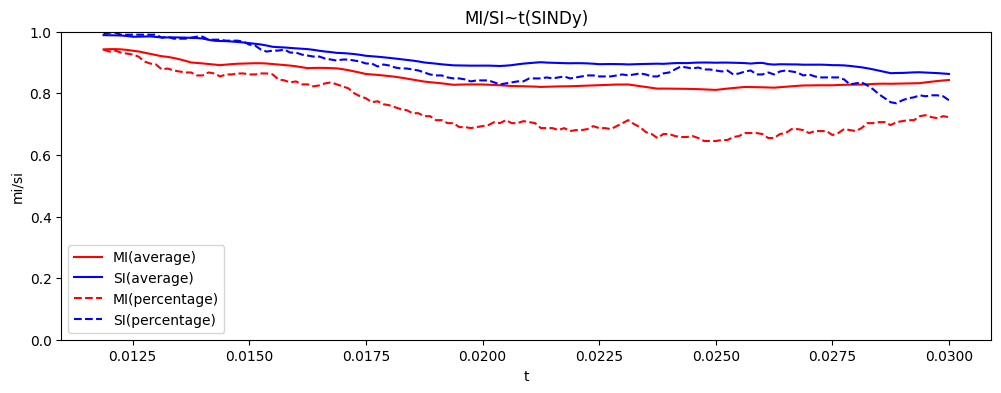

round: 20
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 589.072 1 + 28.543 Vx + 66.319 Vy + -50902.762 t + 18.950 VxVx + -35.835 VyVy + 1013591.612 tt + -51.790 VxVy + -2333.331 Vxt + -1020.772 Vyt + 1.701 VxVxVy + -1129.773 VxVxt + 1219.939 VyVyt + 1805.793 VxVyt + -171.957 Vx_2 + -105.635 Vy_2 + -423.546 Vx_1 + -487.289 Vy_1 + -26.489 VxVx_2 + 246.501 VxVy_2 + 31065.056 Vxt_2 + -10.553 VyVx_2 + 129.740 VyVy_2 + -1088015.663 Vyt_2 + 17.454 tVx_2 + 2232.322 tVy_2 + -16086.774 tt_2 + 1.750 VxVxVx_2 + 666.115 VxVxVy_2 + -5281.180 VxVxt_2 + -1215.116 VyVyVx_2 + 59.495 VyVyVy_2 + 39.590 VyVyt_2 + 11180.967 ttVx_2 + -32.924 ttVy_2 + -5.302 ttt_2 + -234407.464 VxVyVx_2 + -87.481 VxVyVy_2 + 2215.444 VxVyt_2 + -3186.050 VxtVx_2 + -2.494 VxtVy_2 + 1570.337 Vxtt_2 + 9.659 VytVx_2 + 3417.851 VytVy_2 + 39.851 VxVx_1 + -421.901 VxVy_1 + 37469.194 Vxt_1 + 2.260 VyVx_1 + -135.911 VyVy_1 + -719439.975 Vyt_1 + 47.008 tVx_1 + -2881.255 tVy_1 + 18886.416 tt_1 + -3.585 VxVxVx_1 + -294.167 VxVxVy_1 + 6342.974 VxVx

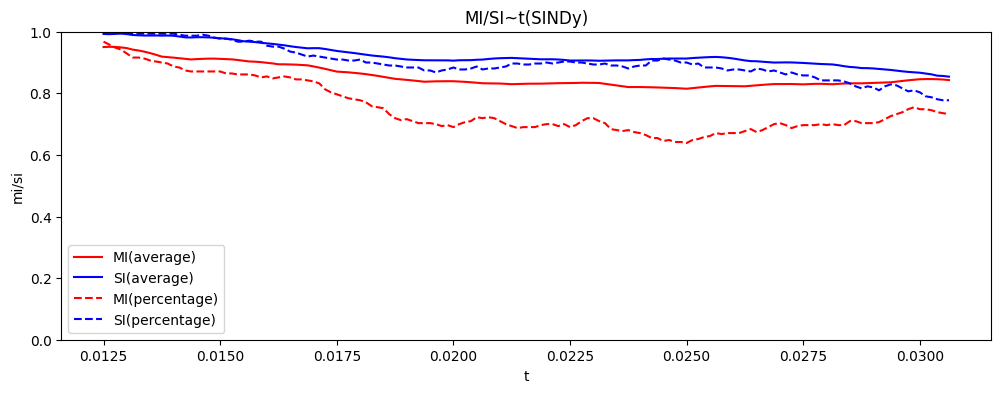

round: 21
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 469.816 1 + 36.758 Vx + 82.778 Vy + -39253.901 t + 4.453 VxVx + -40.832 VyVy + 741152.201 tt + -49.158 VxVy + -2608.393 Vxt + -1348.715 Vyt + 0.415 VxVxVy + -452.683 VxVxt + 1440.635 VyVyt + 1710.794 VxVyt + 64.620 Vx_2 + -329.988 Vy_2 + -49.292 Vx_1 + -97.832 Vy_1 + -30.689 VxVx_2 + 210.920 VxVy_2 + 7387.973 Vxt_2 + -17.034 VyVx_2 + 148.541 VyVy_2 + -526514.331 Vyt_2 + 28.674 tVx_2 + 2361.217 tVy_2 + -14893.195 tt_2 + 2.848 VxVxVx_2 + 973.293 VxVxVy_2 + -6055.374 VxVxt_2 + -1604.429 VyVyVx_2 + 2.883 VyVyVy_2 + 72.708 VyVyt_2 + 31808.003 ttVx_2 + -43.514 ttVy_2 + -0.799 ttt_2 + -697478.922 VxVyVx_2 + -122.307 VxVyVy_2 + 4312.129 VxVyt_2 + -4805.143 VxtVx_2 + -1.226 VxtVy_2 + 2133.157 Vxtt_2 + -244.434 VytVx_2 + 4809.147 VytVy_2 + 3.516 VxVx_1 + -335.414 VxVy_1 + 4842.178 Vxt_1 + 1.456 VyVx_1 + -134.700 VyVy_1 + -36984.590 Vyt_1 + 39.762 tVx_1 + -1323.063 tVy_1 + 14985.139 tt_1 + -2.676 VxVxVx_1 + -193.412 VxVxVy_1 + 6239.273 VxVxt_1 + -14

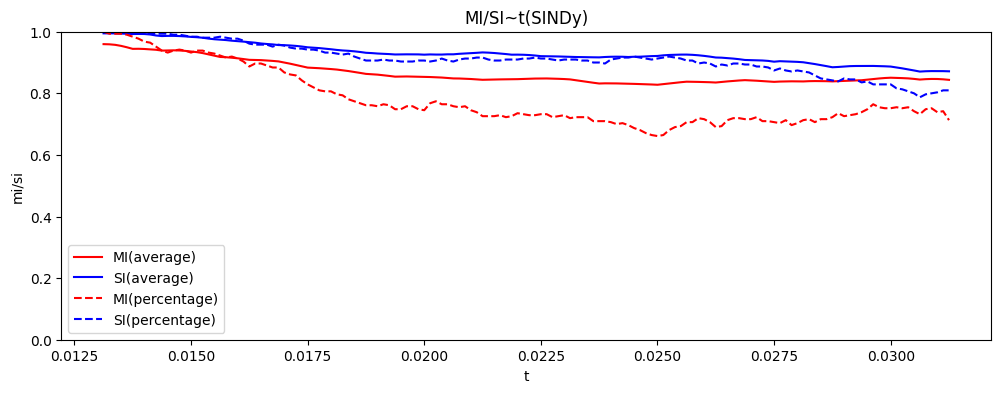

round: 22
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 311.092 1 + 55.989 Vx + 146.928 Vy + -23976.765 t + 8.730 VxVx + -41.444 VyVy + 392858.266 tt + -38.658 VxVy + -3627.005 Vxt + -3835.919 Vyt + -0.858 VxVxVy + -675.362 VxVxt + 1453.821 VyVyt + 1223.494 VxVyt + -57.683 Vx_2 + -1002.969 Vy_2 + -584.781 Vx_1 + -300.298 Vy_1 + -6.275 VxVx_2 + 63.310 VxVy_2 + 17301.624 Vxt_2 + -16.008 VyVx_2 + 145.930 VyVy_2 + -717321.256 Vyt_2 + 23.704 tVx_2 + 1308.508 tVy_2 + -9416.303 tt_2 + 4.472 VxVxVx_2 + 893.876 VxVxVy_2 + -5993.891 VxVxt_2 + -1301.624 VyVyVx_2 + 114.283 VyVyVy_2 + 92.971 VyVyt_2 + 89531.736 ttVx_2 + -29.192 ttVy_2 + 3.444 ttt_2 + -1881521.615 VxVyVx_2 + -112.778 VxVyVy_2 + -1079.772 VxVyt_2 + -5442.276 VxtVx_2 + -0.782 VxtVy_2 + 1549.450 Vxtt_2 + -393.866 VytVx_2 + 4417.417 VytVy_2 + 38.951 VxVx_1 + -341.972 VxVy_1 + 52405.734 Vxt_1 + 6.124 VyVx_1 + -120.038 VyVy_1 + -1045479.643 Vyt_1 + 42.562 tVx_1 + -2850.132 tVy_1 + 15147.474 tt_1 + -2.432 VxVxVx_1 + -411.431 VxVxVy_1 + 5483.053 Vx

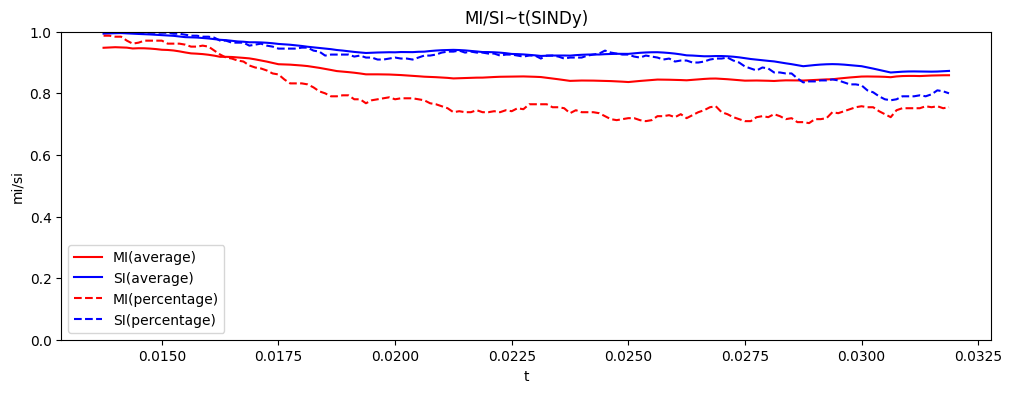

round: 23
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 348.282 1 + 45.850 Vx + 120.303 Vy + -27471.601 t + 0.317 VxVx + -44.460 VyVy + 470337.321 tt + -16.029 VxVy + -3158.206 Vxt + -1726.632 Vyt + -2.395 VxVxVy + -341.153 VxVxt + 1714.483 VyVyt + 256.731 VxVyt + -86.255 Vx_2 + -326.865 Vy_2 + -182.092 Vy_1 + 28.421 VxVx_2 + 88.121 VxVy_2 + 19416.981 Vxt_2 + -12.278 VyVx_2 + 144.980 VyVy_2 + -741609.851 Vyt_2 + 11.370 tVx_2 + -586.890 tVy_2 + -11926.165 tt_2 + 5.197 VxVxVx_2 + 623.800 VxVxVy_2 + -6179.709 VxVxt_2 + -873.692 VyVyVx_2 + -6.853 VyVyVy_2 + 63.908 VyVyt_2 + 30078.256 ttVx_2 + -31.637 ttVy_2 + 6.500 ttt_2 + -651263.341 VxVyVx_2 + -128.350 VxVyVy_2 + 5325.188 VxVyt_2 + -4213.494 VxtVx_2 + 1916.488 Vxtt_2 + -503.728 VytVx_2 + 5499.393 VytVy_2 + 32.259 VxVx_1 + -293.073 VxVy_1 + 2653.385 Vxt_1 + 1.228 VyVx_1 + -111.412 VyVy_1 + -55117.435 Vyt_1 + 27.150 tVx_1 + -2583.444 tVy_1 + 11884.651 tt_1 + -0.930 VxVxVx_1 + -138.958 VxVxVy_1 + 4934.896 VxVxt_1 + -592.810 VyVyVx_1 + 358.330 VyVyV

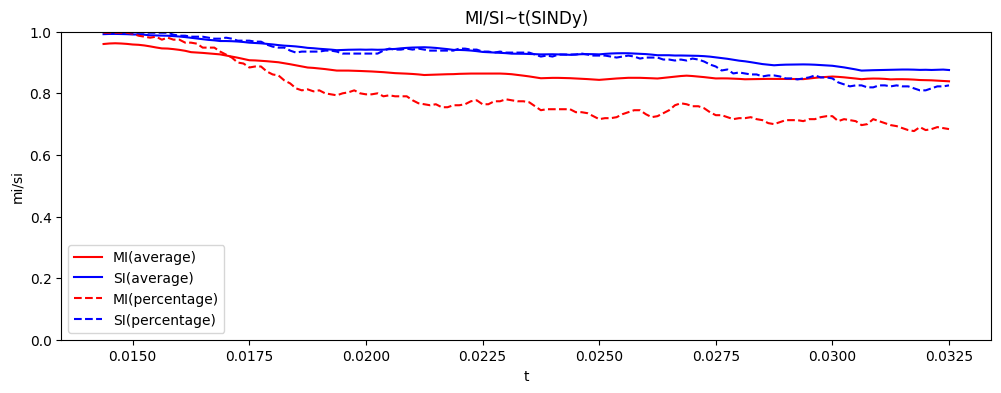

round: 24
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 263.364 1 + 43.390 Vx + 125.610 Vy + -19753.530 t + -13.199 VxVx + -45.738 VyVy + 308894.357 tt + -0.663 VxVy + -2940.677 Vxt + -2333.507 Vyt + -2.813 VxVxVy + 187.696 VxVxt + 1737.505 VyVyt + -317.761 VxVyt + 236.843 Vx_2 + -402.319 Vy_2 + -987.470 Vx_1 + -330.027 Vy_1 + -0.645 VxVx_2 + 48.038 VxVy_2 + -13051.936 Vxt_2 + -13.032 VyVx_2 + 143.565 VyVy_2 + 33857.473 Vyt_2 + 7.483 tVx_2 + 705.015 tVy_2 + -8818.393 tt_2 + 4.403 VxVxVx_2 + 659.206 VxVxVy_2 + -5944.992 VxVxt_2 + -588.056 VyVyVx_2 + 52.439 VyVyVy_2 + 2.652 VyVyt_2 + 40777.661 ttVx_2 + -24.516 ttVy_2 + 1.344 ttt_2 + -955403.155 VxVyVx_2 + -117.800 VxVyVy_2 + 1951.260 VxVyt_2 + -1928.616 VxtVx_2 + 0.154 VxtVy_2 + 1520.861 Vxtt_2 + -310.264 VytVx_2 + 5030.718 VytVy_2 + 31.710 VxVx_1 + -226.324 VxVy_1 + 86737.485 Vxt_1 + -3.189 VyVx_1 + -82.893 VyVy_1 + -1768763.811 Vyt_1 + 39.373 tVx_1 + -2267.446 tVy_1 + 8610.731 tt_1 + 50.154 VxVxVy_1 + 3527.654 VxVxt_1 + -1124.801 VyVyVx_1 + 23

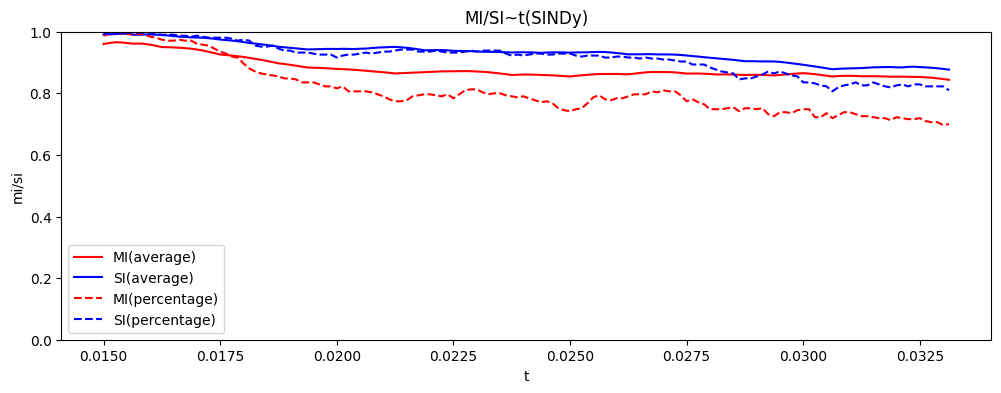

round: 25
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 140.985 1 + 52.180 Vx + 197.817 Vy + -8795.175 t + -17.213 VxVx + -30.308 VyVy + 73836.105 tt + 6.285 VxVy + -3309.221 Vxt + -5761.232 Vyt + -1.454 VxVxVy + 352.624 VxVxt + 993.196 VyVyt + -668.995 VxVyt + 123.883 Vx_2 + -98.318 Vy_2 + -1250.158 Vx_1 + -451.608 Vy_1 + -13.048 VxVx_2 + -49.699 VxVy_2 + -2665.821 Vxt_2 + -11.976 VyVx_2 + 119.951 VyVy_2 + -190424.741 Vyt_2 + -24.358 tVx_2 + 1264.947 tVy_2 + -3997.982 tt_2 + 4.433 VxVxVx_2 + 635.593 VxVxVy_2 + -4731.659 VxVxt_2 + 787.473 VyVyVx_2 + 161.039 VyVyVy_2 + 23.827 VyVyt_2 + 16091.918 ttVx_2 + -12.293 ttVy_2 + 8.193 ttt_2 + -474149.559 VxVyVx_2 + -101.378 VxVyVy_2 + -2413.547 VxVyt_2 + -3106.662 VxtVx_2 + -0.021 VxtVy_2 + 909.795 Vxtt_2 + -645.600 VytVx_2 + 4229.485 VytVy_2 + 36.423 VxVx_1 + -315.332 VxVy_1 + 107898.488 Vxt_1 + -9.336 VyVx_1 + -80.775 VyVy_1 + -2185857.935 Vyt_1 + 23.100 tVx_1 + -2307.973 tVy_1 + 11769.872 tt_1 + 1.095 VxVxVx_1 + 361.349 VxVxVy_1 + 3318.058 VxVxt_1 +

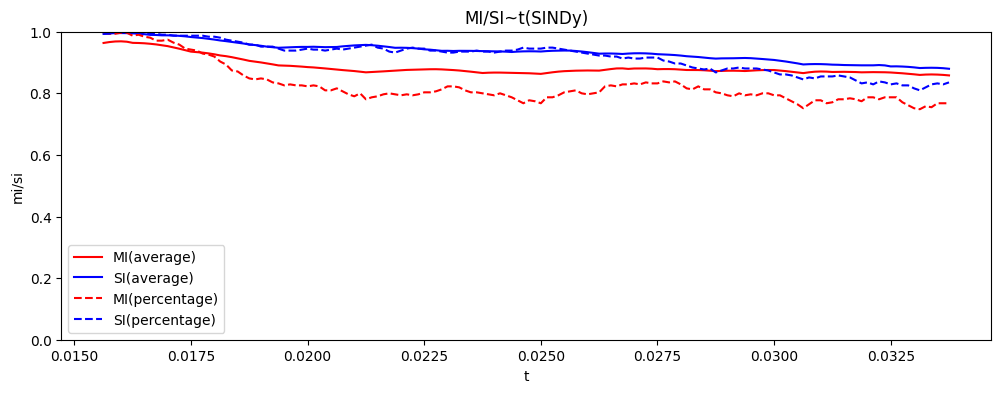

round: 26
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 293.833 1 + 37.118 Vx + 204.427 Vy + -22626.590 t + -25.839 VxVx + -31.229 VyVy + 377270.240 tt + 2.339 VxVy + -2470.963 Vxt + -5272.357 Vyt + -2.603 VxVxVy + 675.341 VxVxt + 1144.984 VyVyt + -470.360 VxVyt + 424.335 Vx_2 + 456.648 Vy_2 + -1273.397 Vx_1 + -612.461 Vy_1 + 6.270 VxVx_2 + -78.637 VxVy_2 + -30964.561 Vxt_2 + -7.135 VyVx_2 + 126.033 VyVy_2 + 445640.911 Vyt_2 + 2.998 tVx_2 + 379.615 tVy_2 + -3778.790 tt_2 + 4.876 VxVxVx_2 + 388.933 VxVxVy_2 + -5113.329 VxVxt_2 + -198.533 VyVyVx_2 + 153.126 VyVyVy_2 + -25.403 VyVyt_2 + -27365.848 ttVx_2 + -27.085 ttVy_2 + 0.272 ttt_2 + 346548.194 VxVyVx_2 + -122.438 VxVyVy_2 + -1972.793 VxVyt_2 + -1318.868 VxtVx_2 + -0.252 VxtVy_2 + 1469.960 Vxtt_2 + -342.079 VytVx_2 + 5214.460 VytVy_2 + 53.496 VxVx_1 + -440.817 VxVy_1 + 108586.284 Vxt_1 + -15.282 VyVx_1 + -84.611 VyVy_1 + -2175563.473 Vyt_1 + 9.314 tVx_1 + -2892.511 tVy_1 + 14604.343 tt_1 + 2.875 VxVxVx_1 + 547.312 VxVxVy_1 + 3175.942 VxVxt_1 +

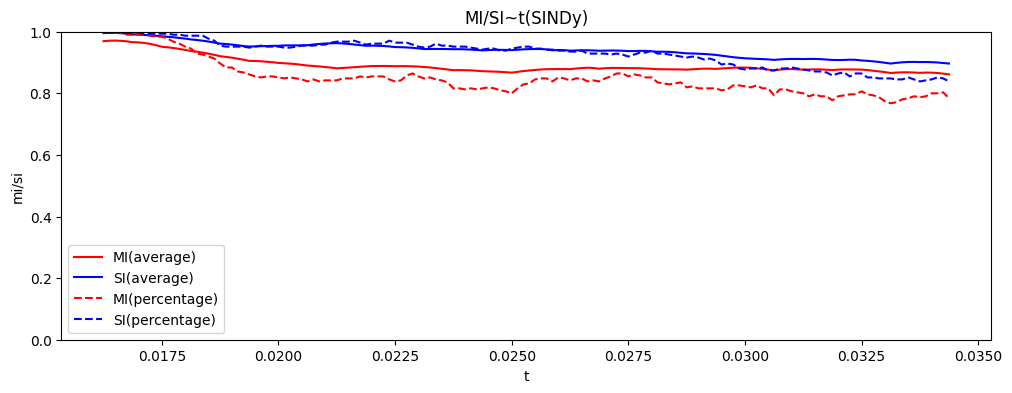

round: 27
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 309.210 1 + -29.201 Vx + 270.893 Vy + -22319.841 t + -22.449 VxVx + -15.305 VyVy + 348165.736 tt + -0.356 VxVy + -184.183 Vxt + -7798.392 Vyt + -2.686 VxVxVy + 495.959 VxVxt + 533.838 VyVyt + -442.403 VxVyt + 904.535 Vx_2 + 771.865 Vy_2 + -1052.050 Vx_1 + -588.171 Vy_1 + 65.495 VxVx_2 + -102.477 VxVy_2 + -70895.957 Vxt_2 + 2.410 VyVx_2 + 110.333 VyVy_2 + 1250321.360 Vyt_2 + 14.191 tVx_2 + -2028.042 tVy_2 + -2587.834 tt_2 + 3.770 VxVxVx_2 + -25.292 VxVxVy_2 + -4458.704 VxVxt_2 + -597.473 VyVyVx_2 + 250.428 VyVyVy_2 + -86.931 VyVyt_2 + -52543.695 ttVx_2 + -13.060 ttVy_2 + -9.199 ttt_2 + 837477.599 VxVyVx_2 + -110.104 VxVyVy_2 + -6027.606 VxVyt_2 + 519.005 VxtVx_2 + -0.385 VxtVy_2 + 737.073 Vxtt_2 + -62.308 VytVx_2 + 4618.536 VytVy_2 + 86.127 VxVx_1 + -341.246 VxVy_1 + 90142.339 Vxt_1 + -0.965 VyVx_1 + -64.677 VyVy_1 + -1801922.691 Vyt_1 + -23.505 tVx_1 + -4279.013 tVy_1 + 10062.625 tt_1 + 4.489 VxVxVx_1 + 17.017 VxVxVy_1 + 2238.382 VxVxt_1 

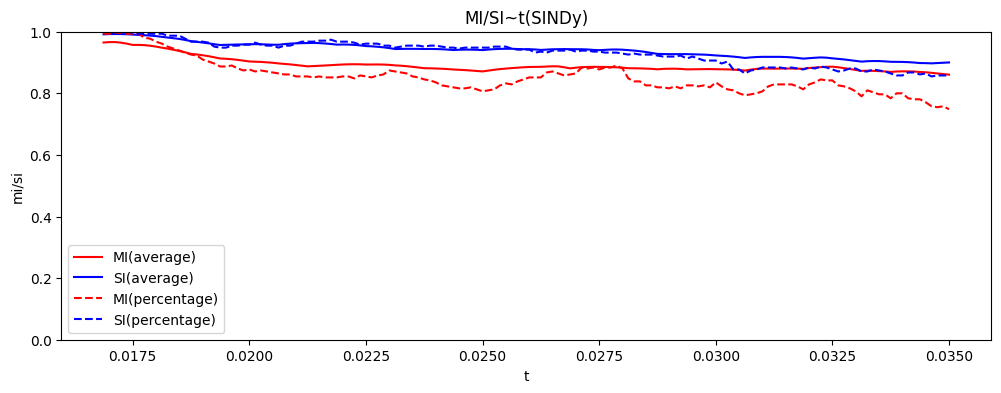

round: 28
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 577.399 1 + 28.559 Vx + 263.634 Vy + -44463.795 t + -33.850 VxVx + -19.075 VyVy + 785958.549 tt + 17.218 VxVy + -2250.537 Vxt + -7223.230 Vyt + -3.745 VxVxVy + 915.921 VxVxt + 717.465 VyVyt + -1078.720 VxVyt + 1434.403 Vx_2 + 1273.439 Vy_2 + -886.547 Vx_1 + -521.268 Vy_1 + 0.065 VxVx_2 + -117.881 VxVy_2 + -110188.502 Vxt_2 + -11.603 VyVx_2 + 114.233 VyVy_2 + 1959209.866 Vyt_2 + 22.529 tVx_2 + 442.878 tVy_2 + -1438.669 tt_2 + 3.564 VxVxVx_2 + 477.249 VxVxVy_2 + -4447.991 VxVxt_2 + -771.800 VyVyVx_2 + 143.238 VyVyVy_2 + -68.231 VyVyt_2 + -89986.850 ttVx_2 + -19.984 ttVy_2 + -3.506 ttt_2 + 1506546.537 VxVyVx_2 + -127.341 VxVyVy_2 + -1980.334 VxVyt_2 + -163.377 VxtVx_2 + 1.593 VxtVy_2 + 1120.548 Vxtt_2 + -267.862 VytVx_2 + 5158.065 VytVy_2 + 47.170 VxVx_1 + -359.635 VxVy_1 + 73943.853 Vxt_1 + 3.557 VyVx_1 + -79.736 VyVy_1 + -1446893.733 Vyt_1 + -3.266 tVx_1 + -2675.322 tVy_1 + 10572.896 tt_1 + 4.680 VxVxVx_1 + -140.865 VxVxVy_1 + 2781.675 VxV

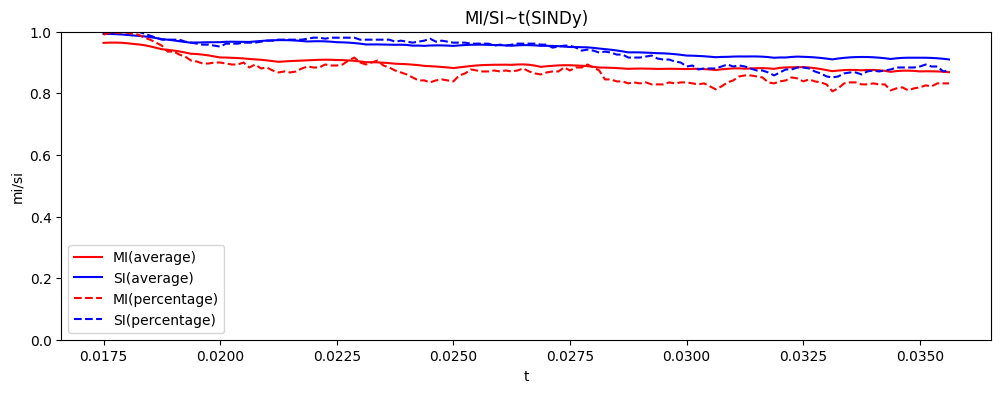

round: 29
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 569.229 1 + 21.446 Vx + 265.456 Vy + -42893.922 t + -32.640 VxVx + 3.995 VyVy + 743271.740 tt + -2.363 VxVy + -2022.187 Vxt + -7488.495 Vyt + -2.712 VxVxVy + 900.429 VxVxt + -86.906 VyVyt + -359.107 VxVyt + 1937.845 Vx_2 + 938.434 Vy_2 + -1456.072 Vx_1 + -533.169 Vy_1 + 103.995 VxVx_2 + -356.362 VxVy_2 + -148266.840 Vxt_2 + 9.348 VyVx_2 + 13.763 VyVy_2 + 2663279.962 Vyt_2 + -1.226 tVx_2 + -3387.504 tVy_2 + 7257.367 tt_2 + 3.137 VxVxVx_2 + -304.224 VxVxVy_2 + -947.399 VxVxt_2 + 173.361 VyVyVx_2 + 403.345 VyVyVy_2 + -136.472 VyVyt_2 + -64280.387 ttVx_2 + -16.127 ttVy_2 + -13.397 ttt_2 + 1042723.012 VxVyVx_2 + -10.394 VxVyVy_2 + -11046.103 VxVyt_2 + 2786.932 VxtVx_2 + -0.334 VxtVy_2 + 703.242 Vxtt_2 + 171.978 VytVx_2 + 1097.755 VytVy_2 + 110.328 VxVx_1 + -295.013 VxVy_1 + 118066.889 Vxt_1 + 6.494 VyVx_1 + -52.798 VyVy_1 + -2269674.081 Vyt_1 + 17.008 tVx_1 + -5168.209 tVy_1 + 8868.788 tt_1 + 3.086 VxVxVx_1 + -296.367 VxVxVy_1 + 1893.358 VxVxt

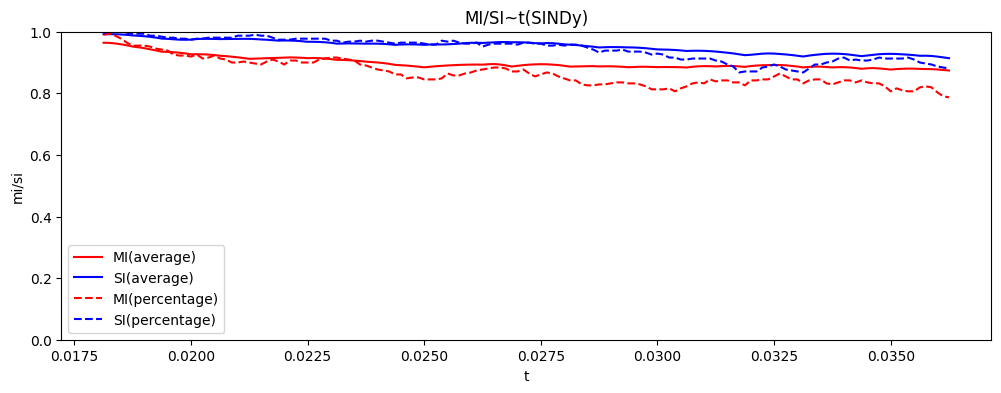

round: 30
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1011.123 1 + 40.178 Vx + 182.978 Vy + -75304.684 t + -33.362 VxVx + 10.391 VyVy + 1320711.631 tt + 6.020 VxVy + -2618.608 Vxt + -4642.622 Vyt + -2.318 VxVxVy + 958.597 VxVxt + -276.234 VyVyt + -462.999 VxVyt + 2182.271 Vx_2 + 280.471 Vy_2 + -1706.226 Vx_1 + -868.621 Vy_1 + 52.558 VxVx_2 + -297.582 VxVy_2 + -163022.749 Vxt_2 + 9.599 VyVx_2 + -21.483 VyVy_2 + 2870901.387 Vyt_2 + -47.291 tVx_2 + -1527.788 tVy_2 + 4415.757 tt_2 + 4.415 VxVxVx_2 + -255.968 VxVxVy_2 + 122.891 VxVxt_2 + 1535.749 VyVyVx_2 + 439.182 VyVyVy_2 + 12.012 VyVyt_2 + -16206.812 ttVx_2 + 11.619 ttVy_2 + 8.775 ttt_2 + 188934.351 VxVyVx_2 + 59.722 VxVyVy_2 + -12312.551 VxVyt_2 + -2806.040 VxtVx_2 + -1.370 VxtVy_2 + -91.896 Vxtt_2 + -671.621 VytVx_2 + -1396.962 VytVy_2 + 120.407 VxVx_1 + -275.207 VxVy_1 + 132909.762 Vxt_1 + 3.528 VyVx_1 + -41.765 VyVy_1 + -2476309.870 Vyt_1 + -12.040 tVx_1 + -5558.056 tVy_1 + 8690.624 tt_1 + 1.887 VxVxVx_1 + -241.797 VxVxVy_1 + 1508.468 VxVx

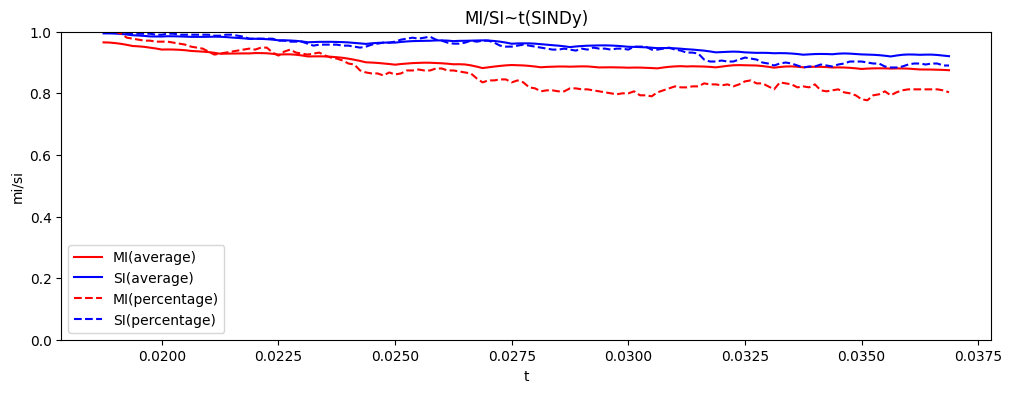

round: 31
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1124.141 1 + 92.804 Vx + 189.044 Vy + -82199.508 t + -26.073 VxVx + 10.155 VyVy + 1421319.453 tt + -23.751 VxVy + -4445.819 Vxt + -5172.268 Vyt + -0.627 VxVxVy + 697.493 VxVxt + -289.788 VyVyt + 664.095 VxVyt + 2271.840 Vx_2 + 173.442 Vy_2 + -1542.793 Vx_1 + -1015.162 Vy_1 + 45.823 VxVx_2 + -143.135 VxVy_2 + -166855.618 Vxt_2 + 5.674 VyVx_2 + 10.636 VyVy_2 + 2898206.826 Vyt_2 + 21.347 tVx_2 + -1172.220 tVy_2 + -500.620 tt_2 + 3.548 VxVxVx_2 + -96.817 VxVxVy_2 + -995.740 VxVxt_2 + -907.807 VyVyVx_2 + 329.475 VyVyVy_2 + 4.831 VyVyt_2 + -11378.704 ttVx_2 + -32.670 ttVy_2 + 4.852 ttt_2 + 150174.359 VxVyVx_2 + 44.811 VxVyVy_2 + -8372.967 VxVyt_2 + -3092.704 VxtVx_2 + 1445.550 Vxtt_2 + -599.237 VytVx_2 + -1054.213 VytVy_2 + 132.489 VxVx_1 + -296.574 VxVy_1 + 115678.699 Vxt_1 + 12.996 VyVx_1 + -20.949 VyVy_1 + -2082549.006 Vyt_1 + 40.745 tVx_1 + -6200.150 tVy_1 + 9071.321 tt_1 + 2.010 VxVxVx_1 + -632.638 VxVxVy_1 + 765.392 VxVxt_1 + -1298.992 Vy

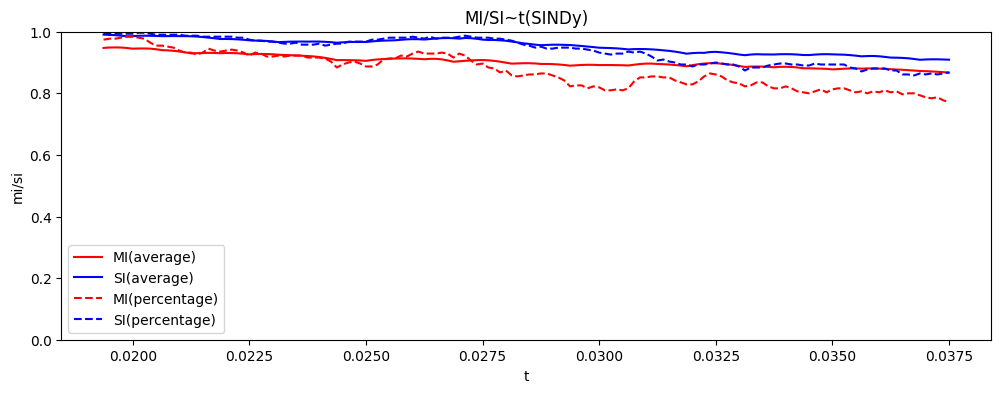

round: 32
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1086.405 1 + 44.617 Vx + 45.940 Vy + -79200.753 t + -32.257 VxVx + -1.271 VyVy + 1363465.340 tt + -26.441 VxVy + -2577.709 Vxt + -372.567 Vyt + 0.206 VxVxVy + 916.636 VxVxt + 69.225 VyVyt + 879.916 VxVyt + 2345.056 Vx_2 + -792.687 Vy_2 + -1340.531 Vx_1 + -1152.448 Vy_1 + 37.702 VxVx_2 + -140.006 VxVy_2 + -171890.653 Vxt_2 + 8.137 VyVx_2 + -15.924 VyVy_2 + 2981671.756 Vyt_2 + -4.640 tVx_2 + -834.276 tVy_2 + -638.885 tt_2 + 2.740 VxVxVx_2 + -166.604 VxVxVy_2 + -82.835 VxVxt_2 + -90.299 VyVyVx_2 + 302.855 VyVyVy_2 + 56.675 VyVyt_2 + 57904.474 ttVx_2 + -27.482 ttVy_2 + 14.575 ttt_2 + -1041272.841 VxVyVx_2 + 83.883 VxVyVy_2 + -7425.215 VxVyt_2 + -4635.214 VxtVx_2 + -2.295 VxtVy_2 + 1138.738 Vxtt_2 + -898.137 VytVx_2 + -2483.477 VytVy_2 + 210.909 VxVx_1 + -191.196 VxVy_1 + 100157.479 Vxt_1 + 26.489 VyVx_1 + -7.974 VyVy_1 + -1791493.480 Vyt_1 + 62.751 tVx_1 + -8997.175 tVy_1 + 5894.153 tt_1 + 0.822 VxVxVx_1 + -1132.318 VxVxVy_1 + 389.403 VxVxt_1

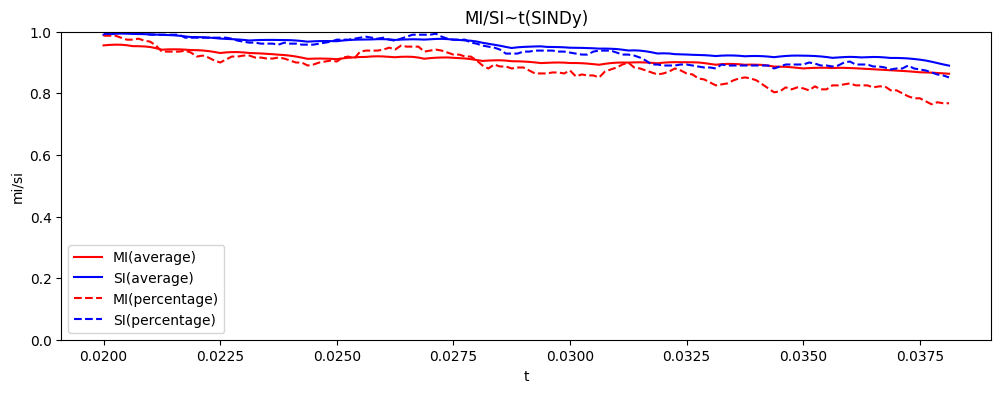

round: 33
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1042.414 1 + 28.057 Vx + -14.465 Vy + -74804.517 t + -18.229 VxVx + -0.700 VyVy + 1267703.241 tt + -1.470 VxVy + -2387.205 Vxt + 1148.012 Vyt + -0.030 VxVxVy + 406.143 VxVxt + -1.319 VyVyt + -6.069 VxVyt + 2483.420 Vx_2 + -692.651 Vy_2 + -1505.964 Vx_1 + -940.567 Vy_1 + 12.259 VxVx_2 + -63.117 VxVy_2 + -179974.449 Vxt_2 + 6.949 VyVx_2 + -29.676 VyVy_2 + 3093294.666 Vyt_2 + -28.774 tVx_2 + -132.806 tVy_2 + -3001.759 tt_2 + 2.274 VxVxVx_2 + -131.313 VxVxVy_2 + 330.502 VxVxt_2 + 579.681 VyVyVx_2 + 71.981 VyVyVy_2 + -128.191 VyVyt_2 + 49303.250 ttVx_2 + -42.069 ttVy_2 + -8.579 ttt_2 + -875841.804 VxVyVx_2 + 81.496 VxVyVy_2 + 671.051 VxVyt_2 + 1865.582 VxtVx_2 + -2.103 VxtVy_2 + 1752.850 Vxtt_2 + -41.910 VytVx_2 + -2184.694 VytVy_2 + 98.143 VxVx_1 + 111.610 VxVy_1 + 110858.278 Vxt_1 + 3.095 VyVx_1 + 51.452 VyVy_1 + -1959928.976 Vyt_1 + 14.788 tVx_1 + -4686.718 tVy_1 + -2913.246 tt_1 + 0.615 VxVxVx_1 + -256.647 VxVxVy_1 + -1308.163 VxVxt_1 + -3

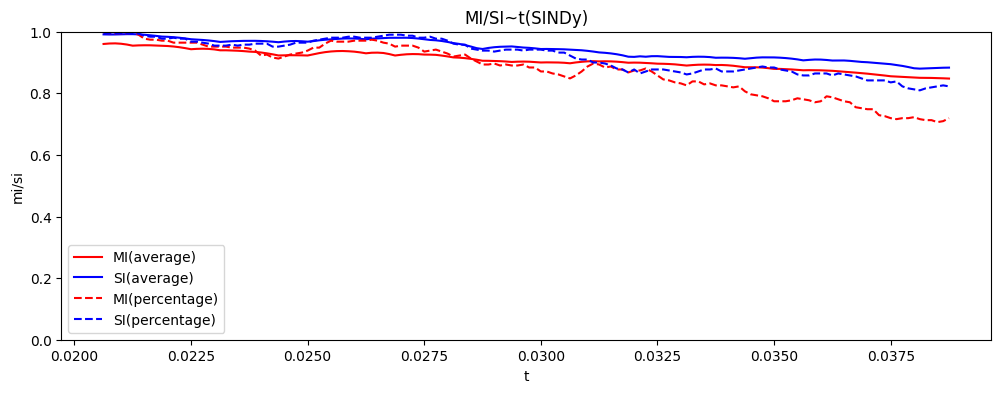

round: 34
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1247.027 1 + -6.473 Vx + -2.088 Vy + -86976.625 t + -8.241 VxVx + -0.539 VyVy + 1440276.652 tt + 7.370 VxVy + -1183.305 Vxt + 880.147 Vyt + -0.338 VxVxVy + 69.169 VxVxt + 2.144 VyVyt + -387.192 VxVyt + 2254.094 Vx_2 + -10.933 Vy_2 + -615.348 Vx_1 + -1017.961 Vy_1 + 68.982 VxVx_2 + -69.293 VxVy_2 + -159234.453 Vxt_2 + 10.259 VyVx_2 + -38.645 VyVy_2 + 2666129.307 Vyt_2 + -14.362 tVx_2 + -2200.658 tVy_2 + -3189.083 tt_2 + 1.951 VxVxVx_2 + -289.297 VxVxVy_2 + 579.168 VxVxt_2 + 14.371 VyVyVx_2 + 184.284 VyVyVy_2 + -134.988 VyVyt_2 + 2025.608 ttVx_2 + -23.405 ttVy_2 + -10.407 ttt_2 + -77351.318 VxVyVx_2 + 102.570 VxVyVy_2 + -2820.941 VxVyt_2 + 2056.372 VxtVx_2 + -2.054 VxtVy_2 + 1169.584 Vxtt_2 + -4.123 VytVx_2 + -2821.777 VytVy_2 + 146.185 VxVx_1 + 167.870 VxVy_1 + 49321.566 Vxt_1 + 13.785 VyVx_1 + 58.168 VyVy_1 + -920722.785 Vyt_1 + -12.890 tVx_1 + -6528.353 tVy_1 + -4438.706 tt_1 + 0.223 VxVxVx_1 + -627.423 VxVxVy_1 + -1366.036 VxVxt_1 + 694

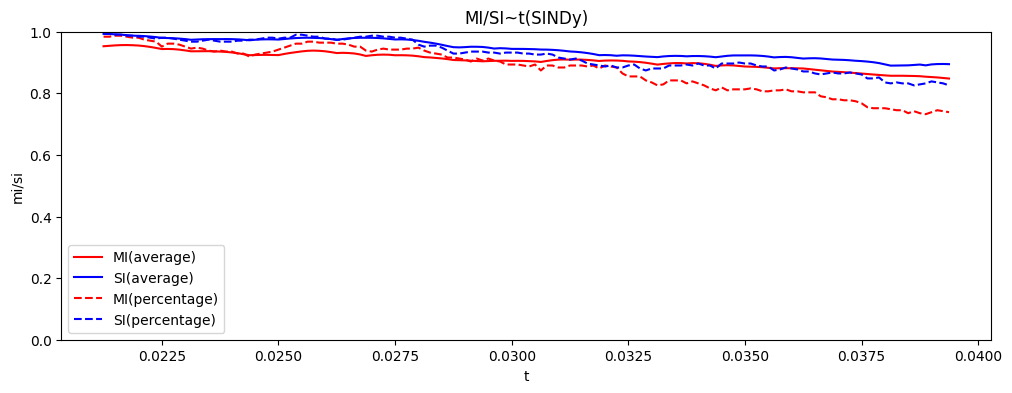

round: 35
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1136.506 1 + -31.985 Vx + 28.604 Vy + -78589.379 t + -2.988 VxVx + 8.539 VyVy + 1287330.174 tt + 8.198 VxVy + -341.688 Vxt + -157.858 Vyt + -0.530 VxVxVy + -122.622 VxVxt + -311.719 VyVyt + -520.285 VxVyt + 2268.921 Vx_2 + 11.899 Vy_2 + -826.800 Vx_1 + -905.678 Vy_1 + -108.302 VxVx_2 + -347.781 VxVy_2 + -159395.604 Vxt_2 + -15.811 VyVx_2 + -97.747 VyVy_2 + 2656783.509 Vyt_2 + -84.454 tVx_2 + 3993.001 tVy_2 + 6092.500 tt_2 + 2.915 VxVxVx_2 + 647.137 VxVxVy_2 + 2492.852 VxVxt_2 + 2492.441 VyVyVx_2 + 324.119 VyVyVy_2 + -42.992 VyVyt_2 + 1098.746 ttVx_2 + 18.621 ttVy_2 + 6.285 ttt_2 + -70738.822 VxVyVx_2 + 154.838 VxVyVy_2 + -7473.291 VxVyt_2 + -934.474 VxtVx_2 + -0.616 VxtVy_2 + -235.249 Vxtt_2 + -528.522 VytVx_2 + -4480.551 VytVy_2 + 77.560 VxVx_1 + 304.763 VxVy_1 + 63137.511 Vxt_1 + -2.116 VyVx_1 + 91.771 VyVy_1 + -1141655.851 Vyt_1 + -13.445 tVx_1 + -4187.609 tVy_1 + -8221.876 tt_1 + -0.527 VxVxVx_1 + -95.983 VxVxVy_1 + -2202.328 VxVxt_1 

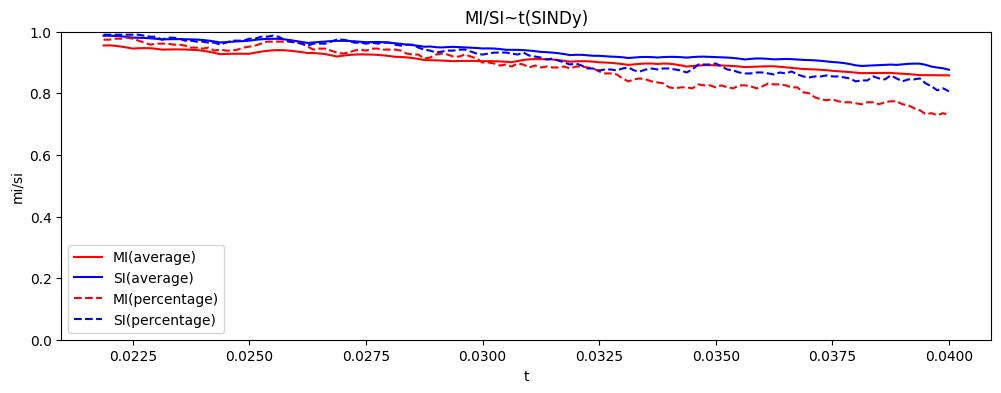

round: 36
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 933.387 1 + -58.753 Vx + -17.993 Vy + -65021.639 t + 28.027 VxVx + 13.775 VyVy + 1062314.682 tt + 17.197 VxVy + 490.392 Vxt + 1400.889 Vyt + -0.324 VxVxVy + -1114.048 VxVxt + -444.703 VyVyt + -764.762 VxVyt + 1337.776 Vx_2 + 517.175 Vy_2 + -197.381 Vx_1 + -243.612 Vy_1 + 65.999 VxVx_2 + -176.857 VxVy_2 + -96779.349 Vxt_2 + 14.826 VyVx_2 + -96.415 VyVy_2 + 1622109.816 Vyt_2 + -20.131 tVx_2 + -2003.011 tVy_2 + 311.910 tt_2 + 1.428 VxVxVx_2 + -434.030 VxVxVy_2 + 2367.039 VxVxt_2 + 90.699 VyVyVx_2 + 280.208 VyVyVy_2 + -199.621 VyVyt_2 + -31156.385 ttVx_2 + 3.648 ttVy_2 + -18.004 ttt_2 + 435649.553 VxVyVx_2 + 171.431 VxVyVy_2 + -6037.774 VxVyt_2 + 3883.735 VxtVx_2 + -0.915 VxtVy_2 + 301.728 Vxtt_2 + 222.401 VytVx_2 + -4930.106 VytVy_2 + 162.020 VxVx_1 + 428.791 VxVy_1 + 21713.322 Vxt_1 + 21.576 VyVx_1 + 83.858 VyVy_1 + -466374.022 Vyt_1 + -77.771 tVx_1 + -7123.136 tVy_1 + -11940.840 tt_1 + 0.502 VxVxVx_1 + -893.958 VxVxVy_1 + -1894.009 VxVxt_1

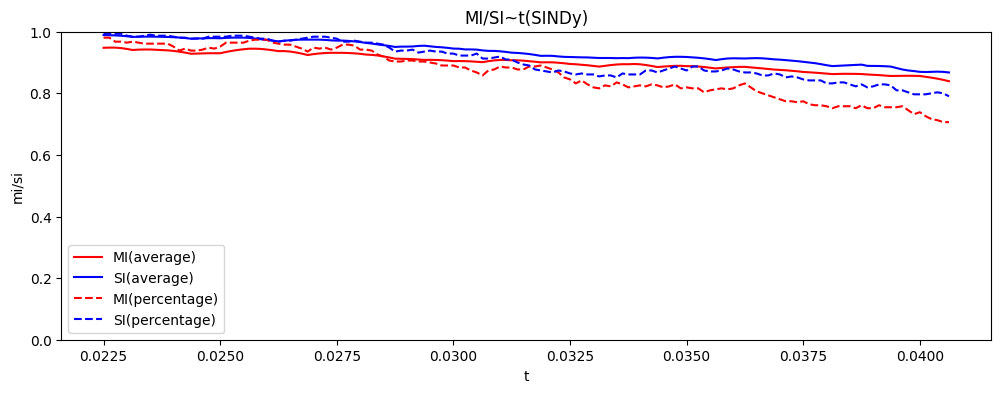

round: 37
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 60.361 1 + -22.834 Vx + 6.842 Vy + -9085.603 t + 17.426 VxVx + 26.007 VyVy + 186831.042 tt + 15.517 VxVy + -652.219 Vxt + 548.735 Vyt + -0.116 VxVxVy + -843.667 VxVxt + -844.626 VyVyt + -829.688 VxVyt + 397.280 Vx_2 + 1111.020 Vy_2 + 943.088 Vx_1 + 245.926 Vy_1 + 249.874 VxVx_2 + -295.572 VxVy_2 + -39904.752 Vxt_2 + 60.305 VyVx_2 + -130.662 VyVy_2 + 773536.736 Vyt_2 + -7940.501 tVy_2 + 3649.943 tt_2 + 2.678 VxVxVx_2 + -1894.813 VxVxVy_2 + 3370.834 VxVxt_2 + -204.616 VyVyVx_2 + 359.827 VyVyVy_2 + -116.463 VyVyt_2 + -68914.228 ttVx_2 + 34.802 ttVy_2 + -2.771 ttt_2 + 1026931.372 VxVyVx_2 + 189.478 VxVyVy_2 + -8392.529 VxVyt_2 + 1197.272 VxtVx_2 + 1.938 VxtVy_2 + -937.653 Vxtt_2 + -254.928 VytVx_2 + -5528.735 VytVy_2 + 117.461 VxVx_1 + 491.756 VxVy_1 + -52706.955 Vxt_1 + 27.269 VyVx_1 + 97.970 VyVy_1 + 725419.626 Vyt_1 + -47.078 tVx_1 + -5206.193 tVy_1 + -13225.556 tt_1 + 0.705 VxVxVx_1 + -998.565 VxVxVy_1 + -2287.200 VxVxt_1 + 1980.665 VyVyV

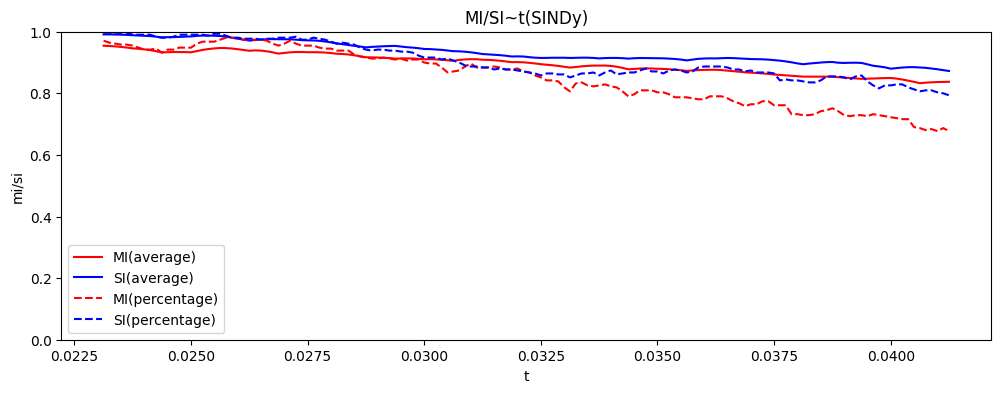

round: 38
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -269.227 1 + -37.355 Vx + 44.293 Vy + 10769.221 t + 4.568 VxVx + 31.735 VyVy + -107687.436 tt + -7.510 VxVy + 70.883 Vxt + -449.908 Vyt + 0.594 VxVxVy + -436.035 VxVxt + -970.789 VyVyt + -42.138 VxVyt + -900.480 Vx_2 + 1214.962 Vy_2 + 1441.688 Vx_1 + 782.894 Vy_1 + 300.755 VxVx_2 + -255.872 VxVy_2 + 39487.644 Vxt_2 + 67.428 VyVx_2 + -110.968 VyVy_2 + -423001.506 Vyt_2 + 32.881 tVx_2 + -9424.647 tVy_2 + 2510.105 tt_2 + 2.417 VxVxVx_2 + -2122.446 VxVxVy_2 + 2781.682 VxVxt_2 + -1162.343 VyVyVx_2 + 346.887 VyVyVy_2 + -124.020 VyVyt_2 + -71412.986 ttVx_2 + 10.381 ttVy_2 + -15.701 ttt_2 + 1004964.083 VxVyVx_2 + 179.139 VxVyVy_2 + -7795.382 VxVyt_2 + 1579.635 VxtVx_2 + 1.558 VxtVy_2 + -259.772 Vxtt_2 + 167.307 VytVx_2 + -5212.838 VytVy_2 + 159.445 VxVx_1 + 555.453 VxVy_1 + -82404.049 Vxt_1 + 33.506 VyVx_1 + 112.571 VyVy_1 + 1152597.210 Vyt_1 + -6.675 tVx_1 + -6636.191 tVy_1 + -15046.547 tt_1 + -0.380 VxVxVx_1 + -1191.546 VxVxVy_1 + -2820.861 VxV

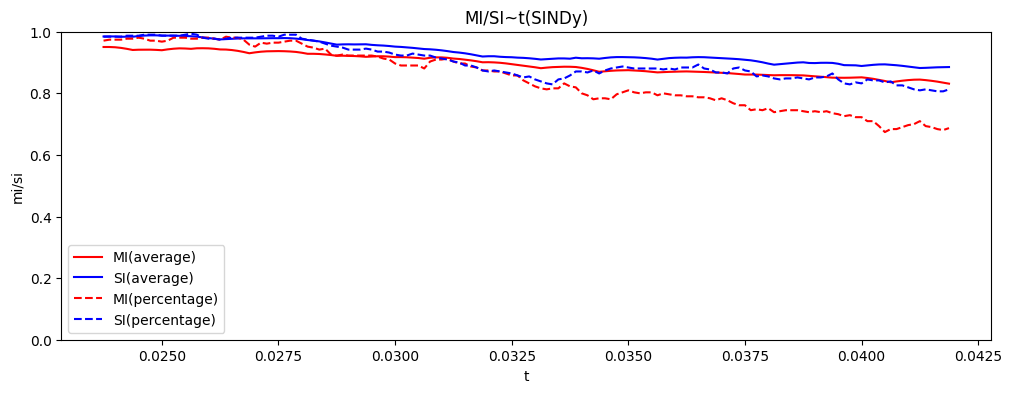

round: 39
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -943.301 1 + -52.748 Vx + -58.676 Vy + 51656.176 t + 0.035 VxVx + 6.876 VyVy + -716135.866 tt + -32.047 VxVy + 572.820 Vxt + 2482.019 Vyt + 0.728 VxVxVy + -294.287 VxVxt + -247.707 VyVyt + 664.768 VxVyt + -1738.125 Vx_2 + 2226.933 Vy_2 + 1627.087 Vx_1 + 1360.513 Vy_1 + 254.730 VxVx_2 + -318.492 VxVy_2 + 89448.631 Vxt_2 + 55.570 VyVx_2 + -125.285 VyVy_2 + -1155323.260 Vyt_2 + 50.677 tVx_2 + -7937.564 tVy_2 + 4242.373 tt_2 + 2.548 VxVxVx_2 + -1744.543 VxVxVy_2 + 3171.183 VxVxt_2 + -1701.622 VyVyVx_2 + 244.160 VyVyVy_2 + -116.305 VyVyt_2 + -132804.470 ttVx_2 + -2.648 ttVy_2 + -5.768 ttt_2 + 1923112.452 VxVyVx_2 + 207.492 VxVyVy_2 + -4561.857 VxVyt_2 + 1600.053 VxtVx_2 + 2.474 VxtVy_2 + 119.751 Vxtt_2 + -98.827 VytVx_2 + -6027.979 VytVy_2 + 98.859 VxVx_1 + 605.893 VxVy_1 + -94018.538 Vxt_1 + 39.980 VyVx_1 + 174.442 VyVy_1 + 1330236.710 Vyt_1 + 35.019 tVx_1 + -4480.675 tVy_1 + -15715.827 tt_1 + -1369.473 VxVxVy_1 + -4553.574 VxVxt_1 + -495.123

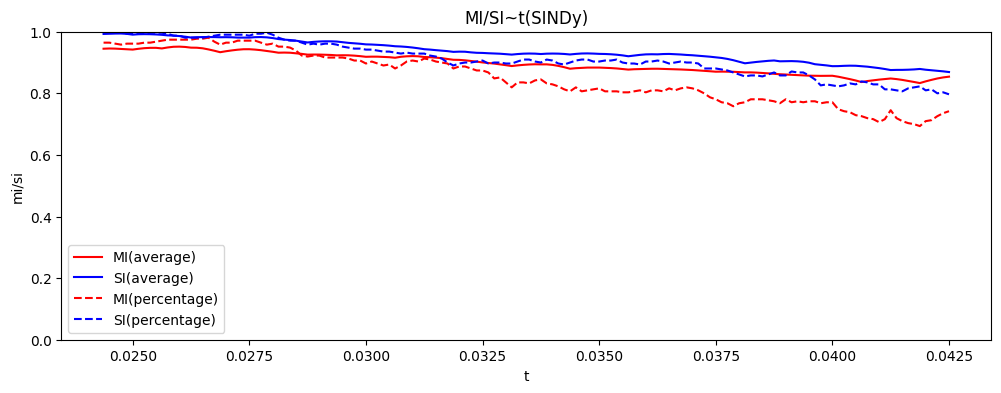

round: 40
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -792.749 1 + -103.439 Vx + -33.001 Vy + 41539.931 t + -5.505 VxVx + 14.884 VyVy + -551661.326 tt + -39.086 VxVy + 2258.498 Vxt + 1798.804 Vyt + 1.284 VxVxVy + -76.923 VxVxt + -428.750 VyVyt + 951.081 VxVyt + -1584.980 Vx_2 + 1751.377 Vy_2 + 2366.733 Vx_1 + 1336.993 Vy_1 + 297.450 VxVx_2 + -475.762 VxVy_2 + 80346.704 Vxt_2 + 69.314 VyVx_2 + -145.363 VyVy_2 + -1023218.232 Vyt_2 + 17.685 tVx_2 + -9242.386 tVy_2 + 9142.054 tt_2 + 2.739 VxVxVx_2 + -2154.060 VxVxVy_2 + 3677.134 VxVxt_2 + -595.491 VyVyVx_2 + 348.479 VyVyVy_2 + -128.968 VyVyt_2 + -102642.291 ttVx_2 + 25.144 ttVy_2 + -10.212 ttt_2 + 1459721.777 VxVyVx_2 + 203.406 VxVyVy_2 + -7905.106 VxVyt_2 + 1995.258 VxtVx_2 + 2.253 VxtVy_2 + -804.010 Vxtt_2 + 43.415 VytVx_2 + -5839.040 VytVy_2 + 69.303 VxVx_1 + 576.219 VxVy_1 + -136496.585 Vxt_1 + 35.641 VyVx_1 + 150.204 VyVy_1 + 1928373.240 Vyt_1 + 56.460 tVx_1 + -3545.225 tVy_1 + -15083.949 tt_1 + -0.084 VxVxVx_1 + -1195.967 VxVxVy_1 + -3873.

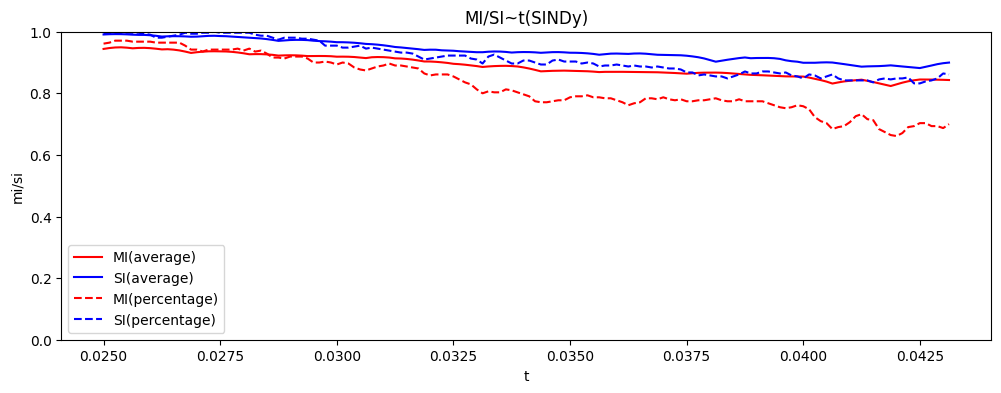

round: 41
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1535.858 1 + -65.418 Vx + -63.303 Vy + 83790.122 t + -9.829 VxVx + 3.407 VyVy + -1141294.252 tt + -47.310 VxVy + 1022.322 Vxt + 2443.029 Vyt + 1.299 VxVxVy + 26.033 VxVxt + -103.811 VyVyt + 1144.280 VxVyt + -2458.566 Vx_2 + 1321.790 Vy_2 + 1849.291 Vx_1 + 1598.913 Vy_1 + 213.004 VxVx_2 + -530.610 VxVy_2 + 128883.384 Vxt_2 + 52.763 VyVx_2 + -116.785 VyVy_2 + -1685965.439 Vyt_2 + 19.034 tVx_2 + -6564.497 tVy_2 + 11055.626 tt_2 + 3.525 VxVxVx_2 + -1629.675 VxVxVy_2 + 2845.033 VxVxt_2 + -407.144 VyVyVx_2 + 233.289 VyVyVy_2 + -156.623 VyVyt_2 + -79137.073 ttVx_2 + 16.166 ttVy_2 + -19.776 ttt_2 + 1142341.927 VxVyVx_2 + 143.529 VxVyVy_2 + -4071.476 VxVyt_2 + 3049.115 VxtVx_2 + 3.883 VxtVy_2 + -479.364 Vxtt_2 + 355.377 VytVx_2 + -3843.945 VytVy_2 + -12.119 VxVx_1 + 575.746 VxVy_1 + -106863.311 Vxt_1 + 31.863 VyVx_1 + 146.012 VyVy_1 + 1511774.530 Vyt_1 + 94.301 tVx_1 + -530.275 tVy_1 + -14792.873 tt_1 + 0.426 VxVxVx_1 + -969.073 VxVxVy_1 + -3784.

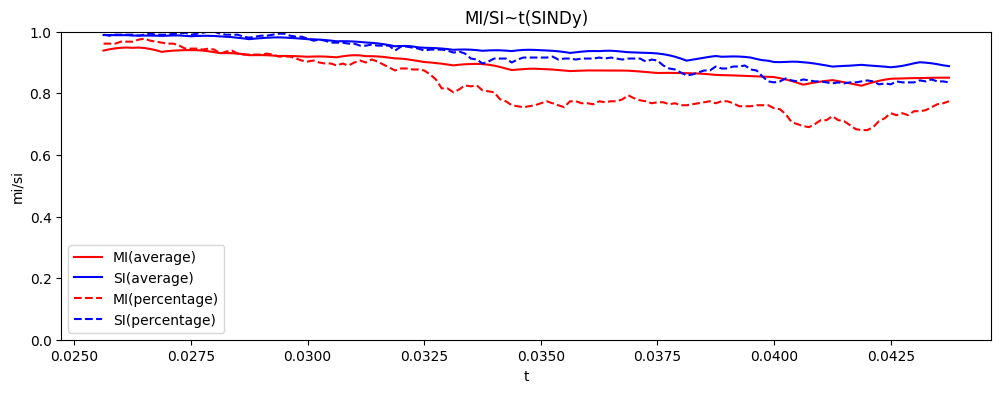

round: 42
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1671.919 1 + -164.842 Vx + -93.921 Vy + 89957.430 t + -19.800 VxVx + 1.724 VyVy + -1206238.824 tt + -40.278 VxVy + 4095.111 Vxt + 3382.204 Vyt + 2.070 VxVxVy + 336.933 VxVxt + -4.845 VyVyt + 1035.626 VxVyt + -3313.386 Vx_2 + 1687.101 Vy_2 + 2254.525 Vx_1 + 1751.325 Vy_1 + 134.289 VxVx_2 + -507.119 VxVy_2 + 175461.019 Vxt_2 + 39.180 VyVx_2 + -89.398 VyVy_2 + -2310506.458 Vyt_2 + -26.558 tVx_2 + -4080.852 tVy_2 + 10710.048 tt_2 + 1.850 VxVxVx_2 + -1196.346 VxVxVy_2 + 2009.799 VxVxt_2 + 815.057 VyVyVx_2 + 367.876 VyVyVy_2 + -42.124 VyVyt_2 + -97009.228 ttVx_2 + 72.015 ttVy_2 + -5.148 ttt_2 + 1353914.027 VxVyVx_2 + 131.920 VxVyVy_2 + -7566.764 VxVyt_2 + 320.051 VxtVx_2 + 2.637 VxtVy_2 + -2069.310 Vxtt_2 + 42.439 VytVx_2 + -3360.804 VytVy_2 + 30.085 VxVx_1 + 690.663 VxVy_1 + -126122.048 Vxt_1 + 42.695 VyVx_1 + 118.695 VyVy_1 + 1727513.323 Vyt_1 + 116.698 tVx_1 + -1828.047 tVy_1 + -17795.786 tt_1 + 0.406 VxVxVx_1 + -1313.973 VxVxVy_1 + -3003.5

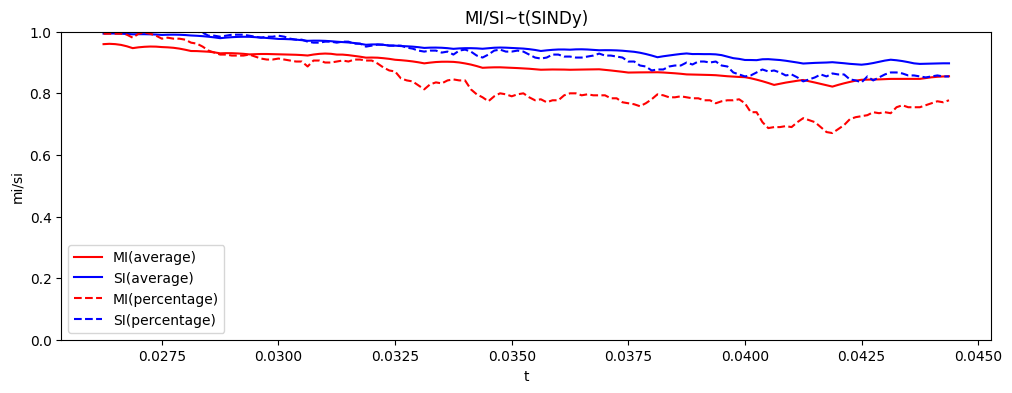

round: 43
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1945.613 1 + -203.983 Vx + -65.255 Vy + 104222.231 t + -32.062 VxVx + 8.753 VyVy + -1387163.491 tt + -37.191 VxVy + 5131.133 Vxt + 2406.153 Vyt + 2.051 VxVxVy + 700.565 VxVxt + -221.796 VyVyt + 900.493 VxVyt + -3389.611 Vx_2 + 1540.418 Vy_2 + 3296.985 Vx_1 + 2041.282 Vy_1 + 155.172 VxVx_2 + -601.931 VxVy_2 + 177778.436 Vxt_2 + 40.538 VyVx_2 + -92.549 VyVy_2 + -2311876.812 Vyt_2 + -22.390 tVx_2 + -4810.136 tVy_2 + 13092.953 tt_2 + 2.473 VxVxVx_2 + -1252.298 VxVxVy_2 + 1996.863 VxVxt_2 + 666.898 VyVyVx_2 + 386.379 VyVyVy_2 + -127.129 VyVyt_2 + -91593.192 ttVx_2 + 71.137 ttVy_2 + -17.498 ttt_2 + 1314528.054 VxVyVx_2 + 132.165 VxVyVy_2 + -8212.352 VxVyt_2 + 2305.759 VxtVx_2 + 3.565 VxtVy_2 + -2034.612 Vxtt_2 + 321.487 VytVx_2 + -3285.544 VytVy_2 + -182.192 VxVx_1 + 494.917 VxVy_1 + -186330.966 Vxt_1 + 1.151 VyVx_1 + 60.624 VyVy_1 + 2578266.193 Vyt_1 + 68.935 tVx_1 + 4347.210 tVy_1 + -12546.612 tt_1 + 0.460 VxVxVx_1 + -34.316 VxVxVy_1 + -1363

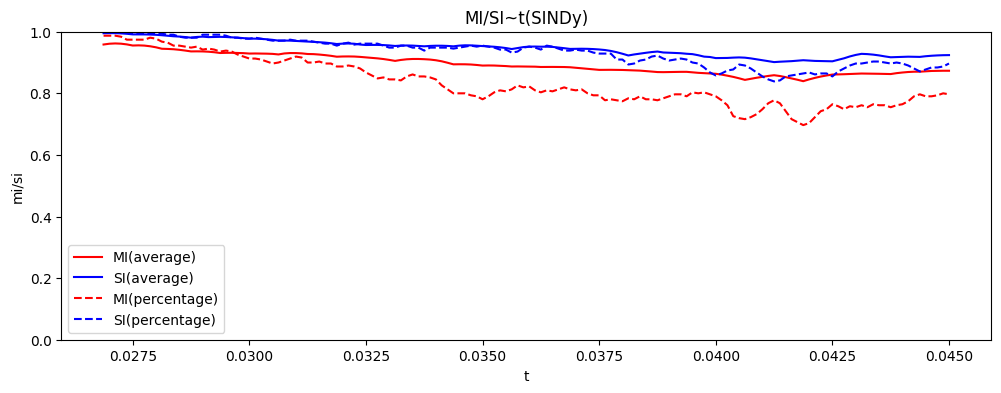

round: 44
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1623.610 1 + -241.320 Vx + -83.647 Vy + 85155.575 t + -51.208 VxVx + 3.016 VyVy + -1112037.301 tt + -50.216 VxVy + 6218.372 Vxt + 3029.729 Vyt + 1.852 VxVxVy + 1256.451 VxVxt + -46.163 VyVyt + 1303.136 VxVyt + -2904.358 Vx_2 + 768.513 Vy_2 + 2588.572 Vx_1 + 1980.566 Vy_1 + 36.912 VxVx_2 + -629.080 VxVy_2 + 151544.554 Vxt_2 + 18.284 VyVx_2 + -102.757 VyVy_2 + -1967036.574 Vyt_2 + -28.261 tVx_2 + -1972.467 tVy_2 + 13690.653 tt_2 + 2.069 VxVxVx_2 + -709.052 VxVxVy_2 + 2337.880 VxVxt_2 + 766.435 VyVyVx_2 + 407.089 VyVyVy_2 + -124.661 VyVyt_2 + -49304.060 ttVx_2 + 76.422 ttVy_2 + -18.472 ttt_2 + 742975.860 VxVyVx_2 + 110.174 VxVyVy_2 + -8744.740 VxVyt_2 + 2434.513 VxtVx_2 + 2.834 VxtVy_2 + -2168.330 Vxtt_2 + 362.345 VytVx_2 + -2773.593 VytVy_2 + -178.492 VxVx_1 + 462.617 VxVy_1 + -145613.369 Vxt_1 + 10.014 VyVx_1 + 63.808 VyVy_1 + 1999036.397 Vyt_1 + 117.274 tVx_1 + 4370.418 tVy_1 + -11387.136 tt_1 + 0.333 VxVxVx_1 + -262.180 VxVxVy_1 + -1469

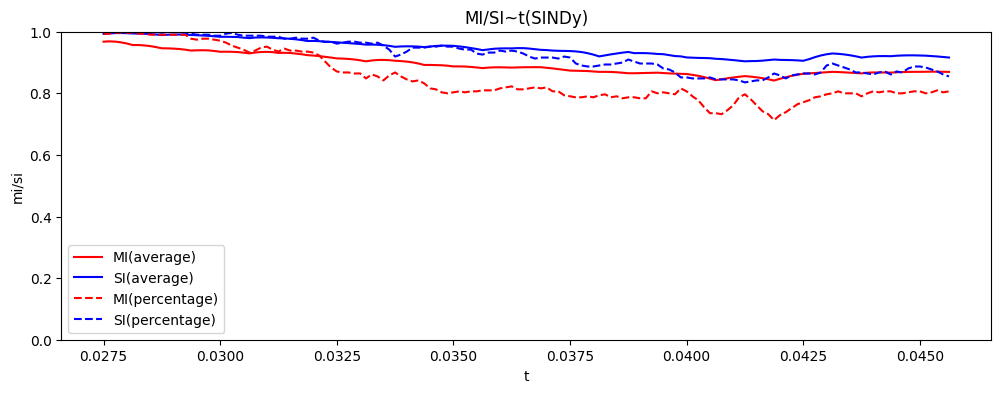

round: 45
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1613.440 1 + -305.331 Vx + -64.818 Vy + 83340.512 t + -59.068 VxVx + -0.129 VyVy + -1071302.434 tt + -57.715 VxVy + 8042.624 Vxt + 2484.326 Vyt + 1.721 VxVxVy + 1519.328 VxVxt + 82.767 VyVyt + 1489.927 VxVyt + -2680.979 Vx_2 + 991.021 Vy_2 + 2247.239 Vx_1 + 2013.718 Vy_1 + 44.667 VxVx_2 + -518.430 VxVy_2 + 135174.774 Vxt_2 + 19.282 VyVx_2 + -61.547 VyVy_2 + -1688831.732 Vyt_2 + -18.344 tVx_2 + -1913.433 tVy_2 + 10731.393 tt_2 + 1.340 VxVxVx_2 + -679.465 VxVxVy_2 + 1101.322 VxVxt_2 + 434.133 VyVyVx_2 + 320.174 VyVyVy_2 + -99.618 VyVyt_2 + -60755.356 ttVx_2 + 42.532 ttVy_2 + -14.356 ttt_2 + 884244.090 VxVyVx_2 + 60.764 VxVyVy_2 + -6337.525 VxVyt_2 + 1896.454 VxtVx_2 + 1.783 VxtVy_2 + -1188.012 Vxtt_2 + 275.387 VytVx_2 + -1272.530 VytVy_2 + -143.387 VxVx_1 + 463.146 VxVy_1 + -125019.530 Vxt_1 + 9.515 VyVx_1 + 63.830 VyVy_1 + 1696512.673 Vyt_1 + 116.456 tVx_1 + 2970.521 tVy_1 + -11973.730 tt_1 + 0.777 VxVxVx_1 + -327.570 VxVxVy_1 + -1547.685

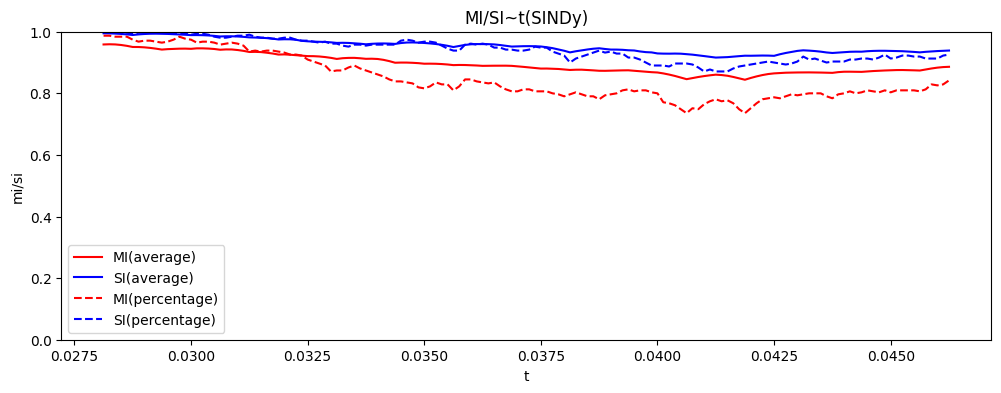

round: 46
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1337.891 1 + -357.347 Vx + -47.660 Vy + 67706.083 t + -48.545 VxVx + 16.409 VyVy + -851506.619 tt + -22.789 VxVy + 9229.736 Vxt + 2016.019 Vyt + 1264.168 VxVxt + -417.199 VyVyt + 395.350 VxVyt + -2291.227 Vx_2 + 489.792 Vy_2 + 2275.007 Vx_1 + 1631.874 Vy_1 + 20.790 VxVx_2 + -523.882 VxVy_2 + 114474.678 Vxt_2 + 13.722 VyVx_2 + -105.367 VyVy_2 + -1420921.377 Vyt_2 + -59.447 tVx_2 + -850.843 tVy_2 + 11014.740 tt_2 + 3.200 VxVxVx_2 + -414.613 VxVxVy_2 + 2401.595 VxVxt_2 + 1851.657 VyVyVx_2 + 286.695 VyVyVy_2 + -208.085 VyVyt_2 + -29169.126 ttVx_2 + 83.516 ttVy_2 + -37.419 ttt_2 + 406615.446 VxVyVx_2 + 76.877 VxVyVy_2 + -6182.831 VxVyt_2 + 4347.707 VxtVx_2 + 2.928 VxtVy_2 + -2418.182 Vxtt_2 + 812.408 VytVx_2 + -1824.395 VytVy_2 + -107.579 VxVx_1 + 310.828 VxVy_1 + -123378.344 Vxt_1 + 1.976 VyVx_1 + -6.677 VyVy_1 + 1633479.861 Vyt_1 + 25.046 tVx_1 + 1859.603 tVy_1 + -8801.485 tt_1 + 0.988 VxVxVx_1 + -157.831 VxVxVy_1 + 407.565 VxVxt_1 + -705.5

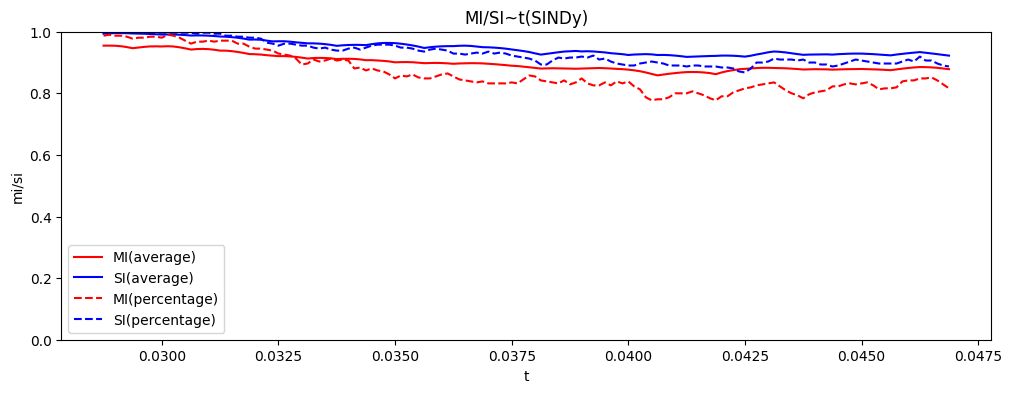

round: 47
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1102.440 1 + -440.028 Vx + -15.210 Vy + 54726.776 t + -50.401 VxVx + 19.503 VyVy + -675379.854 tt + 5.997 VxVy + 11367.971 Vxt + 1353.302 Vyt + -0.674 VxVxVy + 1356.450 VxVxt + -466.521 VyVyt + -295.634 VxVyt + -2286.390 Vx_2 + 612.439 Vy_2 + 2167.920 Vx_1 + 1226.631 Vy_1 + 13.873 VxVx_2 + -342.742 VxVy_2 + 114478.151 Vxt_2 + 15.721 VyVx_2 + -89.951 VyVy_2 + -1418915.300 Vyt_2 + -39.317 tVx_2 + -908.610 tVy_2 + 5780.654 tt_2 + 3.480 VxVxVx_2 + -514.899 VxVxVy_2 + 1961.243 VxVxt_2 + 1216.084 VyVyVx_2 + 68.103 VyVyVy_2 + -183.135 VyVyt_2 + -33293.634 ttVx_2 + 42.786 ttVy_2 + -32.774 ttt_2 + 432304.871 VxVyVx_2 + 44.707 VxVyVy_2 + 125.811 VxVyt_2 + 3848.169 VxtVx_2 + 2.068 VxtVy_2 + -1111.000 Vxtt_2 + 700.387 VytVx_2 + -948.620 VytVy_2 + -251.671 VxVx_1 + 227.950 VxVy_1 + -115996.307 Vxt_1 + -36.112 VyVx_1 + -37.273 VyVy_1 + 1514441.127 Vyt_1 + -76.048 tVx_1 + 5643.411 tVy_1 + -6567.220 tt_1 + -0.691 VxVxVx_1 + 869.121 VxVxVy_1 + 1126.657 V

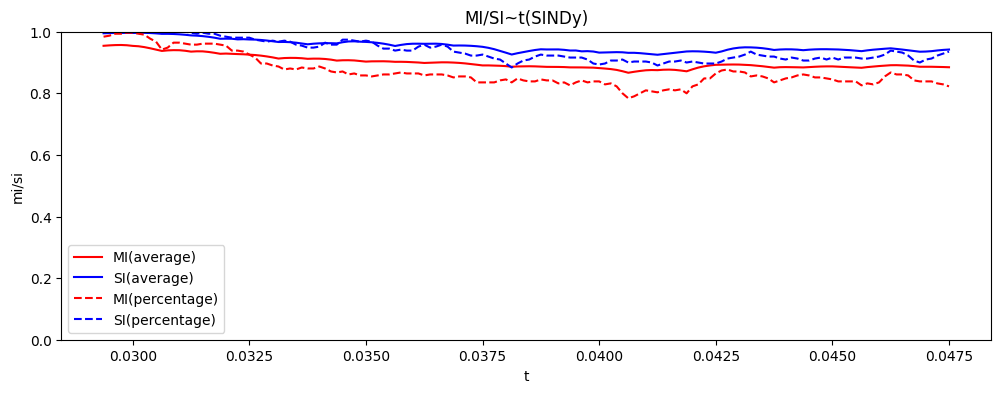

round: 48
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -693.117 1 + -421.220 Vx + 2.906 Vy + 33721.888 t + -29.331 VxVx + 18.984 VyVy + -409172.320 tt + 14.984 VxVy + 10795.855 Vxt + 865.866 Vyt + 0.323 VxVxVy + 818.876 VxVxt + -431.809 VyVyt + -392.105 VxVyt + -1348.395 Vx_2 + -125.025 Vy_2 + 1374.333 Vx_1 + 1015.635 Vy_1 + 179.505 VxVx_2 + -245.873 VxVy_2 + 65576.471 Vxt_2 + 41.239 VyVx_2 + -66.868 VyVy_2 + -788984.007 Vyt_2 + 3.462 tVx_2 + -4137.434 tVy_2 + 3894.861 tt_2 + 3.076 VxVxVx_2 + -974.328 VxVxVy_2 + 1389.632 VxVxt_2 + 130.080 VyVyVx_2 + 50.105 VyVyVy_2 + -230.120 VyVyt_2 + 5625.362 ttVx_2 + 8.423 ttVy_2 + -37.536 ttt_2 + -65718.149 VxVyVx_2 + 24.489 VxVyVy_2 + 328.964 VxVyt_2 + 4960.152 VxtVx_2 + 0.718 VxtVy_2 + -184.793 Vxtt_2 + 802.319 VytVx_2 + -502.382 VytVy_2 + -188.628 VxVx_1 + 272.561 VxVy_1 + -74606.845 Vxt_1 + -31.332 VyVx_1 + -27.151 VyVy_1 + 987892.889 Vyt_1 + -85.177 tVx_1 + 4039.415 tVy_1 + -7772.544 tt_1 + 0.059 VxVxVx_1 + 715.310 VxVxVy_1 + 833.067 VxVxt_1 + 1927.8

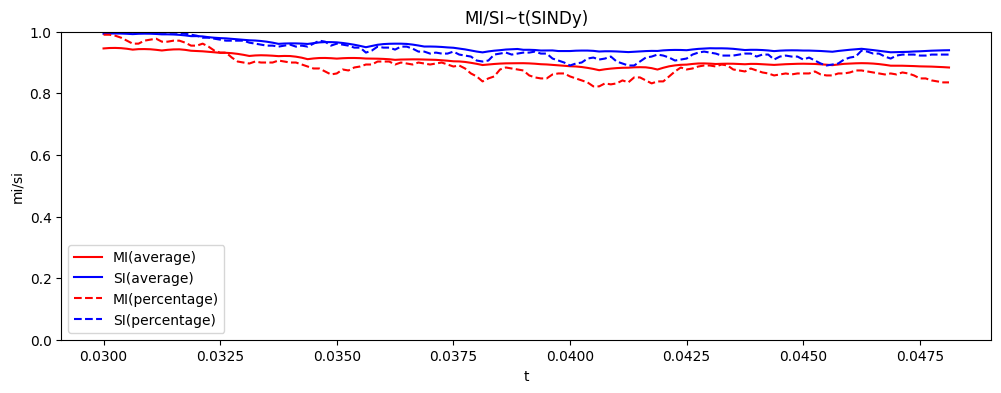

round: 49
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -733.587 1 + -467.483 Vx + 43.058 Vy + 35023.119 t + -43.966 VxVx + 32.681 VyVy + -416691.173 tt + 25.747 VxVy + 12135.960 Vxt + -85.070 Vyt + -1.056 VxVxVy + 1262.035 VxVxt + -800.909 VyVyt + -779.276 VxVyt + -1955.982 Vx_2 + 573.179 Vy_2 + 1916.744 Vx_1 + 482.822 Vy_1 + 76.024 VxVx_2 + -257.109 VxVy_2 + 97149.664 Vxt_2 + 24.714 VyVx_2 + -95.228 VyVy_2 + -1191943.354 Vyt_2 + -4.850 tVx_2 + -1904.773 tVy_2 + 3944.183 tt_2 + 3.336 VxVxVx_2 + -621.677 VxVxVy_2 + 2161.095 VxVxt_2 + 415.642 VyVyVx_2 + 128.869 VyVyVy_2 + -197.632 VyVyt_2 + -30084.728 ttVx_2 + 28.504 ttVy_2 + -29.347 ttt_2 + 382677.442 VxVyVx_2 + 37.038 VxVyVy_2 + -1840.326 VxVyt_2 + 4171.187 VxtVx_2 + 1.005 VxtVy_2 + -801.208 Vxtt_2 + 609.437 VytVx_2 + -870.953 VytVy_2 + 38.423 VxVx_1 + 365.882 VxVy_1 + -102504.610 Vxt_1 + 24.469 VyVx_1 + -49.498 VyVy_1 + 1336541.479 Vyt_1 + -40.171 tVx_1 + -1845.760 tVy_1 + -10037.913 tt_1 + 0.683 VxVxVx_1 + -715.217 VxVxVy_1 + 1435.663 VxVxt

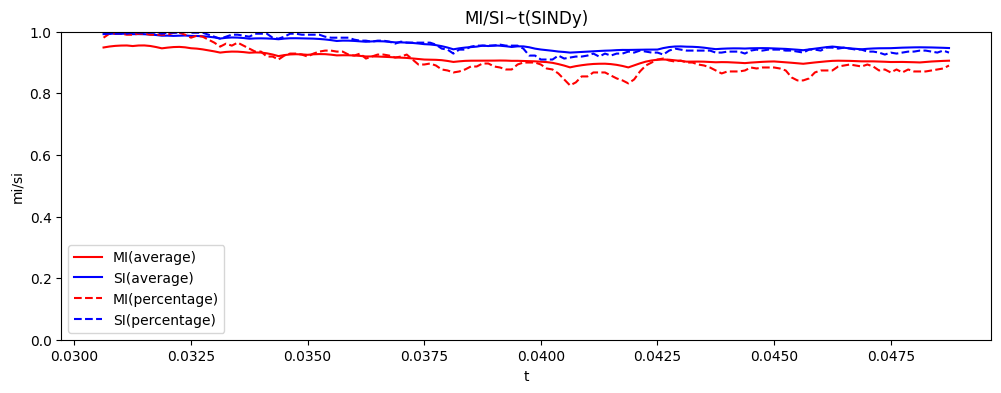

round: 50
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -636.523 1 + -461.002 Vx + 15.275 Vy + 30356.030 t + -76.853 VxVx + 30.926 VyVy + -360044.830 tt + 13.675 VxVy + 11659.890 Vxt + 535.628 Vyt + -0.424 VxVxVy + 1960.235 VxVxt + -741.083 VyVyt + -488.104 VxVyt + -1014.341 Vx_2 + 497.829 Vy_2 + 918.810 Vx_1 + -278.723 Vy_1 + -10.768 VxVx_2 + -291.103 VxVy_2 + 48655.971 Vxt_2 + -5.797 VyVx_2 + -116.655 VyVy_2 + -574441.226 Vyt_2 + -77.157 tVx_2 + 480.994 tVy_2 + 4721.738 tt_2 + 2.138 VxVxVx_2 + 169.311 VxVxVy_2 + 2580.860 VxVxt_2 + 2036.682 VyVyVx_2 + 68.420 VyVyVy_2 + -241.096 VyVyt_2 + -26823.950 ttVx_2 + 59.610 ttVy_2 + -34.602 ttt_2 + 349813.716 VxVyVx_2 + 25.757 VxVyVy_2 + -441.764 VxVyt_2 + 5105.480 VxtVx_2 + 0.514 VxtVy_2 + -1624.411 Vxtt_2 + 714.197 VytVx_2 + -621.986 VytVy_2 + -173.279 VxVx_1 + 272.776 VxVy_1 + -52899.199 Vxt_1 + -23.919 VyVx_1 + -47.444 VyVy_1 + 728115.380 Vyt_1 + -18.667 tVx_1 + 3230.235 tVy_1 + -8090.842 tt_1 + -1.546 VxVxVx_1 + 464.884 VxVxVy_1 + 1333.174 VxVxt_1

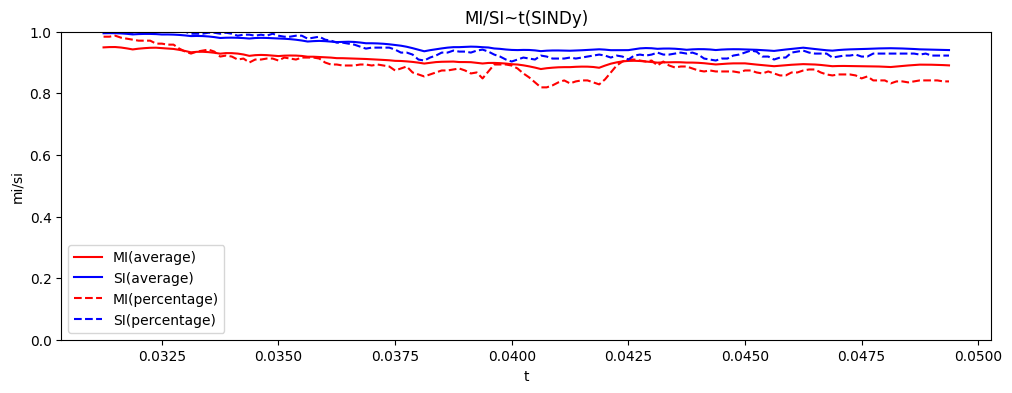

round: 51
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 314.879 1 + -390.272 Vx + 38.777 Vy + -17073.574 t + -47.842 VxVx + 30.301 VyVy + 222875.760 tt + 30.306 VxVy + 9946.302 Vxt + 45.520 Vyt + -1.061 VxVxVy + 1301.471 VxVxt + -683.055 VyVyt + -897.009 VxVyt + -171.628 Vx_2 + 437.159 Vy_2 + -197.525 Vx_1 + -647.568 Vy_1 + 20.452 VxVx_2 + -188.099 VxVy_2 + 7729.942 Vxt_2 + 2.717 VyVx_2 + -84.619 VyVy_2 + -82499.249 Vyt_2 + -7.264 tVx_2 + -324.474 tVy_2 + 2225.727 tt_2 + 2.661 VxVxVx_2 + -38.729 VxVxVy_2 + 1759.121 VxVxt_2 + 358.304 VyVyVx_2 + 103.105 VyVyVy_2 + -192.269 VyVyt_2 + -24037.343 ttVx_2 + 18.104 ttVy_2 + -26.621 ttt_2 + 313587.356 VxVyVx_2 + 2.800 VxVyVy_2 + -1132.493 VxVyt_2 + 3994.400 VxtVx_2 + 0.755 VxtVy_2 + -464.446 Vxtt_2 + 538.388 VytVx_2 + 84.137 VytVy_2 + -149.822 VxVx_1 + 152.759 VxVy_1 + 4504.123 Vxt_1 + -33.885 VyVx_1 + -81.570 VyVy_1 + -830.757 Vyt_1 + -74.587 tVx_1 + 2642.523 tVy_1 + -4884.045 tt_1 + 686.683 VxVxVy_1 + 2152.534 VxVxt_1 + 1600.912 VyVyVx_1 + -389.971 V

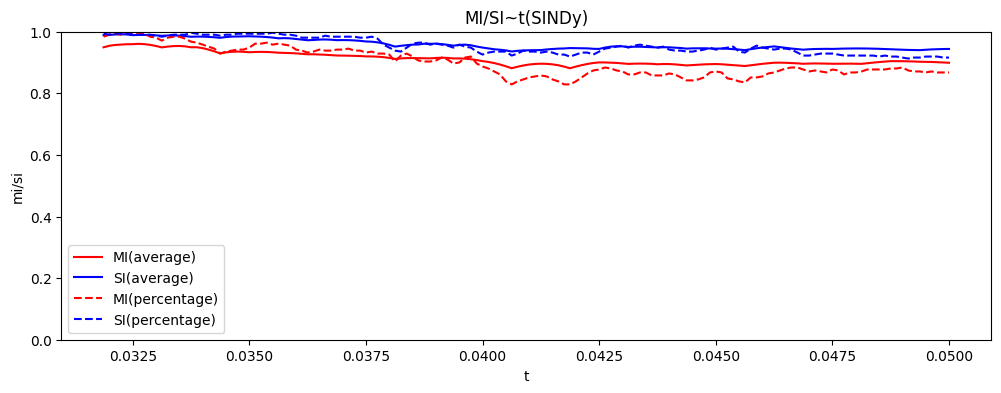

round: 52
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 324.854 1 + -333.934 Vx + 29.095 Vy + -17467.419 t + -58.474 VxVx + 30.970 VyVy + 226479.949 tt + 51.806 VxVy + 8520.945 Vxt + 252.102 Vyt + -0.766 VxVxVy + 1507.056 VxVxt + -686.880 VyVyt + -1345.579 VxVyt + 1047.971 Vx_2 + 490.229 Vy_2 + 136.770 Vx_1 + -48.768 Vy_1 + 229.760 VxVx_2 + 5.936 VxVy_2 + -49971.780 Vxt_2 + 36.394 VyVx_2 + -73.261 VyVy_2 + 592630.824 Vyt_2 + -3.553 tVx_2 + -5316.871 tVy_2 + -2240.256 tt_2 + 3.203 VxVxVx_2 + -862.023 VxVxVy_2 + 1532.378 VxVxt_2 + 314.236 VyVyVx_2 + -123.307 VyVyVy_2 + -186.054 VyVyt_2 + -24965.631 ttVx_2 + 30.897 ttVy_2 + -26.587 ttt_2 + 306796.543 VxVyVx_2 + -4.513 VxVyVy_2 + 4423.167 VxVyt_2 + 3881.707 VxtVx_2 + 0.337 VxtVy_2 + -675.802 Vxtt_2 + 533.754 VytVx_2 + 165.246 VytVy_2 + -41.944 VxVx_1 + 241.970 VxVy_1 + -7633.251 Vxt_1 + -27.810 VyVx_1 + -56.568 VyVy_1 + 97920.761 Vyt_1 + -5.318 tVx_1 + 925.530 tVy_1 + -6666.155 tt_1 + -0.783 VxVxVx_1 + 731.159 VxVxVy_1 + 1518.846 VxVxt_1 + 14.159 

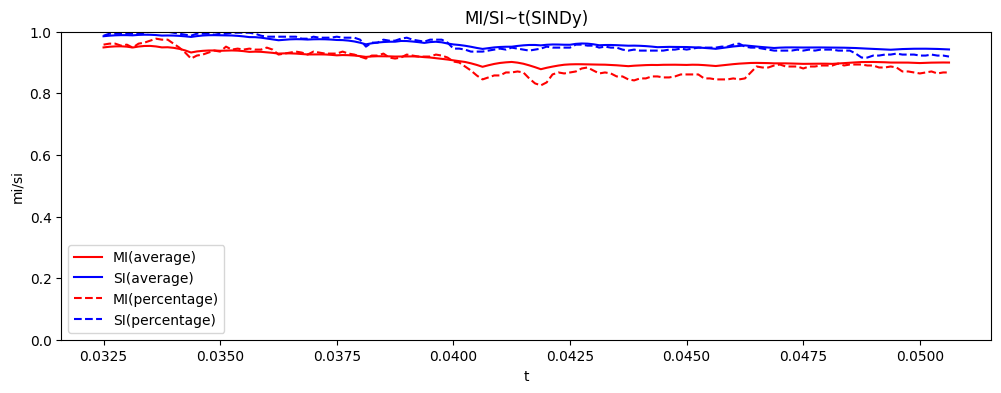

round: 53
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -247.446 1 + -203.770 Vx + 114.638 Vy + 9766.594 t + -33.638 VxVx + 39.119 VyVy + -94070.453 tt + 62.428 VxVy + 5388.386 Vxt + -1750.905 Vyt + 0.447 VxVxVy + 872.755 VxVxt + -895.519 VyVyt + -1493.190 VxVyt + 21.611 Vx_2 + 482.587 Vy_2 + 595.401 Vx_1 + -545.475 Vy_1 + 45.843 VxVx_2 + -213.691 VxVy_2 + -1271.208 Vxt_2 + 3.219 VyVx_2 + -68.295 VyVy_2 + 18572.756 Vyt_2 + -23.199 tVx_2 + -1326.150 tVy_2 + 2795.484 tt_2 + 2.416 VxVxVx_2 + -155.290 VxVxVy_2 + 1480.116 VxVxt_2 + 691.563 VyVyVx_2 + -140.854 VyVyVy_2 + -232.497 VyVyt_2 + -23183.264 ttVx_2 + -20.852 ttVy_2 + -37.334 ttt_2 + 270598.933 VxVyVx_2 + -53.770 VxVyVy_2 + 4691.876 VxVyt_2 + 4860.417 VxtVx_2 + -1.383 VxtVy_2 + 481.275 Vxtt_2 + 775.613 VytVx_2 + 1080.502 VytVy_2 + -182.570 VxVx_1 + 283.513 VxVy_1 + -31745.149 Vxt_1 + -43.377 VyVx_1 + -62.739 VyVy_1 + 403408.240 Vyt_1 + 25.574 tVx_1 + 3716.727 tVy_1 + -7580.641 tt_1 + -1.930 VxVxVx_1 + 1033.040 VxVxVy_1 + 1588.261 VxVxt_1 + -

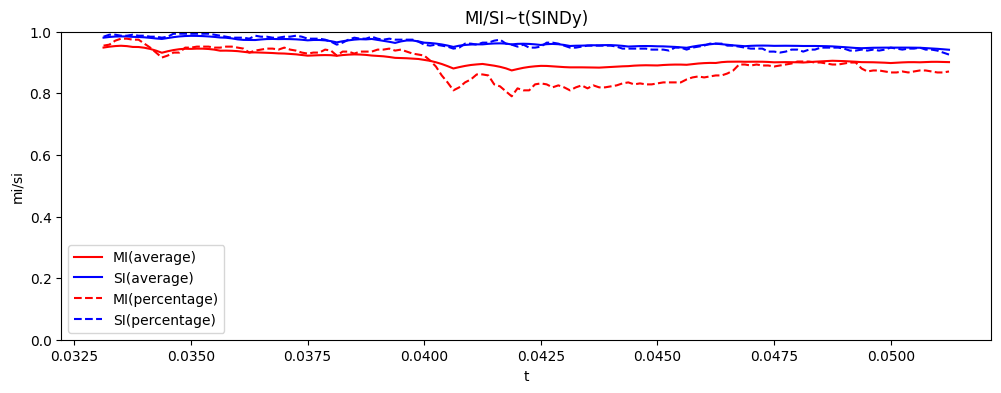

round: 54
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 765.946 1 + -168.326 Vx + 133.327 Vy + -37112.028 t + -36.753 VxVx + 31.334 VyVy + 441889.152 tt + 51.602 VxVy + 4515.056 Vxt + -2204.390 Vyt + 0.746 VxVxVy + 981.089 VxVxt + -652.674 VyVyt + -1164.231 VxVyt + 1700.166 Vx_2 + 805.970 Vy_2 + 1020.989 Vx_1 + -198.352 Vy_1 + 147.921 VxVx_2 + -137.070 VxVy_2 + -78731.811 Vxt_2 + 20.537 VyVx_2 + -57.927 VyVy_2 + 903706.116 Vyt_2 + 12.887 tVx_2 + -3226.243 tVy_2 + 1211.935 tt_2 + 2.019 VxVxVx_2 + -450.604 VxVxVy_2 + 1137.187 VxVxt_2 + -165.574 VyVyVx_2 + -68.271 VyVyVy_2 + -162.877 VyVyt_2 + -38747.120 ttVx_2 + -38.393 ttVy_2 + -22.246 ttt_2 + 453587.154 VxVyVx_2 + -29.495 VxVyVy_2 + 3019.958 VxVyt_2 + 3392.472 VxtVx_2 + -1.278 VxtVy_2 + 949.930 Vxtt_2 + 455.565 VytVx_2 + 702.044 VytVy_2 + -248.076 VxVx_1 + 199.639 VxVy_1 + -49390.089 Vxt_1 + -63.731 VyVx_1 + -33.409 VyVy_1 + 582089.695 Vyt_1 + 51.280 tVx_1 + 5264.593 tVy_1 + -5599.278 tt_1 + -1.744 VxVxVx_1 + 1477.120 VxVxVy_1 + 829.189 VxVxt_

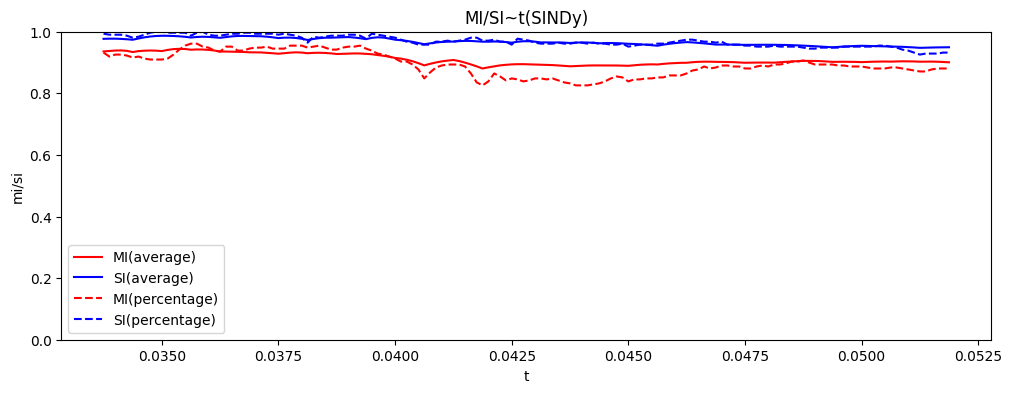

round: 55
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 481.135 1 + -261.288 Vx + 103.461 Vy + -24662.191 t + -46.800 VxVx + 26.815 VyVy + 306895.104 tt + 74.387 VxVy + 6658.257 Vxt + -1548.187 Vyt + 0.138 VxVxVy + 1204.481 VxVxt + -567.074 VyVyt + -1785.067 VxVyt + 2517.536 Vx_2 + 1126.498 Vy_2 + 1293.026 Vx_1 + 21.506 Vy_1 + 140.990 VxVx_2 + -300.647 VxVy_2 + -117958.564 Vxt_2 + 28.534 VyVx_2 + -58.369 VyVy_2 + 1366834.860 Vyt_2 + -69.064 tVx_2 + -3696.548 tVy_2 + 5036.905 tt_2 + 1.882 VxVxVx_2 + -757.993 VxVxVy_2 + 1173.269 VxVxt_2 + 1801.737 VyVyVx_2 + -87.082 VyVyVy_2 + -223.439 VyVyt_2 + -53915.709 ttVx_2 + 7.076 ttVy_2 + -30.136 ttt_2 + 632461.076 VxVyVx_2 + -68.894 VxVyVy_2 + 3121.366 VxVyt_2 + 4760.061 VxtVx_2 + -1.431 VxtVy_2 + -235.388 Vxtt_2 + 598.158 VytVx_2 + 1500.516 VytVy_2 + -447.561 VxVx_1 + 393.206 VxVy_1 + -63455.190 Vxt_1 + -111.040 VyVx_1 + -85.300 VyVy_1 + 758050.005 Vyt_1 + 62.364 tVx_1 + 9780.106 tVy_1 + -10424.054 tt_1 + -3.313 VxVxVx_1 + 2599.265 VxVxVy_1 + 2092.017 

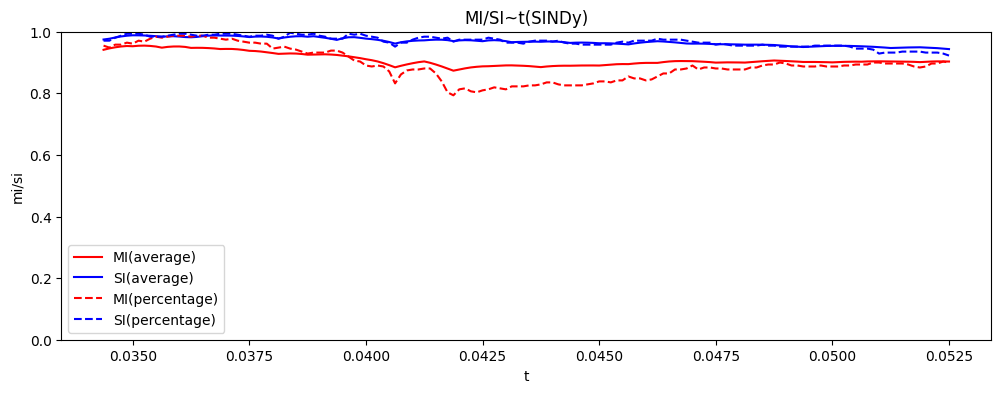

round: 56
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1274.538 1 + -178.339 Vx + 165.842 Vy + -61091.474 t + 13.111 VxVx + 27.734 VyVy + 719631.346 tt + 92.884 VxVy + 4832.466 Vxt + -2904.678 Vyt + 0.316 VxVxVy + -114.940 VxVxt + -558.807 VyVyt + -2142.026 VxVyt + 2116.476 Vx_2 + 4.090 Vy_2 + 283.413 Vx_1 + -470.245 Vy_1 + 4.412 VxVx_2 + -387.859 VxVy_2 + -97715.989 Vxt_2 + -1.330 VyVx_2 + -46.974 VyVy_2 + 1117824.124 Vyt_2 + -110.068 tVx_2 + -888.459 tVy_2 + 6948.682 tt_2 + 1.495 VxVxVx_2 + -145.794 VxVxVy_2 + 851.162 VxVxt_2 + 2625.701 VyVyVx_2 + 101.468 VyVyVy_2 + -142.734 VyVyt_2 + -357.605 ttVx_2 + 58.080 ttVy_2 + -24.370 ttt_2 + 848.558 VxVyVx_2 + -49.998 VxVyVy_2 + -1032.787 VxVyt_2 + 2922.277 VxtVx_2 + 0.077 VxtVy_2 + -1378.041 Vxtt_2 + 503.634 VytVx_2 + 1238.837 VytVy_2 + -172.378 VxVx_1 + 459.241 VxVy_1 + -14133.723 Vxt_1 + -57.619 VyVx_1 + -58.256 VyVy_1 + 165252.075 Vyt_1 + -2.699 tVx_1 + 3801.842 tVy_1 + -11601.968 tt_1 + -2.447 VxVxVx_1 + 1395.777 VxVxVy_1 + 1516.574 VxVxt_1 + 

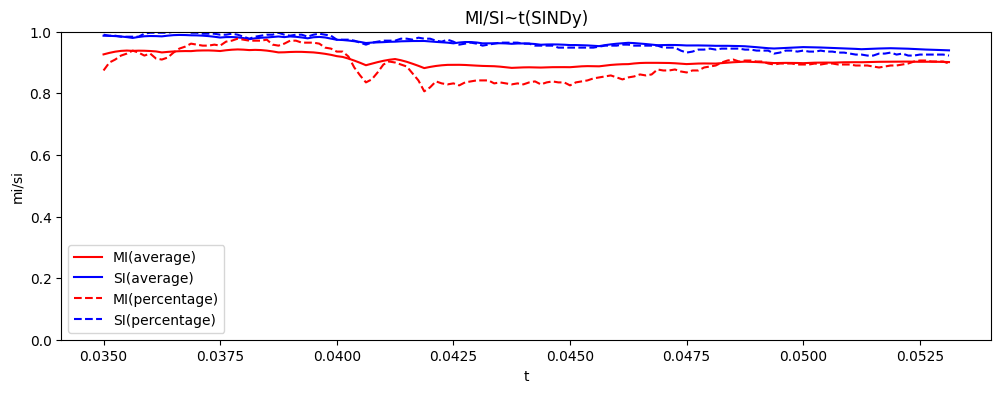

round: 57
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 542.574 1 + -78.623 Vx + 122.885 Vy + -27371.484 t + 28.094 VxVx + 10.791 VyVy + 336312.919 tt + 85.305 VxVy + 2507.681 Vxt + -2091.995 Vyt + 0.824 VxVxVy + -484.670 VxVxt + -175.429 VyVyt + -1922.830 VxVyt + 2365.081 Vx_2 + 1454.666 Vy_2 + 1102.153 Vx_1 + -79.086 Vy_1 + 165.247 VxVx_2 + -219.754 VxVy_2 + -109557.707 Vxt_2 + 44.150 VyVx_2 + -25.779 VyVy_2 + 1253659.699 Vyt_2 + -49.397 tVx_2 + -3923.458 tVy_2 + 3633.433 tt_2 + 1.759 VxVxVx_2 + -1031.533 VxVxVy_2 + 376.061 VxVxt_2 + 1291.237 VyVyVx_2 + -205.473 VyVyVy_2 + -116.109 VyVyt_2 + -65741.251 ttVx_2 + -6.277 ttVy_2 + -22.916 ttt_2 + 731721.757 VxVyVx_2 + -48.390 VxVyVy_2 + 5112.064 VxVyt_2 + 2289.141 VxtVx_2 + 0.045 VxtVy_2 + -7.307 Vxtt_2 + 469.167 VytVx_2 + 1179.266 VytVy_2 + -471.006 VxVx_1 + 286.170 VxVy_1 + -50633.177 Vxt_1 + -116.943 VyVx_1 + -63.564 VyVy_1 + 571986.014 Vyt_1 + -22.669 tVx_1 + 9858.433 tVy_1 + -7690.982 tt_1 + -1.931 VxVxVx_1 + 2562.007 VxVxVy_1 + 1534.848 Vx

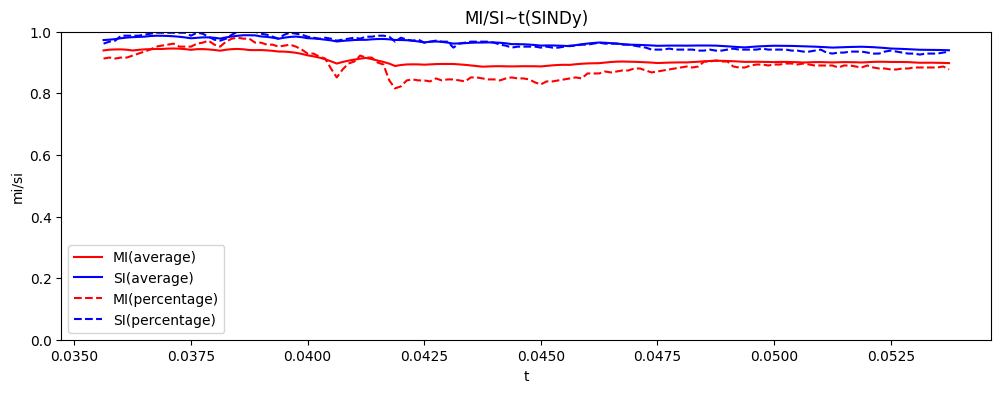

round: 58
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 782.161 1 + 8.154 Vx + 233.114 Vy + -38051.326 t + 23.391 VxVx + 9.131 VyVy + 453147.518 tt + 89.819 VxVy + 584.655 Vxt + -4468.534 Vyt + 1.100 VxVxVy + -413.860 VxVxt + -114.447 VyVyt + -1992.942 VxVyt + 1296.839 Vx_2 + 631.542 Vy_2 + 2452.532 Vx_1 + -346.432 Vy_1 + 64.244 VxVx_2 + -527.362 VxVy_2 + -61518.475 Vxt_2 + 15.755 VyVx_2 + -24.852 VyVy_2 + 719448.653 Vyt_2 + -142.332 tVx_2 + -1885.731 tVy_2 + 10035.508 tt_2 + 0.672 VxVxVx_2 + -448.790 VxVxVy_2 + 307.433 VxVxt_2 + 3231.198 VyVyVx_2 + 263.999 VyVyVy_2 + -77.008 VyVyt_2 + -30466.578 ttVx_2 + 125.820 ttVy_2 + -14.002 ttt_2 + 355597.295 VxVyVx_2 + -28.254 VxVyVy_2 + -4522.786 VxVyt_2 + 1382.401 VxtVx_2 + 1.605 VxtVy_2 + -2862.154 Vxtt_2 + 289.906 VytVx_2 + 851.004 VytVy_2 + -366.682 VxVx_1 + 370.844 VxVy_1 + -109560.467 Vxt_1 + -79.348 VyVx_1 + -38.734 VyVy_1 + 1206732.572 Vyt_1 + 112.738 tVx_1 + 7658.241 tVy_1 + -9136.618 tt_1 + -0.968 VxVxVx_1 + 1745.068 VxVxVy_1 + 985.690 VxVxt_

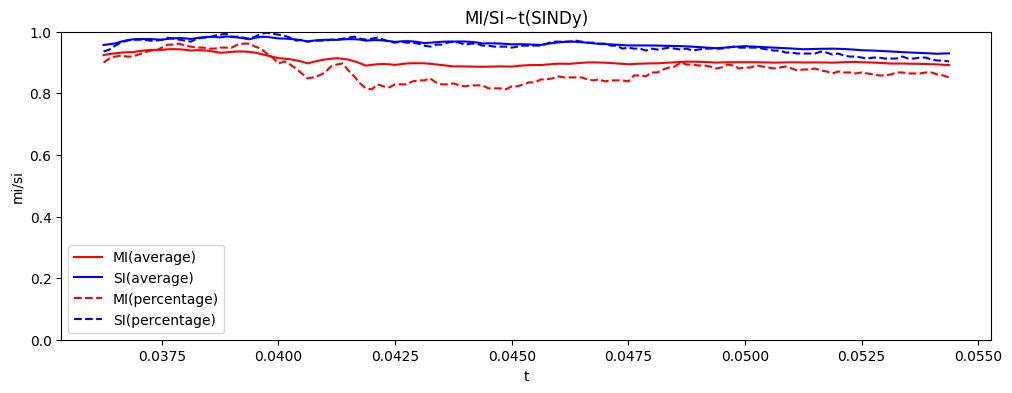

round: 59
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 694.517 1 + 173.070 Vy + -34208.602 t + 14.196 VxVx + 6.939 VyVy + 411595.642 tt + 53.037 VxVy + 890.185 Vxt + -3229.001 Vyt + 0.622 VxVxVy + -183.279 VxVxt + -79.623 VyVyt + -1275.971 VxVyt + 2538.966 Vx_2 + 1525.883 Vy_2 + 3301.369 Vx_1 + -52.307 Vy_1 + 232.962 VxVx_2 + -221.969 VxVy_2 + -117246.643 Vxt_2 + 56.159 VyVx_2 + -39.324 VyVy_2 + 1335348.025 Vyt_2 + -25.659 tVx_2 + -5130.715 tVy_2 + 3855.023 tt_2 + -0.267 VxVxVx_2 + -1207.737 VxVxVy_2 + 632.687 VxVxt_2 + 796.830 VyVyVx_2 + 52.428 VyVyVy_2 + -29.495 VyVyt_2 + -66300.421 ttVx_2 + 5.919 ttVy_2 + -18.035 ttt_2 + 712300.650 VxVyVx_2 + -23.417 VxVyVy_2 + -488.500 VxVyt_2 + 411.581 VxtVx_2 + 2.191 VxtVy_2 + -501.841 Vxtt_2 + 378.737 VytVx_2 + 765.954 VytVy_2 + -146.298 VxVx_1 + 180.497 VxVy_1 + -143971.181 Vxt_1 + -37.399 VyVx_1 + -56.869 VyVy_1 + 1552127.210 Vyt_1 + 37.843 tVx_1 + 2695.858 tVy_1 + -5411.950 tt_1 + 769.542 VxVxVy_1 + 1425.269 VxVxt_1 + -1007.252 VyVyVx_1 + -133.891 V

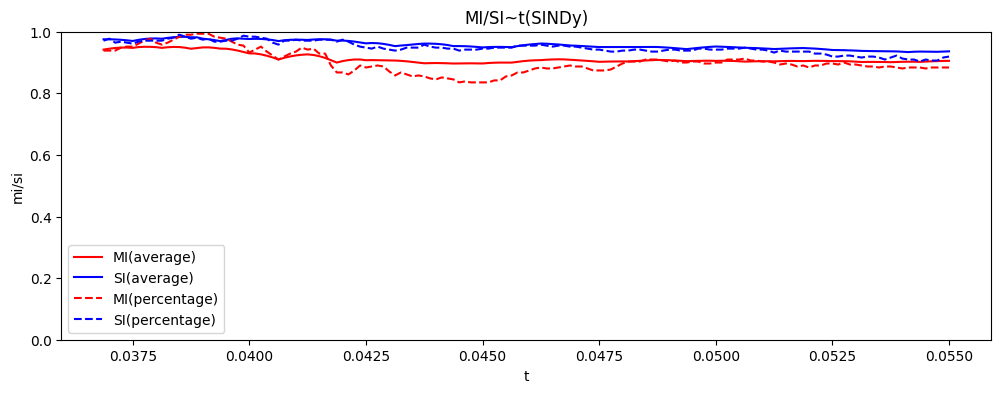

round: 60
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1175.108 1 + 78.637 Vx + 183.525 Vy + -54173.370 t + 19.365 VxVx + -6.422 VyVy + 615776.255 tt + 5.134 VxVy + -875.640 Vxt + -3422.204 Vyt + 0.770 VxVxVy + -305.133 VxVxt + 202.599 VyVyt + -209.568 VxVyt + 3182.891 Vx_2 + 595.268 Vy_2 + 804.896 Vx_1 + -462.673 Vy_1 + 208.732 VxVx_2 + -183.089 VxVy_2 + -143392.033 Vxt_2 + 50.247 VyVx_2 + -29.639 VyVy_2 + 1595221.458 Vyt_2 + 0.230 tVx_2 + -4740.313 tVy_2 + 3054.790 tt_2 + -0.031 VxVxVx_2 + -1098.050 VxVxVy_2 + 454.535 VxVxt_2 + 167.812 VyVyVx_2 + 23.212 VyVyVy_2 + -34.172 VyVyt_2 + -27532.695 ttVx_2 + -49.628 ttVy_2 + -12.089 ttt_2 + 312081.401 VxVyVx_2 + -16.751 VxVyVy_2 + 206.759 VxVyt_2 + 559.769 VxtVx_2 + 1.323 VxtVy_2 + 820.003 Vxtt_2 + 256.925 VytVx_2 + 581.558 VytVy_2 + -264.264 VxVx_1 + 35.780 VxVy_1 + -36891.454 Vxt_1 + -75.626 VyVx_1 + -35.322 VyVy_1 + 416083.034 Vyt_1 + 53.938 tVx_1 + 5212.506 tVy_1 + -2238.921 tt_1 + -1.477 VxVxVx_1 + 1607.606 VxVxVy_1 + 918.477 VxVxt_1 + -1401.

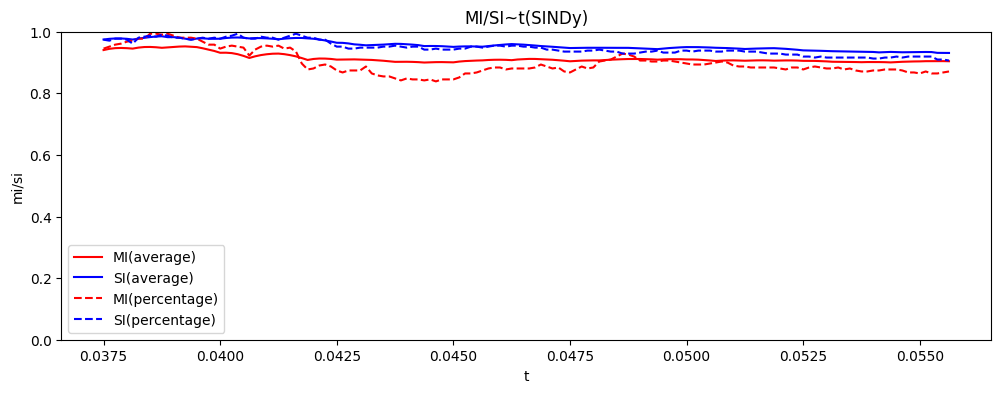

round: 61
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 360.685 1 + 87.236 Vx + 129.360 Vy + -19613.654 t + 38.814 VxVx + -3.708 VyVy + 251938.380 tt + 34.795 VxVy + -1111.900 Vxt + -2401.253 Vyt + 1.595 VxVxVy + -723.128 VxVxt + 152.371 VyVyt + -805.117 VxVyt + 1939.695 Vx_2 + 2259.474 Vy_2 + 456.007 Vx_1 + 67.342 Vy_1 + 66.579 VxVx_2 + -189.950 VxVy_2 + -89963.568 Vxt_2 + 20.611 VyVx_2 + 8.114 VyVy_2 + 1025297.567 Vyt_2 + -94.651 tVx_2 + -1691.258 tVy_2 + 3305.452 tt_2 + -1.127 VxVxVx_2 + -467.517 VxVxVy_2 + -331.932 VxVxt_2 + 2140.479 VyVyVx_2 + 10.739 VyVyVy_2 + 47.083 VyVyt_2 + -98753.234 ttVx_2 + 30.941 ttVy_2 + -5.587 ttt_2 + 1065565.926 VxVyVx_2 + -34.259 VxVyVy_2 + 748.408 VxVyt_2 + -1125.103 VxtVx_2 + 0.638 VxtVy_2 + -898.461 Vxtt_2 + 137.384 VytVx_2 + 911.708 VytVy_2 + -205.660 VxVx_1 + 275.713 VxVy_1 + -21198.827 Vxt_1 + -58.094 VyVx_1 + -97.415 VyVy_1 + 243379.896 Vyt_1 + 61.998 tVx_1 + 3641.879 tVy_1 + -6991.448 tt_1 + -2.059 VxVxVx_1 + 1154.418 VxVxVy_1 + 2108.099 VxVxt_1 + -162

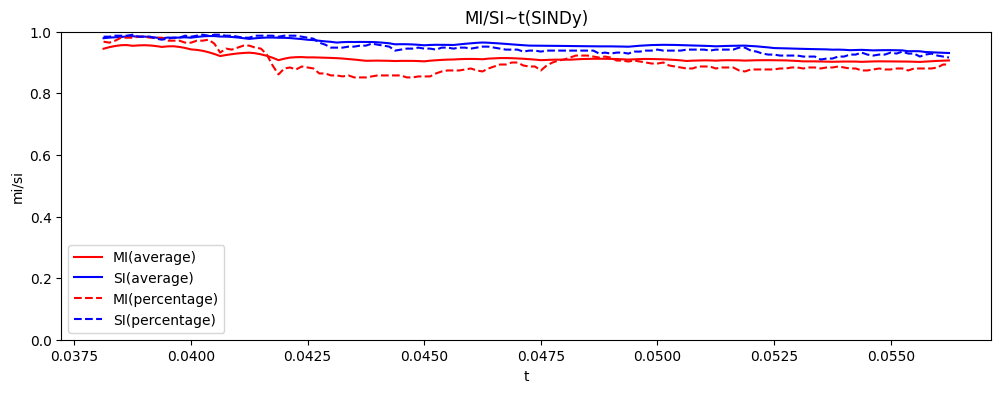

round: 62
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 10.510 1 + 181.047 Vx + 135.534 Vy + -3951.926 t + 68.669 VxVx + 19.480 VyVy + 79453.992 tt + 26.206 VxVy + -3047.289 Vxt + -2412.698 Vyt + -1302.580 VxVxt + -304.293 VyVyt + -637.777 VxVyt + 1497.138 Vx_2 + 734.391 Vy_2 + 1548.280 Vx_1 + 327.295 Vy_1 + 217.006 VxVx_2 + -125.861 VxVy_2 + -70849.147 Vxt_2 + 52.227 VyVx_2 + -71.155 VyVy_2 + 820506.324 Vyt_2 + -94.391 tVx_2 + -4640.340 tVy_2 + 1853.591 tt_2 + 0.336 VxVxVx_2 + -1083.179 VxVxVy_2 + 1243.747 VxVxt_2 + 2110.811 VyVyVx_2 + -15.488 VyVyVy_2 + 7.372 VyVyt_2 + -32807.234 ttVx_2 + 46.567 ttVy_2 + -6.969 ttt_2 + 361664.376 VxVyVx_2 + 64.691 VxVyVy_2 + 953.811 VxVyt_2 + -226.374 VxtVx_2 + 0.037 VxtVy_2 + -1097.268 Vxtt_2 + 140.518 VytVx_2 + -1047.112 VytVy_2 + -53.568 VxVx_1 + 305.417 VxVy_1 + -67122.894 Vxt_1 + -20.508 VyVx_1 + -67.502 VyVy_1 + 720191.438 Vyt_1 + 1026.482 tVy_1 + -7559.721 tt_1 + -1.287 VxVxVx_1 + 489.218 VxVxVy_1 + 1518.703 VxVxt_1 + -302.759 VyVyVx_1 + -283.449 VyVy

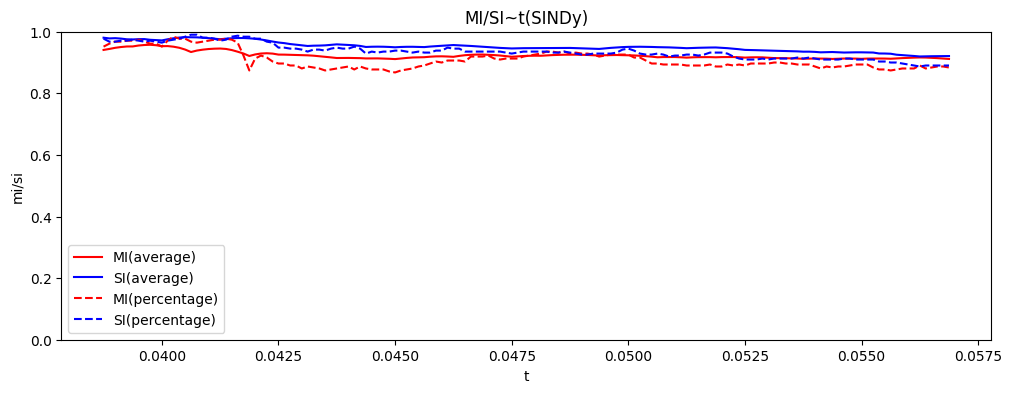

round: 63
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 53.577 1 + 147.411 Vx + 106.948 Vy + -5278.658 t + 33.791 VxVx + -1.186 VyVy + 88618.063 tt + -3.863 VxVy + -2341.862 Vxt + -1708.947 Vyt + -0.616 VxVxVy + -600.851 VxVxt + 114.468 VyVyt + -16.202 VxVyt + 281.889 Vx_2 + -2322.377 Vy_2 + -216.393 Vx_1 + 64.949 Vy_1 + 227.906 VxVx_2 + 50.327 VxVy_2 + -17861.462 Vxt_2 + 36.043 VyVx_2 + -34.031 VyVy_2 + 251686.437 Vyt_2 + -41.715 tVx_2 + -4928.188 tVy_2 + -1893.542 tt_2 + 0.978 VxVxVx_2 + -778.209 VxVxVy_2 + 484.787 VxVxt_2 + 1064.093 VyVyVx_2 + -233.769 VyVyVy_2 + -39.052 VyVyt_2 + 93965.325 ttVx_2 + -30.006 ttVy_2 + 0.684 ttt_2 + -939439.128 VxVyVx_2 + 14.735 VxVyVy_2 + 5358.725 VxVyt_2 + 718.351 VxtVx_2 + 0.284 VxtVy_2 + 444.063 Vxtt_2 + -21.107 VytVx_2 + -16.862 VytVy_2 + -162.416 VxVx_1 + 47.490 VxVy_1 + 7528.143 Vxt_1 + -58.332 VyVx_1 + -59.431 VyVy_1 + -59889.506 Vyt_1 + -50.836 tVx_1 + 3004.396 tVy_1 + -2343.691 tt_1 + -1.217 VxVxVx_1 + 1200.839 VxVxVy_1 + 1331.875 VxVxt_1 + 809.447 V

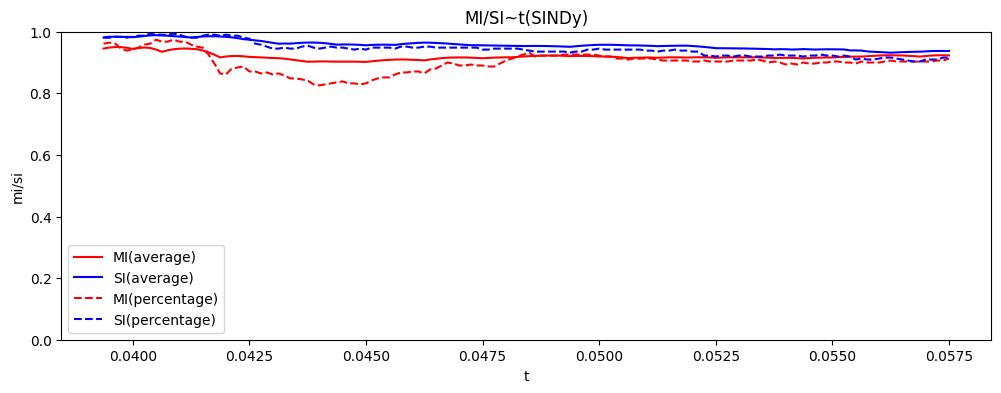

round: 64
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -532.697 1 + 226.836 Vx + 156.146 Vy + 18970.741 t + 52.535 VxVx + 14.452 VyVy + -159870.856 tt + 11.740 VxVy + -3982.544 Vxt + -2737.265 Vyt + -973.282 VxVxt + -204.912 VyVyt + -286.046 VxVyt + -1270.161 Vx_2 + -1549.861 Vy_2 + -640.899 Vx_1 + 340.525 Vy_1 + 307.443 VxVx_2 + -152.968 VxVy_2 + 43752.040 Vxt_2 + 66.115 VyVx_2 + -53.500 VyVy_2 + -356006.048 Vyt_2 + -46.478 tVx_2 + -6582.844 tVy_2 + 2130.636 tt_2 + 1.064 VxVxVx_2 + -1388.452 VxVxVy_2 + 890.669 VxVxt_2 + 1079.172 VyVyVx_2 + -6.370 VyVyVy_2 + 13.631 VyVyt_2 + 63274.578 ttVx_2 + 4.803 ttVy_2 + -3.589 ttt_2 + -637604.143 VxVyVx_2 + 69.621 VxVyVy_2 + 1042.785 VxVyt_2 + -384.759 VxtVx_2 + 1.575 VxtVy_2 + -226.624 Vxtt_2 + 67.128 VytVx_2 + -1149.822 VytVy_2 + -138.761 VxVx_1 + 78.751 VxVy_1 + 27008.075 Vxt_1 + -39.150 VyVx_1 + -92.769 VyVy_1 + -276903.619 Vyt_1 + -51.936 tVx_1 + 2882.099 tVy_1 + -2834.247 tt_1 + -1.319 VxVxVx_1 + 858.416 VxVxVy_1 + 1981.922 VxVxt_1 + 730.650 VyVyVx

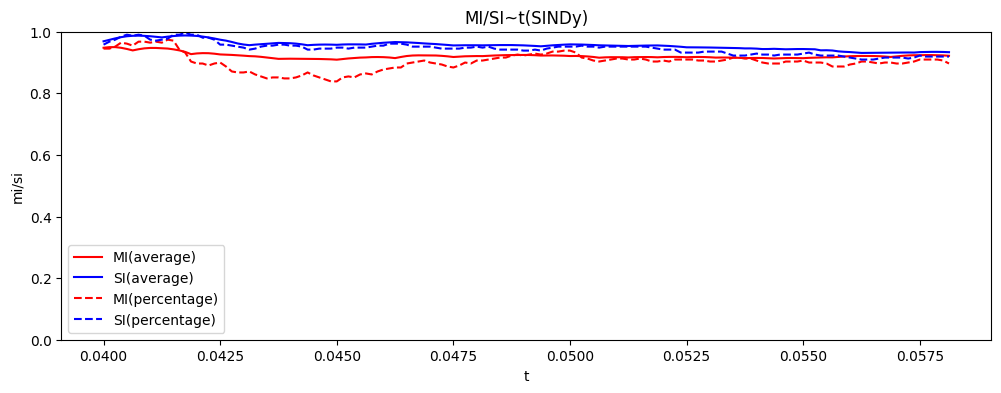

round: 65
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -921.128 1 + 233.287 Vx + 141.451 Vy + 35104.564 t + 59.428 VxVx + 12.873 VyVy + -325779.736 tt + -3.325 VxVy + -4031.941 Vxt + -2401.860 Vyt + -0.925 VxVxVy + -1096.671 VxVxt + -178.695 VyVyt + -29.675 VxVyt + -1821.766 Vx_2 + -1848.015 Vy_2 + 1331.269 Vx_1 + 84.161 Vy_1 + 132.933 VxVx_2 + -87.112 VxVy_2 + 67706.038 Vxt_2 + 27.137 VyVx_2 + -60.152 VyVy_2 + -612059.944 Vyt_2 + -9.392 tVx_2 + -3025.646 tVy_2 + 914.168 tt_2 + 0.773 VxVxVx_2 + -599.116 VxVxVy_2 + 1012.805 VxVxt_2 + 389.741 VyVyVx_2 + 23.548 VyVyVy_2 + -65.093 VyVyt_2 + 72624.615 ttVx_2 + -10.826 ttVy_2 + 6.247 ttt_2 + -704402.219 VxVyVx_2 + 65.206 VxVyVy_2 + 245.723 VxVyt_2 + 1199.193 VxtVx_2 + 0.695 VxtVy_2 + 79.067 Vxtt_2 + -126.382 VytVx_2 + -1038.131 VytVy_2 + -18.638 VxVx_1 + 113.153 VxVy_1 + -53346.273 Vxt_1 + -17.236 VyVx_1 + -77.634 VyVy_1 + 531777.073 Vyt_1 + -98.874 tVx_1 + 397.237 tVy_1 + -3610.976 tt_1 + -0.786 VxVxVx_1 + 423.443 VxVxVy_1 + 1711.058 VxVxt_1 + 178

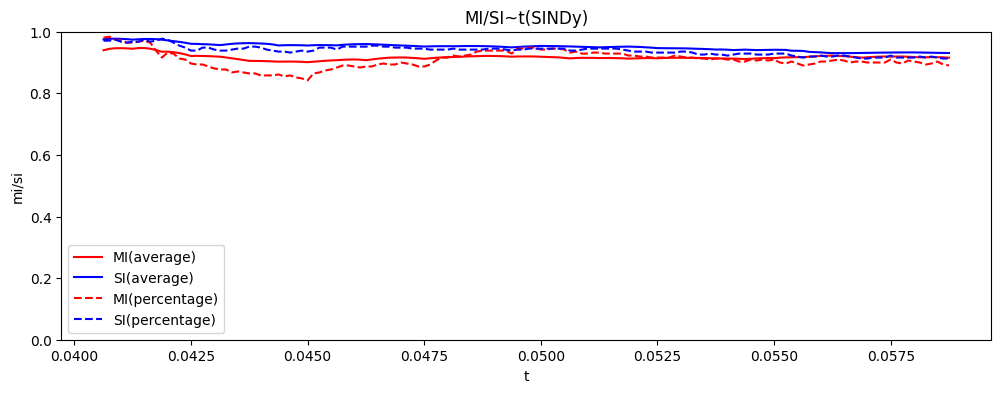

round: 66
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -355.403 1 + 311.878 Vx + 42.134 Vy + 12635.014 t + 75.713 VxVx + 25.818 VyVy + -105395.865 tt + -11.014 VxVy + -5423.488 Vxt + -341.770 Vyt + -1.043 VxVxVy + -1379.305 VxVxt + -423.016 VyVyt + 141.190 VxVyt + -3138.761 Vx_2 + -2670.826 Vy_2 + -1002.864 Vx_1 + -207.323 Vy_1 + 146.476 VxVx_2 + 107.742 VxVy_2 + 119702.630 Vxt_2 + 35.223 VyVx_2 + -80.773 VyVy_2 + -1120260.749 Vyt_2 + -29.168 tVx_2 + -3091.280 tVy_2 + -3122.725 tt_2 + 1.080 VxVxVx_2 + -725.825 VxVxVy_2 + 1385.174 VxVxt_2 + 696.824 VyVyVx_2 + -156.122 VyVyVy_2 + -11.682 VyVyt_2 + 103418.958 ttVx_2 + 40.784 ttVy_2 + 0.847 ttt_2 + -989271.125 VxVyVx_2 + 92.478 VxVyVy_2 + 3987.534 VxVyt_2 + 167.125 VxtVx_2 + 0.972 VxtVy_2 + -856.750 Vxtt_2 + -26.201 VytVx_2 + -1531.682 VytVy_2 + -74.158 VxVx_1 + -92.643 VxVy_1 + 37369.298 Vxt_1 + -6.926 VyVx_1 + -24.740 VyVy_1 + -341990.865 Vyt_1 + -171.670 tVx_1 + 1419.328 tVy_1 + 320.975 tt_1 + -0.492 VxVxVx_1 + 196.473 VxVxVy_1 + 650.857 VxVxt

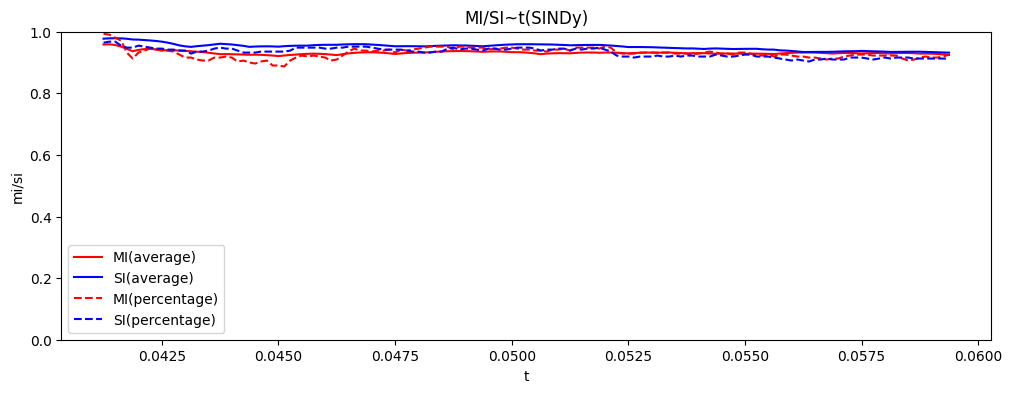

round: 67
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -526.870 1 + 261.332 Vx + 62.484 Vy + 19918.833 t + 77.595 VxVx + 39.332 VyVy + -182100.716 tt + -19.219 VxVy + -4385.672 Vxt + -726.387 Vyt + -0.985 VxVxVy + -1399.748 VxVxt + -711.984 VyVyt + 247.859 VxVyt + -2634.569 Vx_2 + -2871.999 Vy_2 + -2104.880 Vx_1 + 211.111 Vy_1 + -3.616 VxVx_2 + 117.091 VxVy_2 + 101307.949 Vxt_2 + 10.208 VyVx_2 + -121.310 VyVy_2 + -955609.303 Vyt_2 + -21.686 tVx_2 + -226.595 tVy_2 + -3168.650 tt_2 + 0.925 VxVxVx_2 + -253.620 VxVxVy_2 + 2209.378 VxVxt_2 + 585.864 VyVyVx_2 + -152.032 VyVyVy_2 + -37.661 VyVyt_2 + 111575.781 ttVx_2 + 51.240 ttVy_2 + -5.645 ttt_2 + -1070918.817 VxVyVx_2 + 142.452 VxVyVy_2 + 3883.885 VxVyt_2 + 614.304 VxtVx_2 + 1.737 VxtVy_2 + -1149.468 Vxtt_2 + 105.605 VytVx_2 + -2540.124 VytVy_2 + -119.705 VxVx_1 + -37.066 VxVy_1 + 81545.325 Vxt_1 + -13.800 VyVx_1 + -12.557 VyVy_1 + -780525.224 Vyt_1 + -195.019 tVx_1 + 2356.535 tVy_1 + -899.830 tt_1 + 0.286 VxVxVx_1 + 315.245 VxVxVy_1 + 491.223 Vx

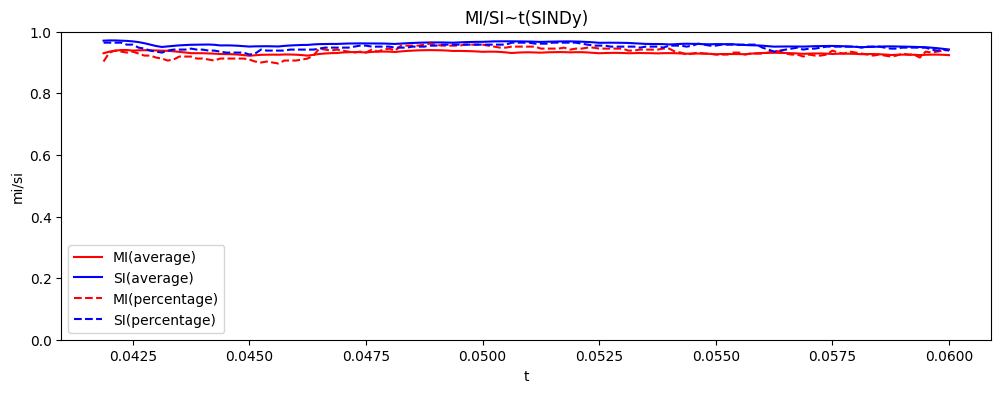

round: 68
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -489.514 1 + 248.832 Vx + 11.797 Vy + 19024.673 t + 66.224 VxVx + 22.787 VyVy + -178281.551 tt + -2.774 VxVy + -4094.165 Vxt + 254.893 Vyt + -0.920 VxVxVy + -1214.360 VxVxt + -381.665 VyVyt + -55.048 VxVyt + -3834.718 Vx_2 + -3913.826 Vy_2 + -2121.166 Vx_1 + -849.444 Vy_1 + -98.873 VxVx_2 + 115.029 VxVy_2 + 147246.950 Vxt_2 + -13.495 VyVx_2 + -73.590 VyVy_2 + -1390485.009 Vyt_2 + 11.694 tVx_2 + 1556.385 tVy_2 + -3087.686 tt_2 + 1.004 VxVxVx_2 + 183.817 VxVxVy_2 + 1253.196 VxVxt_2 + -28.030 VyVyVx_2 + -46.041 VyVyVy_2 + -36.942 VyVyt_2 + 149764.298 ttVx_2 + 28.335 ttVy_2 + 1.493 ttt_2 + -1416462.485 VxVyVx_2 + 76.908 VxVyVy_2 + 1701.257 VxVyt_2 + 665.939 VxtVx_2 + 0.776 VxtVy_2 + -661.032 Vxtt_2 + -33.892 VytVx_2 + -1225.333 VytVy_2 + -12.311 VxVx_1 + -42.817 VxVy_1 + 81892.983 Vxt_1 + 5.188 VyVx_1 + -23.438 VyVy_1 + -780856.260 Vyt_1 + -160.901 tVx_1 + 177.680 tVy_1 + -742.283 tt_1 + -0.595 VxVxVx_1 + -33.255 VxVxVy_1 + 683.451 VxVxt_1 + 

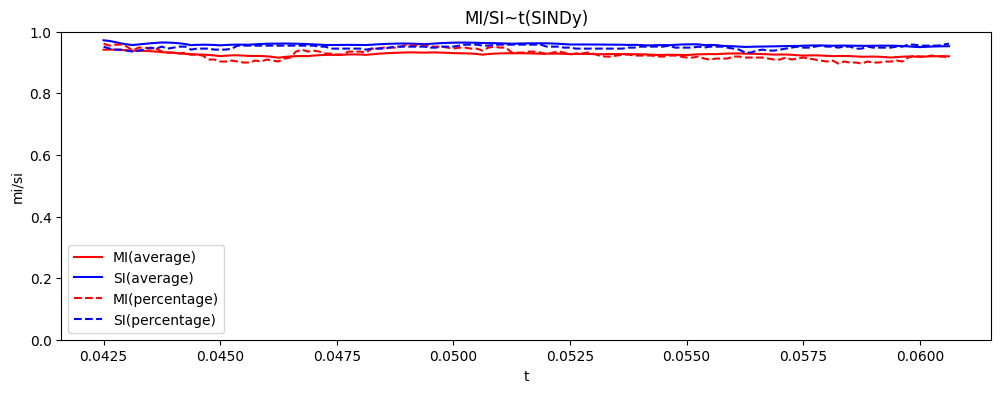

round: 69
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -634.032 1 + 209.192 Vx + -29.296 Vy + 23897.298 t + 71.417 VxVx + 31.469 VyVy + -218743.100 tt + -30.833 VxVy + -3290.053 Vxt + 1054.661 Vyt + -0.395 VxVxVy + -1330.313 VxVxt + -560.058 VyVyt + 482.493 VxVyt + -3136.158 Vx_2 + -2868.270 Vy_2 + -2983.993 Vx_1 + 95.186 Vy_1 + -95.545 VxVx_2 + 10.205 VxVy_2 + 117950.311 Vxt_2 + -5.069 VyVx_2 + -73.471 VyVy_2 + -1088723.782 Vyt_2 + 78.944 tVx_2 + 1771.373 tVy_2 + -1113.098 tt_2 + 66.066 VxVxVy_2 + 1283.138 VxVxt_2 + -1430.353 VyVyVx_2 + -62.052 VyVyVy_2 + 20.117 VyVyt_2 + 108922.494 ttVx_2 + -57.021 ttVy_2 + -5.964 ttt_2 + -1021419.108 VxVyVx_2 + 106.692 VxVyVy_2 + 2291.792 VxVyt_2 + -493.586 VxtVx_2 + 0.585 VxtVy_2 + 1006.139 Vxtt_2 + 123.227 VytVx_2 + -1864.688 VytVy_2 + -129.264 VxVx_1 + 125.063 VxVy_1 + 114682.966 Vxt_1 + -18.712 VyVx_1 + -64.035 VyVy_1 + -1089617.025 Vyt_1 + -121.611 tVx_1 + 2267.927 tVy_1 + -4083.966 tt_1 + -0.392 VxVxVx_1 + 371.998 VxVxVy_1 + 1491.162 VxVxt_1 + 2280.3

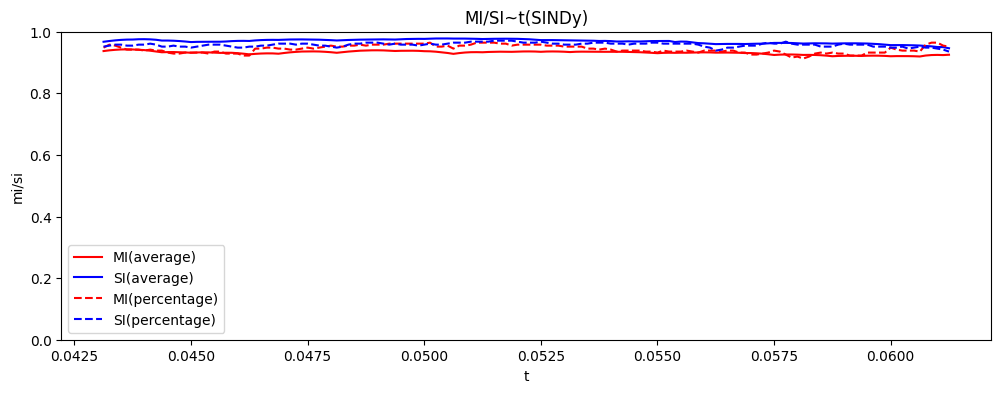

round: 70
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -691.701 1 + 267.420 Vx + 18.266 Vy + 27160.353 t + 76.381 VxVx + 27.256 VyVy + -259085.937 tt + -13.112 VxVy + -4272.472 Vxt + 192.759 Vyt + -0.786 VxVxVy + -1394.776 VxVxt + -501.746 VyVyt + 113.087 VxVyt + -4703.240 Vx_2 + -3485.416 Vy_2 + -4847.959 Vx_1 + -855.942 Vy_1 + 82.305 VxVx_2 + -81.879 VxVy_2 + 178574.331 Vxt_2 + 24.023 VyVx_2 + -74.459 VyVy_2 + -1670030.420 Vyt_2 + 9.453 tVx_2 + -1714.014 tVy_2 + 455.447 tt_2 + 0.989 VxVxVx_2 + -494.704 VxVxVy_2 + 1344.440 VxVxt_2 + -22.748 VyVyVx_2 + 40.463 VyVyVy_2 + -20.335 VyVyt_2 + 131698.098 ttVx_2 + -0.662 ttt_2 + -1230874.645 VxVyVx_2 + 89.618 VxVyVy_2 + 272.444 VxVyt_2 + 346.497 VxtVx_2 + 0.701 VxtVy_2 + -89.080 Vxtt_2 + 8.158 VytVx_2 + -1565.123 VytVy_2 + -44.385 VxVx_1 + -21.590 VxVy_1 + 184906.250 Vxt_1 + 8.563 VyVx_1 + 3.931 VyVy_1 + -1744623.679 Vyt_1 + -127.719 tVx_1 + 785.089 tVy_1 + -1298.642 tt_1 + -0.915 VxVxVx_1 + -98.615 VxVxVy_1 + 173.411 VxVxt_1 + 2373.000 VyVyVx_1 + 5

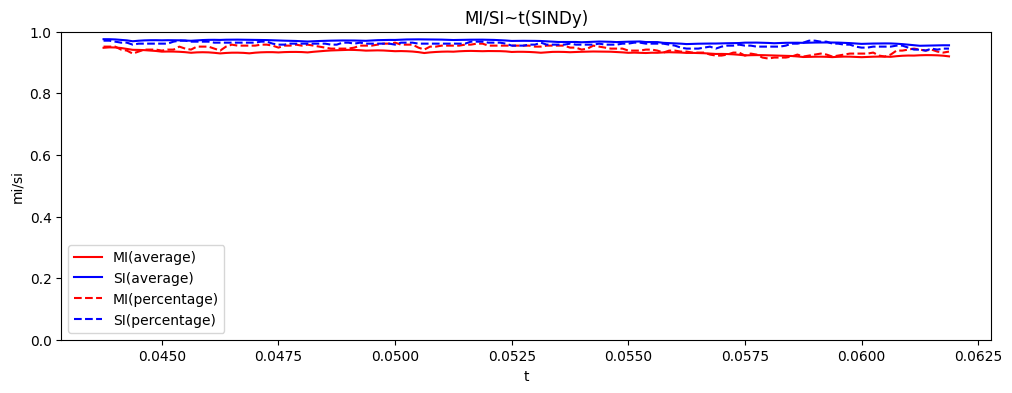

round: 71
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -436.993 1 + 227.488 Vx + -24.405 Vy + 16592.288 t + 79.501 VxVx + 11.985 VyVy + -150899.383 tt + -7.020 VxVy + -3648.132 Vxt + 868.847 Vyt + -0.555 VxVxVy + -1445.136 VxVxt + -205.911 VyVyt + 26.214 VxVyt + -3929.556 Vx_2 + -2212.755 Vy_2 + -3055.525 Vx_1 + 246.465 Vy_1 + 40.977 VxVx_2 + -105.956 VxVy_2 + 146941.163 Vxt_2 + 19.553 VyVx_2 + -29.904 VyVy_2 + -1350334.158 Vyt_2 + 1.754 tVx_2 + -1101.433 tVy_2 + 1030.858 tt_2 + 1.537 VxVxVx_2 + -427.497 VxVxVy_2 + 510.085 VxVxt_2 + 131.861 VyVyVx_2 + 160.113 VyVyVy_2 + 19.765 VyVyt_2 + 82708.554 ttVx_2 + -1.271 ttVy_2 + -2.962 ttt_2 + -762996.326 VxVyVx_2 + 16.548 VxVyVy_2 + -2230.943 VxVyt_2 + -391.260 VxtVx_2 + 20.393 Vxtt_2 + 40.972 VytVx_2 + -205.291 VytVy_2 + -22.732 VxVx_1 + -75.619 VxVy_1 + 115030.943 Vxt_1 + 0.533 VyVx_1 + -15.240 VyVy_1 + -1071426.140 Vyt_1 + -128.116 tVx_1 + 361.163 tVy_1 + 32.406 tt_1 + -1.499 VxVxVx_1 + 106.274 VxVxVy_1 + 521.879 VxVxt_1 + 2300.137 VyVyVx_1 + -16

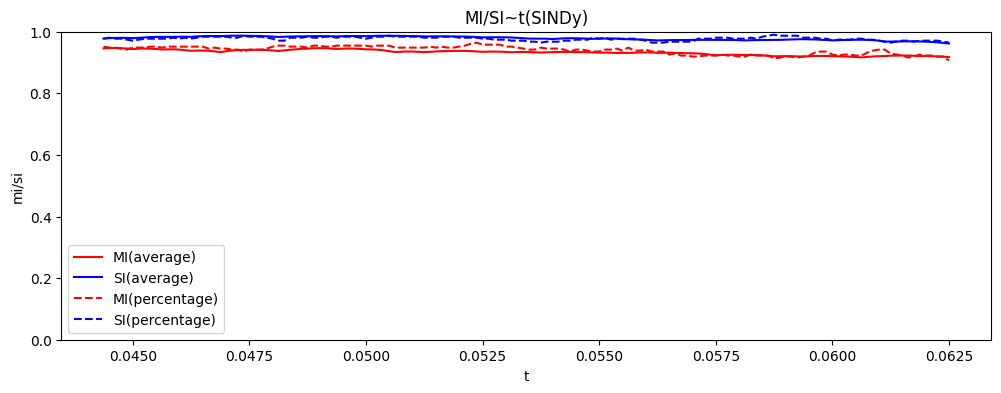

round: 72
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 326.766 1 + 213.318 Vx + 42.490 Vy + -11445.445 t + 69.176 VxVx + 9.077 VyVy + 104500.018 tt + -48.140 VxVy + -3391.924 Vxt + -304.617 Vyt + -0.695 VxVxVy + -1243.484 VxVxt + -134.852 VyVyt + 790.316 VxVyt + -3581.653 Vx_2 + -4580.495 Vy_2 + -6118.859 Vx_1 + -1009.280 Vy_1 + 9.426 VxVx_2 + -125.256 VxVy_2 + 132206.830 Vxt_2 + 6.988 VyVx_2 + -23.091 VyVy_2 + -1197135.971 Vyt_2 + 66.403 tVx_2 + -542.828 tVy_2 + 1224.638 tt_2 + 1.233 VxVxVx_2 + -202.227 VxVxVy_2 + 357.732 VxVxt_2 + -1046.075 VyVyVx_2 + 156.237 VyVyVy_2 + -10.564 VyVyt_2 + 169265.310 ttVx_2 + -58.574 ttVy_2 + 3.638 ttt_2 + -1546905.715 VxVyVx_2 + 29.928 VxVyVy_2 + -1949.465 VxVyt_2 + 169.118 VxtVx_2 + 0.533 VxtVy_2 + 1020.395 Vxtt_2 + -81.332 VytVx_2 + -402.531 VytVy_2 + -93.175 VxVx_1 + -261.150 VxVy_1 + 226874.086 Vxt_1 + -6.357 VyVx_1 + 40.663 VyVy_1 + -2083242.344 Vyt_1 + -183.221 tVx_1 + 1644.422 tVy_1 + 3471.125 tt_1 + -0.428 VxVxVx_1 + 182.965 VxVxVy_1 + -556.844 VxVxt

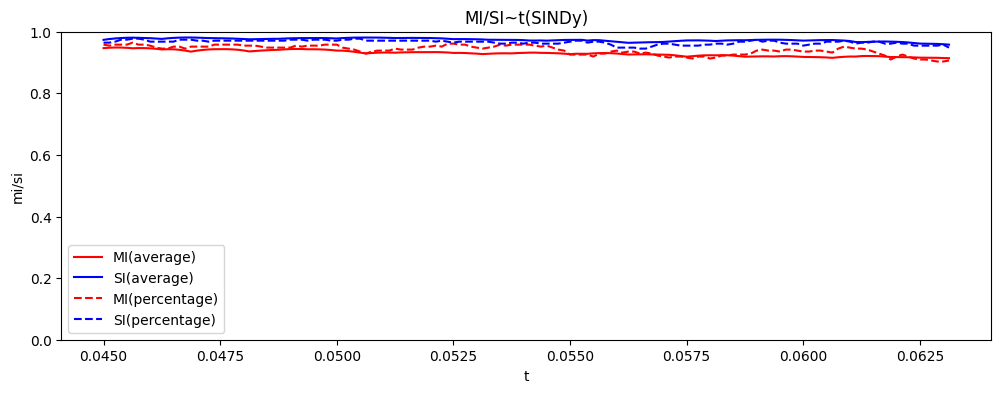

round: 73
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -42.328 1 + 236.856 Vx + -44.834 Vy + 2286.483 t + 48.764 VxVx + 7.566 VyVy + -22361.912 tt + -51.060 VxVy + -3851.429 Vxt + 1195.625 Vyt + -0.722 VxVxVy + -848.601 VxVxt + -99.405 VyVyt + 825.123 VxVyt + -3613.562 Vx_2 + -1570.191 Vy_2 + -3901.114 Vx_1 + -260.492 Vy_1 + 79.094 VxVx_2 + 78.733 VxVy_2 + 134529.798 Vxt_2 + 18.844 VyVx_2 + -55.079 VyVy_2 + -1229145.132 Vyt_2 + 54.409 tVx_2 + -1777.759 tVy_2 + -2485.989 tt_2 + 0.955 VxVxVx_2 + -405.229 VxVxVy_2 + 945.153 VxVxt_2 + -764.125 VyVyVx_2 + -218.163 VyVyVy_2 + -20.798 VyVyt_2 + 57053.113 ttVx_2 + -59.992 ttVy_2 + 4.244 ttt_2 + -511961.035 VxVyVx_2 + 80.225 VxVyVy_2 + 4938.377 VxVyt_2 + 422.061 VxtVx_2 + -0.581 VxtVy_2 + 1015.173 Vxtt_2 + -88.365 VytVx_2 + -1348.007 VytVy_2 + -199.463 VxVx_1 + -250.125 VxVy_1 + 142664.124 Vxt_1 + -23.036 VyVx_1 + 70.449 VyVy_1 + -1292314.922 Vyt_1 + -76.127 tVx_1 + 3662.395 tVy_1 + 3333.713 tt_1 + -0.947 VxVxVx_1 + 520.621 VxVxVy_1 + -1158.284 VxVxt_

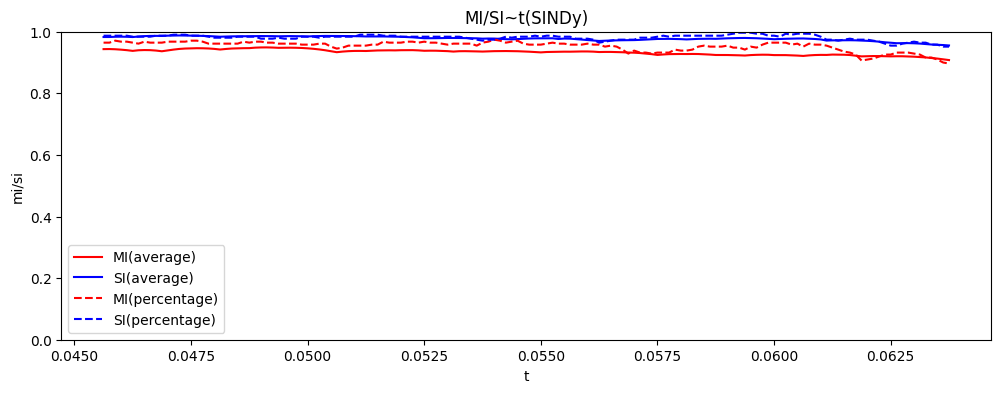

round: 74
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 465.707 1 + 137.043 Vx + 19.073 Vy + -16000.054 t + 21.820 VxVx + -10.646 VyVy + 141289.115 tt + -77.743 VxVy + -2121.959 Vxt + 135.988 Vyt + -0.926 VxVxVy + -354.690 VxVxt + 193.661 VyVyt + 1322.470 VxVyt + -3031.336 Vx_2 + -394.794 Vy_2 + -3308.768 Vx_1 + -1100.570 Vy_1 + 157.427 VxVx_2 + 3.659 VxVy_2 + 110345.394 Vxt_2 + 29.043 VyVx_2 + -18.135 VyVy_2 + -983944.810 Vyt_2 + 67.059 tVx_2 + -3330.897 tVy_2 + -1351.507 tt_2 + 1.409 VxVxVx_2 + -607.945 VxVxVy_2 + 366.985 VxVxt_2 + -1006.251 VyVyVx_2 + -146.889 VyVyVy_2 + -61.134 VyVyt_2 + 12539.924 ttVx_2 + -82.813 ttVy_2 + 10.029 ttt_2 + -94926.489 VxVyVx_2 + 44.102 VxVyVy_2 + 3918.454 VxVyt_2 + 1143.187 VxtVx_2 + -0.436 VxtVy_2 + 1483.859 Vxtt_2 + -192.671 VytVx_2 + -804.132 VytVy_2 + -76.138 VxVx_1 + -321.164 VxVy_1 + 119155.114 Vxt_1 + 128.331 VyVy_1 + -1061581.430 Vyt_1 + -35.295 tVx_1 + 1303.745 tVy_1 + 4708.052 tt_1 + -0.459 VxVxVx_1 + 69.837 VxVxVy_1 + -2184.814 VxVxt_1 + 576.848 Vy

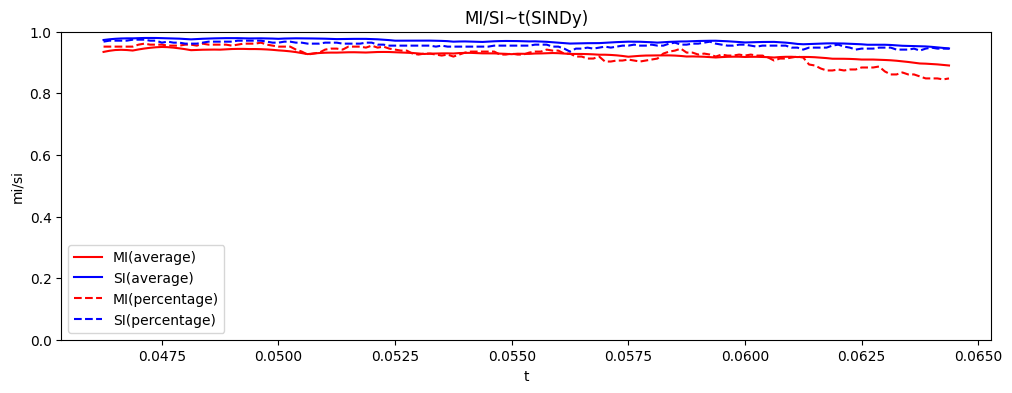

round: 75
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 731.373 1 + 150.412 Vx + -67.014 Vy + -25249.859 t + 20.931 VxVx + 6.606 VyVy + 220439.654 tt + -60.837 VxVy + -2284.265 Vxt + 1696.404 Vyt + -0.566 VxVxVy + -327.435 VxVxt + -109.719 VyVyt + 997.729 VxVyt + -3428.799 Vx_2 + -1680.843 Vy_2 + -4093.246 Vx_1 + -900.545 Vy_1 + 45.060 VxVx_2 + 192.761 VxVy_2 + 124524.998 Vxt_2 + 9.034 VyVx_2 + -69.505 VyVy_2 + -1109323.122 Vyt_2 + 52.914 tVx_2 + -1152.231 tVy_2 + -4882.479 tt_2 + 0.323 VxVxVx_2 + -228.214 VxVxVy_2 + 1288.426 VxVxt_2 + -750.314 VyVyVx_2 + -256.746 VyVyVy_2 + -63.755 VyVyt_2 + 61803.636 ttVx_2 + -52.215 ttVy_2 + 4.250 ttt_2 + -559271.087 VxVyVx_2 + 86.195 VxVyVy_2 + 6027.002 VxVyt_2 + 1198.964 VxtVx_2 + -0.124 VxtVy_2 + 799.501 Vxtt_2 + -92.299 VytVx_2 + -1541.801 VytVy_2 + -68.963 VxVx_1 + -219.598 VxVy_1 + 148423.361 Vxt_1 + -7.351 VyVx_1 + 69.400 VyVy_1 + -1330785.615 Vyt_1 + -35.972 tVx_1 + 1235.267 tVy_1 + 2771.067 tt_1 + -0.601 VxVxVx_1 + 187.561 VxVxVy_1 + -1150.724 VxVx

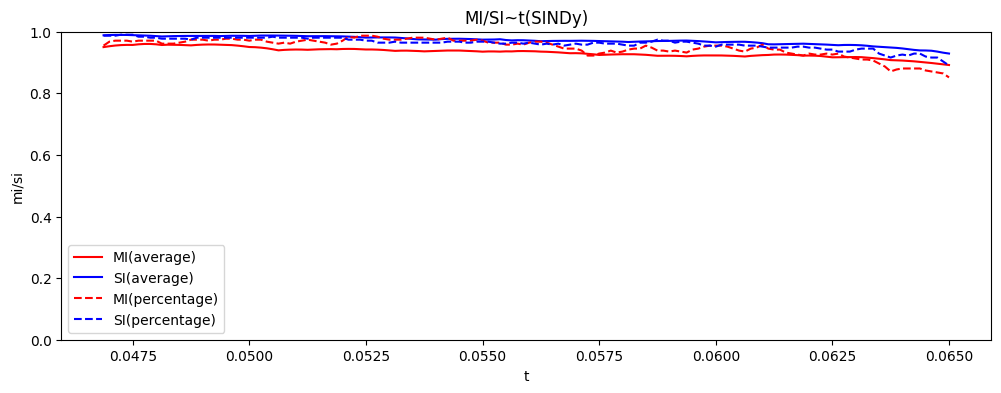

round: 76
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 959.225 1 + 111.520 Vx + -52.010 Vy + -33275.945 t + -14.229 VxVx + 14.763 VyVy + 290505.219 tt + -49.228 VxVy + -1640.714 Vxt + 1409.941 Vyt + -0.916 VxVxVy + 312.781 VxVxt + -232.552 VyVyt + 768.195 VxVyt + -2694.412 Vx_2 + -858.364 Vy_2 + -4320.725 Vx_1 + -1092.125 Vy_1 + 89.834 VxVx_2 + 326.025 VxVy_2 + 98143.172 Vxt_2 + 20.592 VyVx_2 + -93.754 VyVy_2 + -874760.232 Vyt_2 + 19.909 tVx_2 + -1820.433 tVy_2 + -7111.592 tt_2 + 0.125 VxVxVx_2 + -401.404 VxVxVy_2 + 1663.872 VxVxt_2 + -186.093 VyVyVx_2 + -365.998 VyVyVy_2 + -6.243 VyVyt_2 + 32295.928 ttVx_2 + -41.626 ttVy_2 + -3.440 ttt_2 + -296855.472 VxVyVx_2 + 90.410 VxVyVy_2 + 7679.929 VxVyt_2 + 109.877 VxtVx_2 + 600.779 Vxtt_2 + 53.586 VytVx_2 + -1535.378 VytVy_2 + -59.801 VxVx_1 + -281.533 VxVy_1 + 155105.636 Vxt_1 + -7.907 VyVx_1 + 85.570 VyVy_1 + -1377088.883 Vyt_1 + -10.047 tVx_1 + 842.589 tVy_1 + 3865.806 tt_1 + 0.425 VxVxVx_1 + 135.978 VxVxVy_1 + -1412.588 VxVxt_1 + 92.450 VyVyVx_1

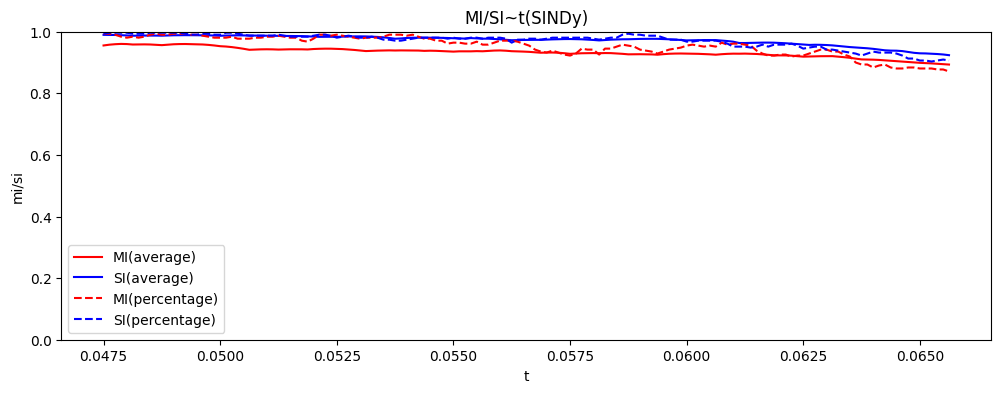

round: 77
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1119.422 1 + 3.330 Vx + -76.564 Vy + -38327.985 t + -0.518 VxVx + 10.929 VyVy + 329744.827 tt + -45.408 VxVy + 286.864 Vxt + 1792.642 Vyt + -1.123 VxVxVy + 74.187 VxVxt + -147.916 VyVyt + 667.892 VxVyt + -2079.294 Vx_2 + 73.261 Vy_2 + -3894.492 Vx_1 + -1597.881 Vy_1 + -38.563 VxVx_2 + 165.076 VxVy_2 + 74383.932 Vxt_2 + -4.335 VyVx_2 + -58.934 VyVy_2 + -649147.897 Vyt_2 + 85.198 tVx_2 + 387.569 tVy_2 + -4123.152 tt_2 + 0.051 VxVxVx_2 + 35.297 VxVxVy_2 + 1010.407 VxVxt_2 + -1281.025 VyVyVx_2 + -122.954 VyVyVy_2 + -36.496 VyVyt_2 + -2623.433 ttVx_2 + -92.418 ttVy_2 + 2.371 ttt_2 + 26525.423 VxVyVx_2 + 59.078 VxVyVy_2 + 3279.382 VxVyt_2 + 627.113 VxtVx_2 + -0.341 VxtVy_2 + 1479.412 Vxtt_2 + -49.425 VytVx_2 + -939.848 VytVy_2 + 17.329 VxVx_1 + 61.345 VxVy_1 + 136843.777 Vxt_1 + 14.822 VyVx_1 + -3.446 VyVy_1 + -1189905.824 Vyt_1 + -33.131 tVx_1 + -454.373 tVy_1 + -2289.655 tt_1 + 0.012 VxVxVx_1 + -231.819 VxVxVy_1 + 197.183 VxVxt_1 + 499.856 Vy

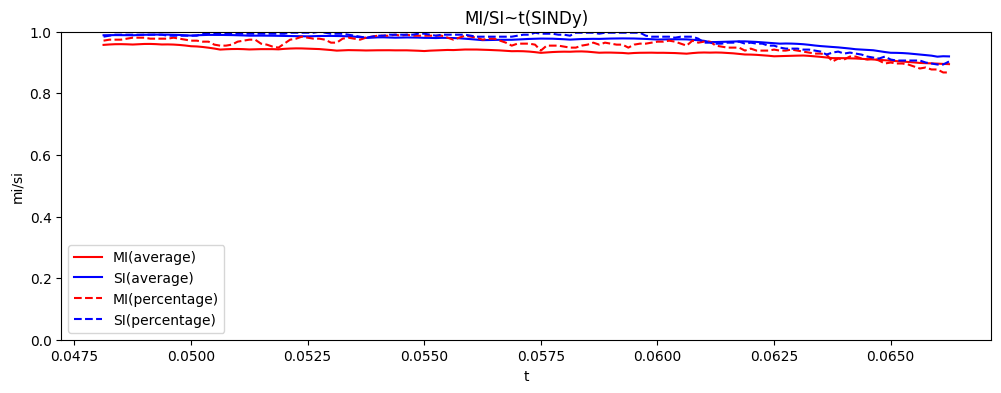

round: 78
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1519.225 1 + -142.389 Vx + 71.474 Vy + -51634.194 t + -52.905 VxVx + 3.914 VyVy + 439210.408 tt + -10.137 VxVy + 2887.371 Vxt + -880.812 Vyt + -0.826 VxVxVy + 981.195 VxVxt + -8.208 VyVyt + 19.196 VxVyt + -731.481 Vx_2 + -84.446 Vy_2 + -3437.398 Vx_1 + -347.999 Vy_1 + 63.041 VxVx_2 + -82.415 VxVy_2 + 28372.321 Vxt_2 + 15.654 VyVx_2 + -41.416 VyVy_2 + -258693.211 Vyt_2 + 15.561 tVx_2 + -1435.223 tVy_2 + 459.349 tt_2 + 0.137 VxVxVx_2 + -327.626 VxVxVy_2 + 656.364 VxVxt_2 + -1.184 VyVyVx_2 + 187.329 VyVyVy_2 + -0.196 VyVyt_2 + 3326.429 ttVx_2 + -14.087 ttVy_2 + -5.151 ttt_2 + -29395.628 VxVyVx_2 + 22.162 VxVyVy_2 + -2531.725 VxVyt_2 + 13.293 VxtVx_2 + 2.144 Vxtt_2 + 83.758 VytVx_2 + -218.329 VytVy_2 + 72.121 VxVx_1 + 126.883 VxVy_1 + 118672.235 Vxt_1 + 10.517 VyVx_1 + -18.752 VyVy_1 + -1014191.287 Vyt_1 + 7.801 tVx_1 + -1296.780 tVy_1 + -3631.965 tt_1 + -0.626 VxVxVx_1 + -111.426 VxVxVy_1 + 511.533 VxVxt_1 + -214.912 VyVyVx_1 + -196.991 VyVy

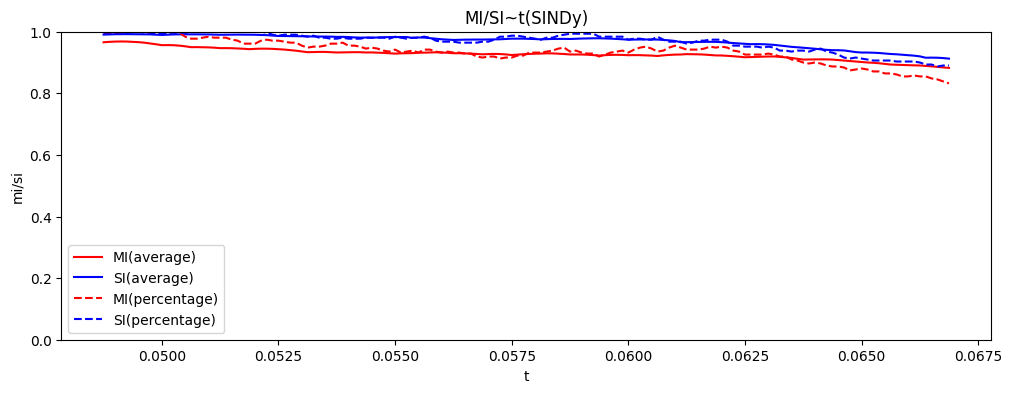

round: 79
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1494.963 1 + -78.034 Vx + 8.539 Vy + -49864.744 t + -60.045 VxVx + 15.917 VyVy + 416476.839 tt + -43.159 VxVy + 1776.090 Vxt + 189.214 Vyt + -0.905 VxVxVy + 1108.888 VxVxt + -221.669 VyVyt + 618.508 VxVyt + -2506.538 Vx_2 + -290.500 Vy_2 + -4144.173 Vx_1 + -1341.985 Vy_1 + -135.223 VxVx_2 + 80.153 VxVy_2 + 89373.914 Vxt_2 + -21.519 VyVx_2 + -82.621 VyVy_2 + -780088.395 Vyt_2 + 15.157 tVx_2 + 1914.420 tVy_2 + -2418.952 tt_2 + 0.433 VxVxVx_2 + 304.492 VxVxVy_2 + 1397.673 VxVxt_2 + -30.735 VyVyVx_2 + 128.596 VyVyVy_2 + 11.180 VyVyt_2 + 9959.954 ttVx_2 + 16.581 ttVy_2 + -5.804 ttt_2 + -82194.743 VxVyVx_2 + 64.961 VxVyVy_2 + -1448.959 VxVyt_2 + -204.534 VxtVx_2 + -0.162 VxtVy_2 + -420.746 Vxtt_2 + 92.702 VytVx_2 + -988.725 VytVy_2 + 25.980 VxVx_1 + -18.477 VxVy_1 + 142392.561 Vxt_1 + 25.087 VyVx_1 + 27.192 VyVy_1 + -1211532.308 Vyt_1 + 12.510 tVx_1 + -371.466 tVy_1 + -1131.581 tt_1 + -0.640 VxVxVx_1 + -333.488 VxVxVy_1 + -323.474 VxVxt_1 + -35

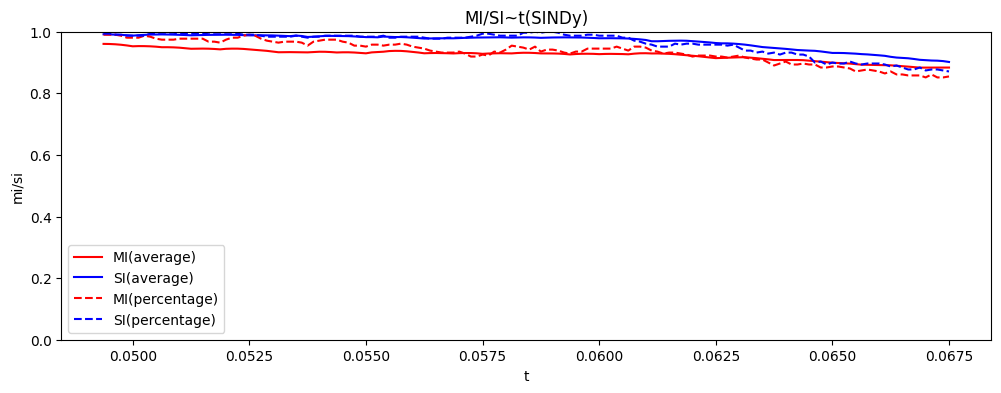

round: 80
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 670.147 1 + -28.880 Vx + 12.346 Vy + -21443.917 t + -48.580 VxVx + -23.546 VyVy + 173585.795 tt + 16.330 VxVy + 834.392 Vxt + 220.283 Vyt + -0.973 VxVxVy + 879.987 VxVxt + 480.714 VyVyt + -408.412 VxVyt + -143.205 Vx_2 + 2010.580 Vy_2 + -1999.091 Vx_1 + -163.764 Vy_1 + -198.485 VxVx_2 + 102.725 VxVy_2 + 8331.629 Vxt_2 + -28.375 VyVx_2 + -2.435 VyVy_2 + -91097.694 Vyt_2 + -12.539 tVx_2 + 3069.965 tVy_2 + -3015.062 tt_2 + 0.379 VxVxVx_2 + 430.457 VxVxVy_2 + -23.341 VxVxt_2 + 428.397 VyVyVx_2 + 142.593 VyVyVy_2 + 47.938 VyVyt_2 + -68259.790 ttVx_2 + 57.371 ttVy_2 + -5.025 ttt_2 + 577617.186 VxVyVx_2 + -23.404 VxVyVy_2 + -1390.566 VxVyt_2 + -806.027 VxtVx_2 + -0.274 VxtVy_2 + -1101.632 Vxtt_2 + 77.273 VytVx_2 + 566.060 VytVy_2 + 121.137 VxVx_1 + -106.044 VxVy_1 + 69624.050 Vxt_1 + 45.381 VyVx_1 + -36.494 VyVy_1 + -598661.068 Vyt_1 + -6.576 tVx_1 + -2094.668 tVy_1 + 139.837 tt_1 + -705.645 VxVxVy_1 + 766.534 VxVxt_1 + -36.293 VyVyVx_1 + 5.674 

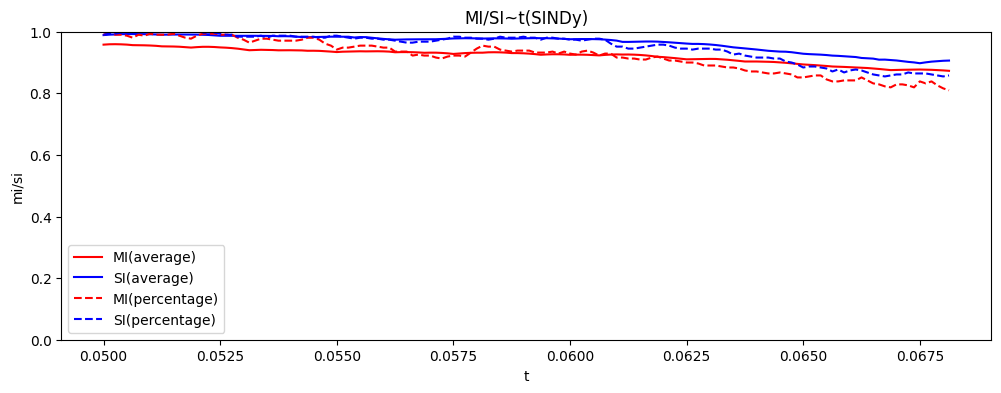

round: 81
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1258.275 1 + -26.300 Vx + 58.881 Vy + -41481.432 t + -38.890 VxVx + -35.586 VyVy + 343652.953 tt + 8.236 VxVy + 796.103 Vxt + -468.893 Vyt + -1.264 VxVxVy + 703.605 VxVxt + 660.786 VyVyt + -270.441 VxVyt + 1573.364 Vx_2 + 2919.625 Vy_2 + 725.946 Vx_1 + -675.383 Vy_1 + -81.107 VxVx_2 + 219.032 VxVy_2 + -50008.836 Vxt_2 + -10.914 VyVy_2 + 401632.030 Vyt_2 + 24.173 tVx_2 + 1117.961 tVy_2 + -5134.027 tt_2 + 1.026 VxVxVx_2 + -40.823 VxVxVy_2 + 159.567 VxVxt_2 + -210.296 VyVyVx_2 + 23.536 VyVyVy_2 + -6.533 VyVyt_2 + -98362.290 ttVx_2 + 47.426 ttVy_2 + -1.889 ttt_2 + 824736.093 VxVyVx_2 + -6.474 VxVyVy_2 + 679.568 VxVyt_2 + 71.132 VxtVx_2 + -0.304 VxtVy_2 + -843.802 Vxtt_2 + 28.620 VytVx_2 + 252.983 VytVy_2 + 118.097 VxVx_1 + -342.194 VxVy_1 + -22444.177 Vxt_1 + 54.335 VyVx_1 + 9.222 VyVy_1 + 172902.479 Vyt_1 + -98.894 tVx_1 + -2031.527 tVy_1 + 3889.823 tt_1 + -836.654 VxVxVy_1 + 102.763 VxVxt_1 + 1570.202 VyVyVx_1 + 220.885 VyVyVy_1 + -103.788 

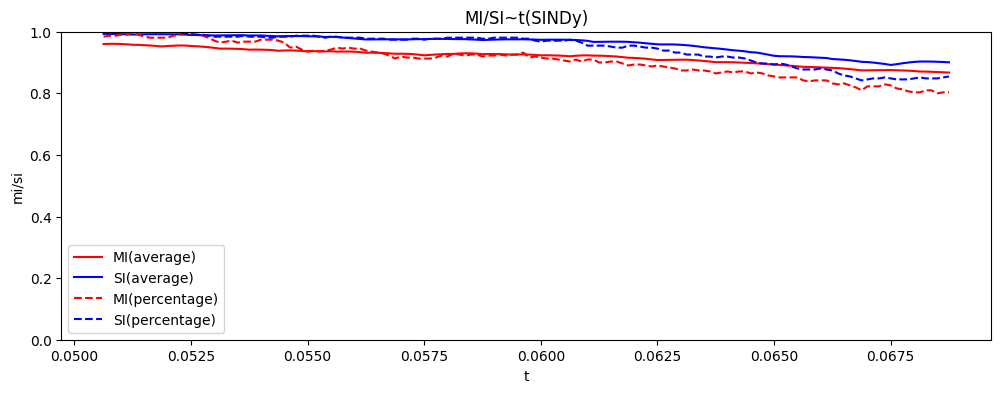

round: 82
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 2824.473 1 + 21.818 Vx + 58.786 Vy + -93622.514 t + -34.784 VxVx + -31.151 VyVy + 774534.574 tt + -15.712 VxVy + 35.342 Vxt + -445.065 Vyt + -1.222 VxVxVy + 625.448 VxVxt + 605.953 VyVyt + 119.878 VxVyt + 3240.600 Vx_2 + 250.758 Vy_2 + -3279.007 Vx_1 + 872.443 Vy_1 + -81.852 VxVx_2 + 226.909 VxVy_2 + -104214.097 Vxt_2 + 5.993 VyVx_2 + -19.059 VyVy_2 + 839964.720 Vyt_2 + 16.894 tVx_2 + 1088.016 tVy_2 + -5251.340 tt_2 + 1.093 VxVxVx_2 + -157.543 VxVxVy_2 + 270.779 VxVxt_2 + -49.924 VyVyVx_2 + -145.318 VyVyVy_2 + -44.331 VyVyt_2 + -6507.288 ttVx_2 + 32.883 ttVy_2 + -4.036 ttt_2 + 41487.174 VxVyVx_2 + -5.813 VxVyVy_2 + 3524.134 VxVyt_2 + 760.475 VxtVx_2 + -0.696 VxtVy_2 + -634.532 Vxtt_2 + 53.312 VytVx_2 + 253.615 VytVy_2 + 87.818 VxVx_1 + -293.167 VxVy_1 + 112795.438 Vxt_1 + 56.601 VyVx_1 + 105.436 VyVy_1 + -960936.370 Vyt_1 + -33.341 tVx_1 + -1531.226 tVy_1 + 3095.918 tt_1 + 0.320 VxVxVx_1 + -883.548 VxVxVy_1 + -1534.963 VxVxt_1 + 539.305 V

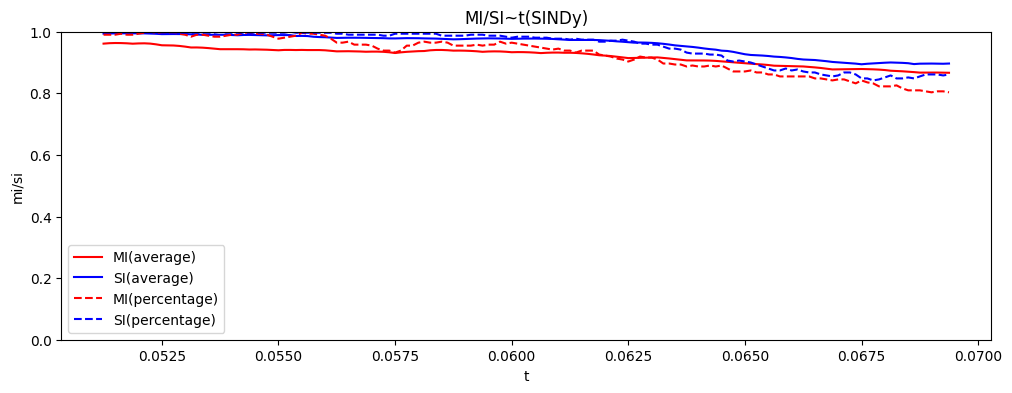

round: 83
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3153.137 1 + 79.665 Vx + 12.015 Vy + -103802.452 t + -42.764 VxVx + -43.017 VyVy + 853118.815 tt + -30.222 VxVy + -902.159 Vxt + 279.927 Vyt + -1.431 VxVxVy + 752.979 VxVxt + 795.414 VyVyt + 344.278 VxVyt + 4506.315 Vx_2 + -170.425 Vy_2 + -1870.981 Vx_1 + -549.365 Vy_1 + -187.093 VxVx_2 + 487.034 VxVy_2 + -145252.722 Vxt_2 + -15.495 VyVx_2 + -12.507 VyVy_2 + 1171098.144 Vyt_2 + 62.330 tVx_2 + 2675.456 tVy_2 + -9300.965 tt_2 + 1.624 VxVxVx_2 + 169.027 VxVxVy_2 + 138.117 VxVxt_2 + -792.984 VyVyVx_2 + -310.850 VyVyVy_2 + -47.586 VyVyt_2 + 8605.838 ttVx_2 + 10.557 ttVy_2 + -2.418 ttt_2 + -91612.324 VxVyVx_2 + -2.154 VxVyVy_2 + 5945.237 VxVyt_2 + 737.660 VxtVx_2 + 0.149 VxtVy_2 + -269.769 Vxtt_2 + 30.279 VytVx_2 + 239.375 VytVy_2 + 118.845 VxVx_1 + -545.650 VxVy_1 + 66889.635 Vxt_1 + 71.471 VyVx_1 + 132.939 VyVy_1 + -588234.837 Vyt_1 + -50.691 tVx_1 + -1985.297 tVy_1 + 7044.433 tt_1 + 0.496 VxVxVx_1 + -1118.052 VxVxVy_1 + -1879.461 VxVxt_1 + 8

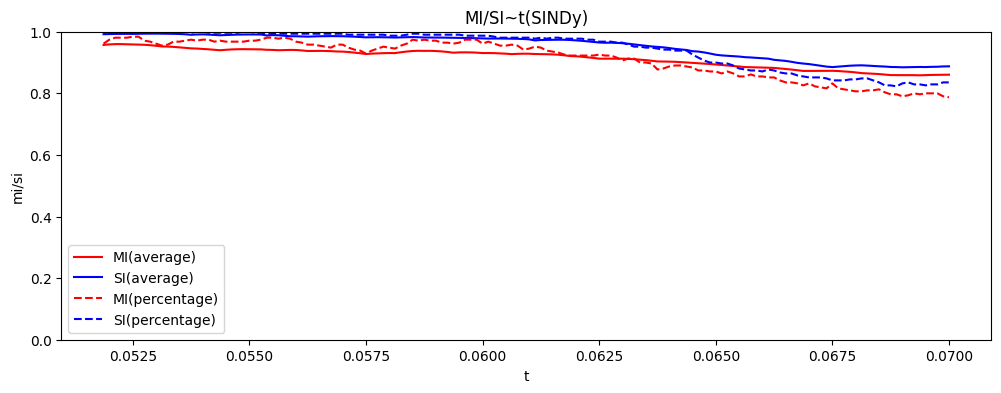

round: 84
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3059.628 1 + 70.689 Vx + 46.459 Vy + -100275.976 t + -60.055 VxVx + -59.055 VyVy + 821245.579 tt + -28.341 VxVy + -858.826 Vxt + -217.977 Vyt + -1.049 VxVxVy + 969.077 VxVxt + 1058.839 VyVyt + 361.282 VxVyt + 4178.613 Vx_2 + -1244.806 Vy_2 + -2269.070 Vx_1 + -1424.020 Vy_1 + -71.196 VxVx_2 + 226.434 VxVy_2 + -134431.657 Vxt_2 + 10.106 VyVx_2 + -7.461 VyVy_2 + 1083816.159 Vyt_2 + -28.724 tVx_2 + 893.428 tVy_2 + -5206.179 tt_2 + 1.705 VxVxVx_2 + -243.839 VxVxVy_2 + 51.380 VxVxt_2 + 628.470 VyVyVx_2 + -269.263 VyVyVy_2 + -167.069 VyVyt_2 + 39926.538 ttVx_2 + 75.507 ttVy_2 + 12.497 ttt_2 + -314441.139 VxVyVx_2 + -12.961 VxVyVy_2 + 5484.904 VxVyt_2 + 2651.058 VxtVx_2 + -0.625 VxtVy_2 + -1245.241 Vxtt_2 + -199.327 VytVx_2 + 391.460 VytVy_2 + -65.084 VxVx_1 + -470.559 VxVy_1 + 76810.020 Vxt_1 + 39.644 VyVx_1 + 135.347 VyVy_1 + -643628.249 Vyt_1 + 13.577 tVx_1 + 753.743 tVy_1 + 5992.600 tt_1 + 0.419 VxVxVx_1 + -656.041 VxVxVy_1 + -1938.866 VxVxt_

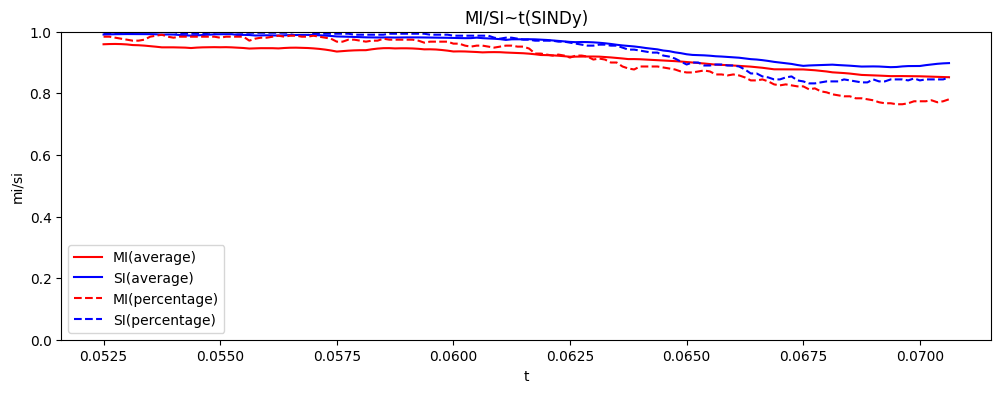

round: 85
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3133.350 1 + 92.413 Vx + -22.953 Vy + -103006.191 t + -37.614 VxVx + -56.794 VyVy + 846217.396 tt + -41.956 VxVy + -1252.769 Vxt + 833.430 Vyt + -0.765 VxVxVy + 612.138 VxVxt + 1025.477 VyVyt + 592.262 VxVyt + 4649.130 Vx_2 + -512.828 Vy_2 + 375.832 Vx_1 + -1467.640 Vy_1 + -13.023 VxVx_2 + 389.582 VxVy_2 + -149029.695 Vxt_2 + 26.700 VyVx_2 + 2.285 VyVy_2 + 1196707.941 Vyt_2 + 5.125 tVx_2 + -41.891 tVy_2 + -7713.199 tt_2 + 1.279 VxVxVx_2 + -512.200 VxVxVy_2 + -115.097 VxVxt_2 + 88.761 VyVyVx_2 + -517.238 VyVyVy_2 + -90.260 VyVyt_2 + 19422.874 ttVx_2 + 27.110 ttVy_2 + -6.662 ttt_2 + -174164.201 VxVyVx_2 + -27.527 VxVyVy_2 + 9399.204 VxVyt_2 + 1404.289 VxtVx_2 + -0.509 VxtVy_2 + -498.182 Vxtt_2 + 108.216 VytVx_2 + 650.516 VytVy_2 + -72.312 VxVx_1 + -258.999 VxVy_1 + -5765.050 Vxt_1 + 50.543 VyVx_1 + 98.085 VyVy_1 + -3052.897 Vyt_1 + -4.887 tVx_1 + 888.832 tVy_1 + 2569.242 tt_1 + 1.688 VxVxVx_1 + -843.861 VxVxVy_1 + -1367.884 VxVxt_1 + 270.23

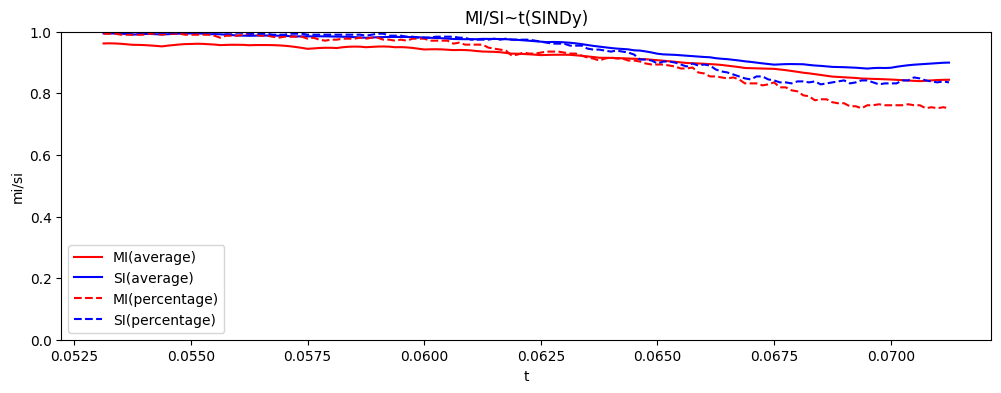

round: 86
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 3708.733 1 + 178.143 Vx + -2.530 Vy + -120819.838 t + -14.510 VxVx + -86.873 VyVy + 983129.149 tt + -40.107 VxVy + -2597.112 Vxt + 515.776 Vyt + -0.638 VxVxVy + 247.906 VxVxt + 1494.386 VyVyt + 522.953 VxVyt + 5327.585 Vx_2 + -2434.553 Vy_2 + 437.717 Vx_1 + -2627.997 Vy_1 + -99.309 VxVx_2 + 385.775 VxVy_2 + -169833.162 Vxt_2 + 17.510 VyVx_2 + 39.354 VyVy_2 + 1355394.010 Vyt_2 + 61.002 tVx_2 + 1234.500 tVy_2 + -7667.825 tt_2 + 1.538 VxVxVx_2 + -385.137 VxVxVy_2 + -693.555 VxVxt_2 + -768.267 VyVyVx_2 + -496.748 VyVyVy_2 + -142.910 VyVyt_2 + 80676.665 ttVx_2 + 18.987 ttVy_2 + -0.160 ttt_2 + -659805.970 VxVyVx_2 + -40.164 VxVyVy_2 + 9201.970 VxVyt_2 + 2195.124 VxtVx_2 + -0.183 VxtVy_2 + -403.628 Vxtt_2 + 9.738 VytVx_2 + 825.689 VytVy_2 + -97.724 VxVx_1 + -499.929 VxVy_1 + -9042.852 Vxt_1 + 53.479 VyVx_1 + 139.101 VyVy_1 + 33258.950 Vyt_1 + -23.612 tVx_1 + 1355.265 tVy_1 + 6224.391 tt_1 + 1.614 VxVxVx_1 + -883.967 VxVxVy_1 + -1894.690 VxVxt_1 

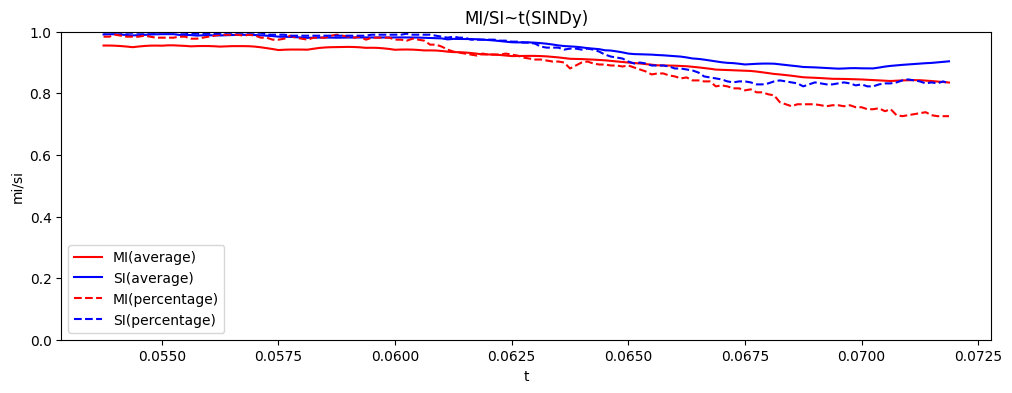

round: 87
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 4993.510 1 + 240.367 Vx + -2.472 Vy + -161434.926 t + -11.414 VxVx + -71.924 VyVy + 1302345.991 tt + -54.738 VxVy + -3539.948 Vxt + 486.050 Vyt + -0.991 VxVxVy + 191.899 VxVxt + 1266.403 VyVyt + 747.457 VxVyt + 6529.985 Vx_2 + -1994.952 Vy_2 + 1683.437 Vx_1 + -3925.751 Vy_1 + -100.351 VxVx_2 + 591.354 VxVy_2 + -208133.843 Vxt_2 + 18.039 VyVx_2 + -23.885 VyVy_2 + 1659977.967 Vyt_2 + 50.564 tVx_2 + 1224.590 tVy_2 + -10733.081 tt_2 + 1.681 VxVxVx_2 + -401.519 VxVxVy_2 + 257.997 VxVxt_2 + -626.438 VyVyVx_2 + -788.005 VyVyVy_2 + -102.984 VyVyt_2 + 67036.305 ttVx_2 + 4.439 ttVy_2 + -3.023 ttt_2 + -553761.653 VxVyVx_2 + 35.076 VxVyVy_2 + 13523.633 VxVyt_2 + 1595.040 VxtVx_2 + -0.173 VxtVy_2 + -144.385 Vxtt_2 + 51.156 VytVx_2 + -294.282 VytVy_2 + -221.624 VxVx_1 + -492.654 VxVy_1 + -48382.662 Vxt_1 + 39.890 VyVx_1 + 135.404 VyVy_1 + 343647.124 Vyt_1 + 14.032 tVx_1 + 3226.373 tVy_1 + 6018.888 tt_1 + 2.220 VxVxVx_1 + -689.553 VxVxVy_1 + -1807.514 V

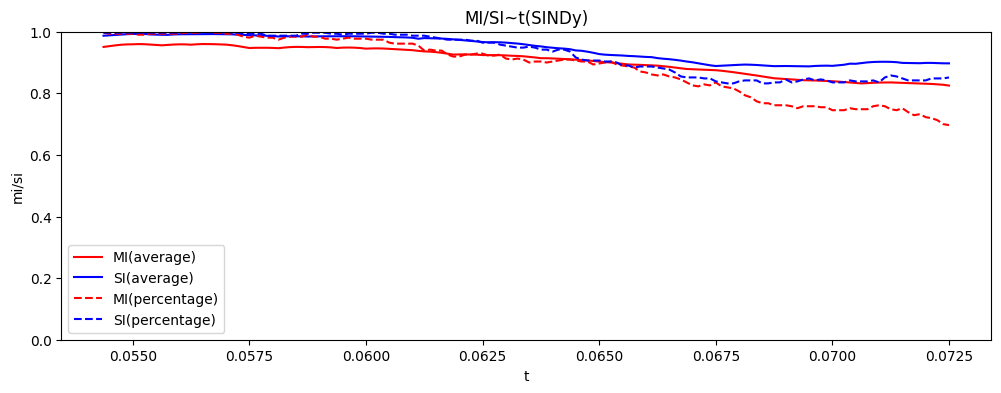

round: 88
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 4546.882 1 + 104.219 Vx + 27.097 Vy + -147065.310 t + -43.685 VxVx + -63.095 VyVy + 1188070.795 tt + -11.931 VxVy + -1517.132 Vxt + -48.771 Vyt + -0.573 VxVxVy + 694.703 VxVxt + 1110.336 VyVyt + 94.296 VxVyt + 6574.728 Vx_2 + -3089.068 Vy_2 + 1501.973 Vx_1 + -4001.101 Vy_1 + -161.758 VxVx_2 + 730.615 VxVy_2 + -210228.268 Vxt_2 + 11.328 VyVx_2 + -61.089 VyVy_2 + 1681999.753 Vyt_2 + 66.099 tVx_2 + 2163.243 tVy_2 + -12685.051 tt_2 + 1.985 VxVxVx_2 + -296.608 VxVxVy_2 + 839.451 VxVxt_2 + -865.927 VyVyVx_2 + -870.647 VyVyVy_2 + -181.558 VyVyt_2 + 103944.776 ttVx_2 + 55.563 ttVy_2 + 5.264 ttt_2 + -863208.824 VxVyVx_2 + 80.107 VxVyVy_2 + 14542.886 VxVyt_2 + 2792.127 VxtVx_2 + -0.649 VxtVy_2 + -922.639 Vxtt_2 + -71.121 VytVx_2 + -1008.851 VytVy_2 + -104.428 VxVx_1 + -429.378 VxVy_1 + -40776.387 Vxt_1 + 74.911 VyVx_1 + 95.403 VyVy_1 + 268969.297 Vyt_1 + 18.830 tVx_1 + 1439.474 tVy_1 + 5170.203 tt_1 + 1.773 VxVxVx_1 + -1215.264 VxVxVy_1 + -1188.583

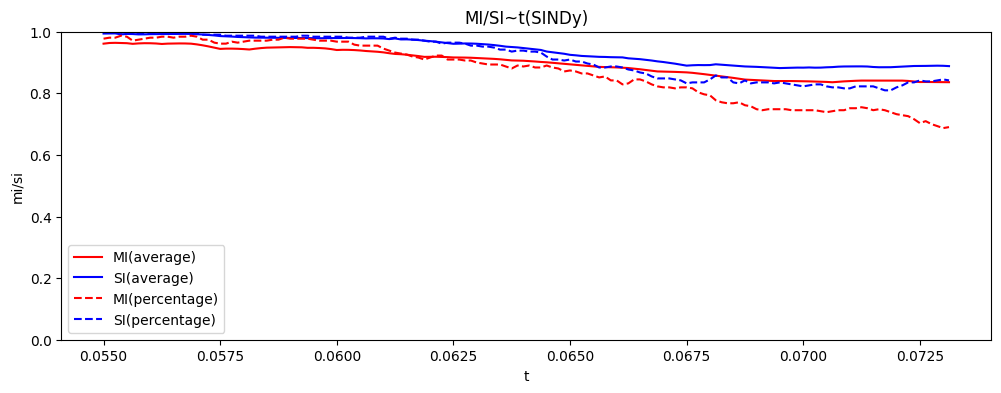

round: 89
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 4622.405 1 + 92.368 Vx + 11.163 Vy + -148586.561 t + -72.304 VxVx + -87.756 VyVy + 1193680.768 tt + -14.479 VxVy + -1380.690 Vxt + 128.824 Vyt + 0.073 VxVxVy + 1153.175 VxVxt + 1471.107 VyVyt + 126.016 VxVyt + 7381.548 Vx_2 + -5273.481 Vy_2 + 913.128 Vx_1 + -3908.379 Vy_1 + -217.537 VxVx_2 + 760.811 VxVy_2 + -234990.637 Vxt_2 + 6.161 VyVx_2 + -42.764 VyVy_2 + 1872208.005 Vyt_2 + 116.465 tVx_2 + 2988.277 tVy_2 + -12969.797 tt_2 + 2.071 VxVxVx_2 + -218.677 VxVxVy_2 + 580.526 VxVxt_2 + -1654.453 VyVyVx_2 + -960.207 VyVyVy_2 + -257.178 VyVyt_2 + 173540.421 ttVx_2 + 39.646 ttVy_2 + 9.460 ttt_2 + -1416336.492 VxVyVx_2 + 65.352 VxVyVy_2 + 15772.879 VxVyt_2 + 3930.074 VxtVx_2 + -1.086 VxtVy_2 + -648.997 Vxtt_2 + -127.190 VytVx_2 + -823.044 VytVy_2 + -253.920 VxVx_1 + -413.588 VxVy_1 + -22097.895 Vxt_1 + 43.772 VyVx_1 + 142.641 VyVy_1 + 121037.911 Vyt_1 + 52.599 tVx_1 + 3578.584 tVy_1 + 5026.765 tt_1 + 1.820 VxVxVx_1 + -748.711 VxVxVy_1 + -1880.41

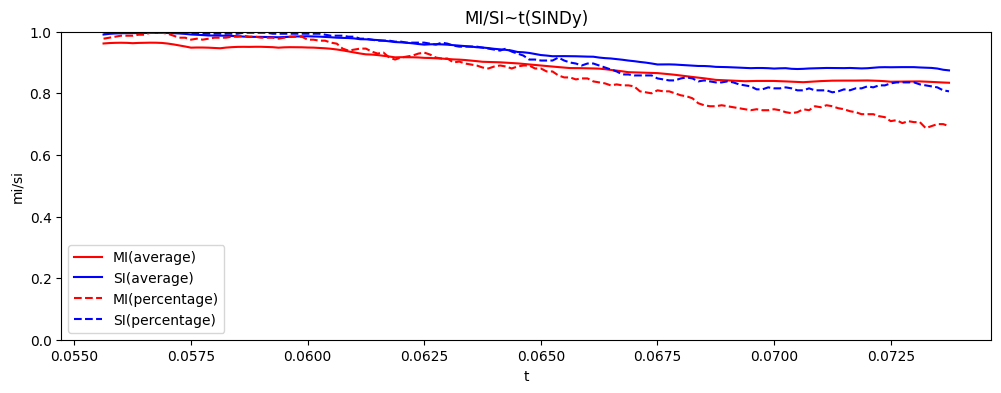

In [6]:
left_bond=0
test_range=90
good_time=np.zeros(test_range)

v_train=np.zeros((n,n,p_tot,3))
t_train=np.zeros(p_tot)
v_test=np.zeros((n,n,p_tot,3))



for k in range(test_range):
    print('round:',k)
    startp=left_bond+k
    endp=left_bond+k+dp
    v_train=u_train[:,:,startp*addp:(endp-1)*addp+1]   
    t_train=v_train[0,0,:,2]
    
    dt_train=v_train[0,0,1,2]-v_train[0,0,0,2]
    
    
    v_test=u_test[:,:,startp*addp:(endp-1)*addp+1]
    
    print(v_train.shape)
    print(t_train.shape)
    
    
    '''
    np.save('v_train.npy',v_train)
    np.savetxt('v_train_dot.txt',v_train_dot)
    np.savetxt('t_train.txt',t_train)
    '''
    model=getmodel(v_train,spatial_grid, dt_train)
    
    x_dot_test_predicted = model.predict(v_test)
    x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
    tlen=p_tot
    dot_tmp=np.array(x_dot_test_predicted)
    pltpredict=np.zeros((n,n,tlen,2))
    #print(dot_tmp[10,10])

    
    pltpredict[:,:,0]=v_train[:,:,0,:2]
    for i in range(tlen-1):
        pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
    
    for i in range(p_tot):
        j=i
        mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        if mi_t_per[i]>0.8 and si_t_per[i]>0.8:
            good_time[k]=good_time[k]+1

        '''
        if i%(addp)==0:
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 3, 1)
            plt.title('MI percetage '+str(mi_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.subplot(1, 3, 2)
            plt.title('SI percetage '+str(si_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
            plt.legend()
            plt.subplot(1, 3, 3)
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.show()
        '''
    
    plt.figure(figsize=(12, 4))
    plt.title('MI/SI~t(SINDy)')
    plt.ylim(0,1)
    plt.xlabel('t')
    plt.ylabel('mi/si')
    plt.plot(t_train,mi_t,'r',label='MI(average)')
    plt.plot(t_train,si_t,'b',label='SI(average)')
    plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
    plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
    plt.legend()
    plt.ylim(0.0, 1)
    plt.plot
    plt.show()
    good_time[k]=good_time[k]/addp



fit_time: [ 2.   2.6  3.8  4.4  4.   3.6  2.8  3.6  3.2  3.   5.2  9.2  8.2  7.2
  6.2  5.4  6.2 10.   9.2  8.6  8.   8.   7.6  8.  11.2 15.2 24.  25.6
 29.2 28.8 26.4 27.  27.4 22.2 24.6 24.2 22.6 19.  17.4 20.6 14.2 13.6
 12.8 15.6 18.8 20.2 25.6 28.2 29.2 29.2 29.2 29.2 29.2 29.  29.2 29.
 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2
 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.  29.2 27.
 25.  24.  22.8 22.  20.6 19.4]


<function matplotlib.pyplot.show(close=None, block=None)>

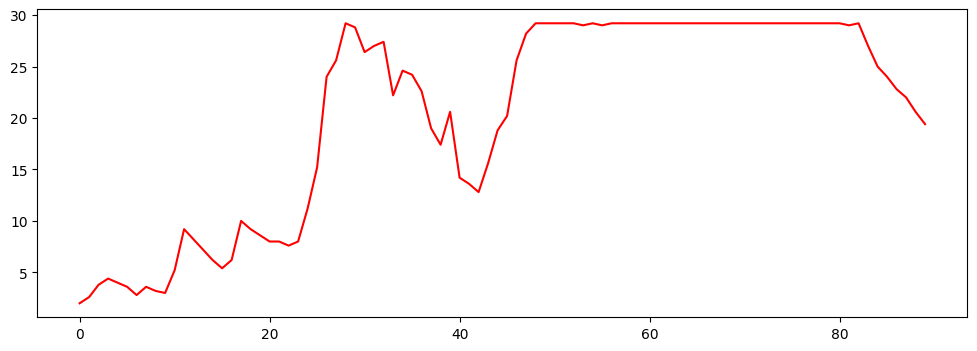

In [7]:
print('fit_time:',good_time)
plt.figure(figsize=(12, 4))
plt.plot(range(test_range),good_time,'r')
plt.show